In [1]:
# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE
# pip install torchmetrics==1.2.0 pandas==2.1.4 numpy==1.26.4
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalLoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch

model_inference = True # False
if model_inference is True:
    cohort = "TCGA"
    geneNUM = "" # _4692genes tcgadata tcgalabel tcgadata_4692genes tcgalabel_4692genes

test = False #False, True: batch_size = 3, num_epoch = 2, full dataset

drug_df_path= "../data/GDSC/GDSC_drug_merge_pubchem_dropNA_MACCS.csv"
one_drug=None # gsk690693 trametinib erlotinib
ESPF_file = "./ESPF/(NAN) subword_units_map_chembl_freq_1500.csv" #(NAN) subword_units_map_chembl_freq_1500.csv
AUC_df_path_numerical = "../data/GDSC/GDSC2_fitted_dose_response_27Oct23 from GDSC MaxScreen threshold ModelID678 drug230 samples142188 balanced_high.csv" # gdsc1+2_ccle_z-score　gdsc1+2_ccle_AUC
AUC_df_path = "../data/GDSC/GDSC2_fitted_dose_response_27Oct23 from GDSC MaxScreen threshold ModelID678 drug230 samples142188 balanced_high.csv"
response_file = 'down_high'# down/up _ high/even/low 、imbalanced
omics_files = {
    'Mut': "",
    'Exp': "../data/DAPL/share/ccle_uq1000_feature_sorted.csv", # "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[128,32],'Exp':[128,32],  # Dr.Chiu:exp[500,200,50]  [1000,100,50] 'Mut':[128,32],'Exp':[128,32], 'Mut':[1000,100,50],'Exp':[1000,100,50],
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

# TCGA pretrain weight load or not 
TCGA_pretrain_weight_path_dict = None #{'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  #'Exp': "./results/Encoder_tcga_exp_128_32_best_loss_0.2182988.pt", # "./results/Encoder_tcga_exp_128_32_best_loss_0.2182988.pt", "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt"
                                  # Add more omics types and paths as needed
                              # }
seed = 42

model_name = "Omics_DrugESPF_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
# samples splitType= 'byCCL' # byCCL byDrug 
splitType= 'ModelID' # ModelID or drug_name or whole
response = "lnIC50" # 

#------------------graph-------------
drug_graph = False # False True
drug_graph_pool = "add"
DCSA = False # False True # Drug_Cell_SelfAttention
drug_pretrain_weight_path = '../data/DAPL/share/pretrain/drug_encoder.pth' 
DrugGraph_pretrainDim = 10
#------------------------------------

kfoldCV = 5
include_omics = ['Exp']
DA_Folder = "VAEwC_1" # None VAE_w10SC VAEwC_1
if DA_Folder != 'None':
    omics_files['Exp'] = f"../data/DAPL/share/pretrain/{DA_Folder}/ccle_latent_results.pkl" #

max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128 # graph:32; ESPF: 128

ESPF = False # False True
Drug_SelfAttention = False
n_layer = 1 # transformer layer number # control both Drug_SelfAttention and DCSA
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size = drug_embedding_feature_size*2 # graph:64; ESPF: 256 
num_attention_heads = 8      
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1
classifier_drop = 0
GINconv_drop =0

if ESPF is True:
    drug_dim = max_drug_len* drug_embedding_feature_size #50*128
    drug_encode_dims =[drug_dim//4,drug_dim//16,drug_dim//64] #  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][len(omics_encode_dim_dict[omic_type])-1] for omic_type in include_omics) + drug_encode_dims[-1] # MLPDim
elif ESPF is False:
    drug_encode_dims =[110,55,22] #MACCS166
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][len(omics_encode_dim_dict[omic_type])-1] for omic_type in include_omics) + drug_encode_dims[-1] # MLPDim
if model_name == "Omics_DCSA_Model":
    drug_encode_dims = None
    conc_dim = (max_drug_len+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*drug_embedding_feature_size)
    dense_layer_dim = [conc_dim, conc_dim//10, conc_dim//100, 1] #7064or3736
if model_name == "GIN_DCSA_model":
    if DCSA is True:
        drug_encode_dims = None
        conc_dim = (1+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*drug_embedding_feature_size)
        dense_layer_dim = [conc_dim, conc_dim//2, 1] # [conc_dim, conc_dim//2, conc_dim//2 , 1] 40*2+32=112,56,28,1
    elif DCSA is False:
        drug_encode_dims = None
        conc_dim = (1+len(include_omics))*drug_embedding_feature_size # 32*2=64
        dense_layer_dim = [conc_dim, conc_dim//2, 1] #[conc_dim, conc_dim, conc_dim, 1] 64
print("drug_encode_dims",drug_encode_dims)
print("dense_layer_dim",dense_layer_dim)
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 400
num_epoch = 800 # for k fold CV 
patience = 20
learning_rate=1e-05

warmup_lr = True # False True
decrese_epoch = 60
Decrease_percent = 1
continuous = True

CosineAnnealing_LR = False # False True
T_max = 3 # CosinesAnnealingLR step size
eta_min = 1e-06 # CosinesAnnealingLR minimum learning rate

criterion = Custom_LossFunction(loss_type="BCE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()##nn.MSELoss()#
# criterion =  FocalLoss(loss_type="MSE", alpha=8.0, gamma=1.0, regular_type=None, regular_lambda=1e-05) # loss_type="MSE"/"MAE"
# criterion = FocalHuberLoss(loss_type="FocalHuberLoss",delta=0.2, alpha=0.3, gamma=2.0, regular_type=None, regular_lambda=1e-05)
if 'BCE' in criterion.loss_type : 
    metrics_type_set = ["Accuracy","AUROC", "AUPRC", "Sensitivity","Specificity", "Precision", "F1", "Youden", "F1_RecSpe", "F1_RecSpePre" ] 
    metric="Youden" # best_prob_threshold_metric
    best_prob_threshold=0.5
else:
    metrics_type_set = ["MSE", "R^2"] #"MSE","MAE"  None
    metric=None # best_prob_threshold_metric
    best_prob_threshold=None
metrics_calculator = MetricsCalculator_nntorch(types = metrics_type_set)
""" A customizable loss function class.
    Args:
        loss_type (str): The type of loss to use ("RMSE", "MSE", "MAE","BCE","MAE+BCE", "MAE+MSE", "MAE+RMSE")/("weighted_RMSE", "weighted_MSE", "weighted_MAE", "weighted_MAE+MSE", "weighted_MAE+RMSE").
        loss_lambda (float): The lambda weight for the additional loss (MSE or RMSE) if applicable. Default is MAE+ 1.0*(MSE or RMSE).
        regular_type (str): The type of regularization to use ("L1", "L2", "L1+L2"), or None for no regularization.
        regular_lambda (float): The lambda weight for regularization. Default is 1e-05.
        
        # Binary Cross Entropy Loss # already done sigmoid"""
hyperparameter_print = f'  metric ={metric}\n best_prob_threshold ={best_prob_threshold}\n cohort ={cohort}\n geneNUM={geneNUM}\n one_drug ={one_drug}\n drug_df_path ={drug_df_path}\n ESPF_file ={ESPF_file}\n AUC_df_path_numerical ={AUC_df_path_numerical}\n AUC_df_path ={AUC_df_path}\n omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n drug_pretrain_weight_path ={drug_pretrain_weight_path}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n response ={response}\n drug_graph ={drug_graph}\n drug_graph_pool ={drug_graph_pool}\n DCSA ={DCSA}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n DA_Folder ={DA_Folder}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n n_layer ={n_layer}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n classifier_drop ={classifier_drop}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n decrese_epoch = {decrese_epoch}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'



__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

if drug_graph is True:
    hyperparameter_folder_part = (f"{model_name}_{splitType}_DCSA{DCSA}").translate(__translation_table__)
else:
    hyperparameter_folder_part = (f"{model_name}_{splitType}_ESPF{ESPF}_DrugSelfAtten{Drug_SelfAttention}").translate(__translation_table__)

if test is True:
    print("Running in test mode, using small batch size and few epochs for quick testing.")
    batch_size = 100
    num_epoch = 2
    kfoldCV = 2


drug_encode_dims [110, 55, 22]
dense_layer_dim 54


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util
import pickle
import torchmetrics
from scipy.stats import ttest_ind
import time

from utils.ESPF_drug2emb import drug2emb_encoder
# from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model, GIN_DCSA_model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset,InstanceResponseDataset
# from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density, Density_Plot_of_AUC_Values, Confusion_Matrix_plot, TCGA_predAUDRC_box_plot_twoClass
from utils.tools import get_data_value_range,set_seed,get_vram_usage
print("*"*100)


****************************************************************************************************


In [3]:
# best_weight_path = './inference/BF3_test_loss0.0565073_BestValEpo15_ModelOmics_DCSA_Model_byCCL_OmicsMut_Exp_ESPFTrue_DrugSelfAttentionTrue/'
# best_weight_path = './results/2026-0131-0735_BF1_BCE_test_loss0.4177629_BestValEpo462_filedown_high_GIN_DCSA_model_ModelID_DCSAFalse_Exp1426_nlayer1_DA-None/'
# best_prob_threshold =  0.407416343688964
# BF=1
best_weight_path = './results/2026-0206-0724_BF3_BCE_test_loss0.2240460_BestValEpo485_filedown_high_Omics_DrugESPF_Model_ModelID_ESPFFalse_DrugSelfAttenFalse_Exp32_nlayer1_DA-VAEwC_1/'
best_prob_threshold =  0.53332370519638
BF=3

In [4]:
# information
struct_time   = time.localtime()
timestamp    = time.strftime("%Y-%m%d-%H%M", struct_time)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

# 檢查exp和AUC的samples是否一致
if DA_Folder != 'None':
    with open(omics_files['Exp'], 'rb') as f:
        latent_dict = pickle.load(f)
        exp_df = pd.DataFrame(latent_dict).T
else:
    exp_df = pd.read_csv(omics_files["Exp"], sep=',', index_col=0)
exp_df = exp_df.sort_index(axis=0).sort_index(axis=1)
AUC_df_numerical = pd.read_csv(AUC_df_path_numerical, sep=',', index_col=0)
AUC_df_numerical = AUC_df_numerical.sort_values(by='drug_name').sort_values(by='ModelID')
print(f"exp_df samples: {len(exp_df.index)} , AUC_df_numerical samples: {len(AUC_df_numerical.index)}")
matched_samples = sorted(set(AUC_df_numerical['ModelID']) & set(exp_df.index))
print("len(matched_samples)",len(matched_samples))
# 讀取omics資料
set_seed(seed)

scaler_dict = {}  # To store scalers for each omic_type
for omic_type in include_omics:
    if DA_Folder != 'None':
        omics_data_dict[omic_type] = exp_df.loc[matched_samples]
    else:
        omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0).loc[matched_samples]
        omics_data_dict[omic_type] = omics_data_dict[omic_type].sort_index(axis=0).sort_index(axis=1)
        if omic_type == "Exp":# apply Column-wise Standardization 
            scaler = StandardScaler() 
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
            scaler_dict[omic_type] = scaler  # save the fitted scaler for latter inference
        
    # omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]
    # print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])


drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
print("drug_df",drug_df.shape)
drug_df = drug_df.sort_index(axis=0).sort_index(axis=1)
if "BRD_ID" in drug_df.columns:
    drug_df["BRD_ID"] = drug_df["BRD_ID"].replace({"BRD-K61250484-001-02-3": "BRD-6125",
                                                    "BRD-K91701654-001-03-1 (CID5354033)": "BRD-K91701654-001-03-1",
                                                    "BRD-K18787491-001-08-6 (CID3006531)": "BRD-K18787491-001-08-6"})
print("drug_df",drug_df.shape)
print("AUC_df_numerical",AUC_df_numerical.shape)
# matched AUCfile and omics_data samples
AUC_df_numerical = AUC_df_numerical[AUC_df_numerical['ModelID'].isin(matched_samples)]
print("AUC_df_numerical match samples",AUC_df_numerical.shape)
# median_value = np.nanmedian(AUC_df_numerical.values)  # Directly calculate median, ignoring NaNs
# print("median_value",median_value)    
if 'BCE' in criterion.loss_type :
    AUC_df = AUC_df_numerical.copy()
    print("AUC_df",AUC_df.shape)
    if "BRD_ID" in drug_df.columns:
        drug_df = drug_df[drug_df["BRD_ID"].isin(AUC_df.columns.str.extract(r"(BRD-[^\)]+)", expand=False))]
    print("drug_df",drug_df.shape)
else:
    AUC_df = AUC_df_numerical.copy()
del AUC_df_numerical

if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)

if test is True:
    drug_df=drug_df[:10]
    AUC_df = AUC_df[AUC_df['drug_name'].isin(drug_df.index)]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)

if 'weighted' in criterion.loss_type :    
    if 'BCE' in criterion.loss_type :
        weighted_threshold = None
        total_samples = (~np.isnan(AUC_df["Label"])).sum().item()
        fewWt_samples = (AUC_df["Label"] == 0).sum().item()
        moreWt_samples = (AUC_df["Label"] == 1).sum().item()
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)
    else:
        # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
        weighted_threshold = np.nanpercentile(AUC_df[response], 90)    
        total_samples = (~np.isnan(AUC_df[response])).sum().item()
        fewWt_samples = (AUC_df[response] > weighted_threshold).sum().item()
        moreWt_samples = total_samples - fewWt_samples
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)  
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None


# convert SMILES to subword token by ESPF
if ESPF is True:
    # 挑出重複的SMILES
    duplicate =  drug_df["SMILES"][drug_df["SMILES"].duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv(ESPF_file)# token with frequency
    drug_df["drug_encode"] = pd.Series(drug_df["SMILES"]).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    print("drug_encode",type(drug_df["drug_encode"]))
    drug_df["drug_encode"] = [i[:2] for i in drug_df["drug_encode"].values]
    # drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)#drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_df["drug_encode"]=[list(map(int, item.split(','))) for item in drug_df["MACCS166bits"].values]
    # drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_df["drug_encode"].shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

Training on device cuda.
exp_df samples: 1305 , AUC_df_numerical samples: 78920
len(matched_samples) 678
Exp num_features 32
drug_df (421, 9)
drug_df (421, 9)
AUC_df_numerical (78920, 14)
AUC_df_numerical match samples (78920, 14)
AUC_df (78920, 14)
drug_df (421, 9)
num_ccl,num_drug:  678 421


In [5]:
if splitType == 'whole':
    train_val_df, test_df = train_test_split(AUC_df, test_size=0.1, random_state=42,stratify=AUC_df['Label'])

else:
    # splitType = ModelID or drug_name
    all_samples = AUC_df[splitType].unique()
    train_val_samples, test_samples = train_test_split(all_samples, test_size=0.1, random_state=42)
    train_val_df = AUC_df[AUC_df[splitType].isin(train_val_samples)]
    test_df = AUC_df[AUC_df[splitType].isin(test_samples)].sort_values(by='lnIC50')

In [6]:
test_df['primary_disease'].unique()

array(['UNCLASSIFIED', 'OV', 'DLBC', 'SCLC', 'ALL', 'BRCA', 'LUAD',
       'UCEC', 'STAD', 'GBM', 'ESCA', 'MM', 'CESC', 'HNSC', 'PAAD',
       'SKCM', 'NB', 'LAML', 'BLCA', 'COREAD', 'MESO', 'LIHC', 'KIRC'],
      dtype=object)

In [7]:
AUC_df['primary_disease'].unique()

array(['OV', 'LAML', 'COREAD', 'SKCM', 'LUAD', 'UNCLASSIFIED', 'BLCA',
       'BRCA', 'PAAD', 'MM', 'GBM', 'KIRC', 'STAD', 'MB', 'DLBC', 'THCA',
       'ALL', 'LGG', 'LCML', 'NB', 'PRAD', 'MESO', 'CLL', 'SCLC', nan,
       'LUSC', 'OTHER', 'HNSC', 'UCEC', 'LIHC', 'ESCA', 'CESC', 'ACC'],
      dtype=object)

In [8]:
# pd.Series(test_df['ModelID'].unique()).to_csv('467ccl test set ModelID.csv')

# Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool,global_max_pool
import math
import copy
import numpy as np
# Modules------------------------------------------------------------------------------------------------------------------------------------------------------        
class SinusoidalPositionalEncoding(nn.Module):
  def __init__(self, hidden_size, max_len=50):
    super(SinusoidalPositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, hidden_size) # torch.Size([50, 128])
    position = torch.arange(0, max_len).float().unsqueeze(1) # torch.Size([50, 1]) # 0~50
    div_term = torch.exp(torch.arange(0, hidden_size, 2).float() *
                         (-torch.log(torch.Tensor([10000])) / hidden_size)) # [max_len / 2]
                        #生成一個數位 [0， 2， 4， ...， hidden_size-2] 的張量（偶數索引）。
    pe[:, 0::2] = torch.sin(position * div_term) #將 sine 函數應用於位置編碼張量 （pe） 的偶數維數。
    pe[:, 1::2] = torch.cos(position * div_term) #將餘弦函數應用於位置編碼張量 （pe） 的奇數維數。
    pe = pe.unsqueeze(0) # torch.Size([1, 50, 128])
    # register pe to buffer and require no grads#緩衝區的參數在訓練期間不會更新
    self.register_buffer('pe', pe)
  def forward(self, x):
    # x: [batch, seq_len, hidden_size]
    # we can add positional encoding to x directly, and ignore other dimension
    return x + self.pe[:,:x.size(1)].to(x.device)# x.size(1)= 50
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len):#(128, 50)
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, hidden_size)#(128, 50) # 50個pos id(0~50)用128維vector來表示位置資訊
    def forward(self, x):# x: torch.Size([bsz, 50]) # 50個子結構id
            # seq_length = seq.size(1) #seq:(batchsize=64,50)# seq_length:50 # 50個onehot categorical id 𝜖(0~2585)
            # position_ids = torch.arange(seq_length, dtype=torch.long, device=seq.device) #position_ids:torch.Size([50]) (0~50)
            # position_ids = position_ids.unsqueeze(0).expand_as(seq)#position_ids:torch.Size([bsz, 50])
        seq_length = x.size(1) #x:(batchsize=64,50)# 50個onehot categorical id 𝜖(0~2585)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=x.device) #position_ids:torch.Size([50]) (0~50)
        position_ids = position_ids.unsqueeze(0).expand_as(x) #position_ids =>torch.Size([bsz, 50])
        return self.position_embeddings(position_ids)# generate torch.Size([bsz, 50, 128])位置特徵，每一個位置都用128為來描述
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon
    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta
class Embeddings(nn.Module): # word embedding + positional encoding
    """Construct the embeddings from protein/target, position embeddings."""
    def __init__(self, hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type ,substructure_size):
        super(Embeddings, self).__init__()
        self.word_embeddings = nn.Embedding(substructure_size, hidden_size)#(2586,128)# 50個onehot categorical id(0~2585)用128維來表示類別資訊
        self.pos_emb_type = pos_emb_type
        if pos_emb_type == "learned":#Learned Positional Embedding
            self.position_embeddings = LearnedPositionalEncoding(hidden_size, max_len=max_drug_len)#(128,50)
                #self.position_embeddings = nn.Embedding(max_drug_len, hidden_size)#(50, 128)# 50個pos id(0~50)用128維vector來表示位置資訊
        elif pos_emb_type == "sinusoidal":#Sinusoidal Position Encoding
            self.position_embeddings = SinusoidalPositionalEncoding(hidden_size, max_len=max_drug_len)#(128,50)
        self.LayerNorm = nn.LayerNorm(hidden_size)#128
        self.dropout = nn.Dropout(hidden_dropout_prob)#0.1
    def forward(self, seq):# torch.Size([bsz, 50]) # 50個子結構id 
        words_embeddings = self.word_embeddings(seq) #seq:(batchsize=64,50)# generate(bze,50,128)類別特徵
        # words_embeddings: torch.Size([bsz, 50, 128])50個sub,其對應的representation
    #Learned Positional Embedding
        if self.pos_emb_type == "learned":
            position_embeddings = self.position_embeddings(seq)# generate torch.Size([bsz, 50, 128])位置特徵
            #position_embeddings: torch.Size([bsz, 50, 128])
            embeddings = words_embeddings + position_embeddings # embeddings:torch.Size([bsz, 50, 128])
    #Sinusoidal Position Encoding
        elif self.pos_emb_type == "sinusoidal":
            embeddings = self.position_embeddings(words_embeddings)  # Shape: [bsz, 50, 128] 
        embeddings = self.LayerNorm(embeddings)#LayerNorm embeddings torch.Size([bsz, 50, 128])
        embeddings = self.dropout(embeddings)#dropout embeddings torch.Size([bsz, 50, 128])
        return embeddings # emb.shape:torch.Size([bsz, 50, 128])
class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob):
        super(SelfAttention, self).__init__()# (128,8,0.1)
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))
        self.num_attention_heads = num_attention_heads #8 頭數
        self.attention_head_size = int(hidden_size / num_attention_heads)#128/8=16 頭的維度
        self.all_head_size = self.num_attention_heads * self.attention_head_size#8*16=128 頭的維度總和等於feature數
        self.query = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.key = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.value = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.dropout = nn.Dropout(attention_probs_dropout_prob)#0.1
    def transpose_for_scores(self, x): # x: torch.Size([bsz, 50, 128]) # diveide the whole 128 features into 8 heads, result 16 features per head
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) # (8,16)
        # x.size()[:-1] torch.Size([bsz, 50]) # new_x_shape: torch.Size([bsz, 50, 8, 16])
        x = x.view(*new_x_shape) # changes the shape of x to the new_x_shape # x torch.Size([bsz, 50, 8, 16])
        return x.permute(0, 2, 1, 3)
    def forward(self, hidden_states, mask): 
        # hidden_states:emb.shape:torch.Size([bsz, 50, 128]); attention_mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
        mixed_query_layer = self.query(hidden_states) #hidden_states: torch.Size([bsz, 50, 128])
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states) # mixed_value_layer: torch.Size([bsz, 50, 128])
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer) #value_layer:torch.Size([bsz, 8, 50, 16])
        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))# key_layer.transpose(-1, -2):torch.Size([bsz, 8, 16, 50])
        # attention_scores:torch.Size([bsz, 8, 50, 50])
        # Scaled Dot-Product: Prevent the dot products from growing too large, causing gradient Vanishing.
        attention_scores = attention_scores / math.sqrt(self.attention_head_size) # /16
        attention_mask = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))#(bsz,len)->(bsz,len,1),(bsz,1,len)#after batch-wise outer product(bsz,len,len) #bmm only take float
        attention_mask = attention_mask.unsqueeze(1).expand_as(attention_scores) # not neccessory because broadcasting
        attention_scores = attention_scores.masked_fill(attention_mask == 0, -1e8) #torch.Size([bsz, head, 50, 50])[i,i,i,i,....,-1e8,-1e8,-1e8,....] # Replaces values where mask == 0 with -1e8 # -1e8 softmax need very small number so it will output 0
        # Normalize the attention scores to probabilities.
        attention_probs_0 = F.softmax(attention_scores, dim=-1) # attention_probs_0:torch.Size([bsz, 8, 50, 50])
        attention_probs_0 = attention_probs_0.masked_fill(attention_mask == 0, 0)#Replaces values where mask == 0 with 0.0: to prevent the empty element to have value due to softmax 
        # This is actually dropping out entire tokens to attend to, which might seem a bit unusual, but is taken from the original Transformer print("AUC_df",AUC_df.shape).
        attention_probs_drop = self.dropout(attention_probs_0)
        context_layer = torch.matmul(attention_probs_drop, value_layer) #context_layer:torch.Size([bsz, 8, 50, 16])
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() #context_layer:torch.Size([bsz, 50, 8, 16])
        # context_layer.size()[:-2] torch.Size([bsz, 50])
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) #new_context_layer_shape:torch.Size([bsz, 50, 128]) #(128,)
        context_layer = context_layer.view(*new_context_layer_shape) #context_layer:torch.Size([bsz, 50, 128])
        return context_layer, attention_probs_0
class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after self-attention
    def __init__(self, hidden_size, dropout_prob):
        super(SelfOutput, self).__init__()# (128,0.1)
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states    
class Attention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Attention, self).__init__()
        self.selfAttention = SelfAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob)
        self.output = SelfOutput(hidden_size, hidden_dropout_prob)# apply linear and skip conneaction and LayerNorm and dropout after self-attention
    def forward(self, input_tensor, attention_mask):
        # input_tensor:emb.shape:torch.Size([64, 50, 128]); attention_mask: ex_e_mask:torch.Size([64, 1, 1, 50])
        self_output, attention_probs_0 = self.selfAttention(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output, attention_probs_0    
class Intermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super(Intermediate, self).__init__()# (128,512)
        self.dense = nn.Linear(hidden_size, intermediate_size)
    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = F.relu(hidden_states)
        return hidden_states
class Output(nn.Module):# do linear, skip connection, LayerNorm, dropout after intermediate(Feed Forward block)
    def __init__(self, intermediate_size, hidden_size, hidden_dropout_prob):
        super(Output, self).__init__()# (512,128,0.1)
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states # transformer 最後的輸出
class TransformerEncoder(nn.Module):  # Transformer Encoder for drug feature # Drug_SelfAttention
    def __init__(self, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):#(128/136,512,8,0.1,0.1)
        super(TransformerEncoder, self).__init__() # (128,512,8,0.1,0.1)
        self.attention = Attention(hidden_size, num_attention_heads,
                                   attention_probs_dropout_prob, hidden_dropout_prob)# (128,8,0.1,0.1)
        self.intermediate = Intermediate(hidden_size, intermediate_size)# (128,512)
        self.output = Output(intermediate_size, hidden_size, hidden_dropout_prob)# (512,128,0.1)
    def forward(self, hidden_states, attention_mask):
        # hidden_states:emb.shape:torch.Size([64, 50, 128or136]); attention_mask: ex_e_mask:torch.Size([64, 1, 1, 50or50+c])
        attention_output,attention_probs_0 = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output , attention_probs_0    # transformer 最後的輸出
class TransformerEncoder_MultipleLayers(nn.Module): # 用TransformerEncoder更新representation n_layer次 # DeepTTA paper寫6次
    def __init__(self, hidden_size, intermediate_size,
                 num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob, n_layer): #(128, 512, 8, 0.1, 0.1, 6)
        super(TransformerEncoder_MultipleLayers, self).__init__()
        layer = TransformerEncoder(hidden_size, intermediate_size, num_attention_heads,
                        attention_probs_dropout_prob, hidden_dropout_prob) # (128,512,8,0.1,0.1)
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layer)])

    def forward(self, hidden_states, attention_mask):
        for layer_module in self.layers:
            hidden_states, attention_probs_0 = layer_module(hidden_states, attention_mask) 
        return hidden_states, attention_probs_0  # transformer 最後的輸出

    def output_all_layers(self, hidden_states, attention_mask):
        """ 需要時才計算所有層的輸出，不佔用額外記憶體 """
        embeddings_all_layers = []
        attention_probs_all_layers = []
        for layer_module in self.layers:
            hidden_states, attention_probs = layer_module(hidden_states, attention_mask)
            embeddings_all_layers.append(hidden_states)
            attention_probs_all_layers.append(attention_probs)
        return embeddings_all_layers, attention_probs_all_layers    
def create_mlpEncoder(dimList, activation_func,drop=0.1):
    layers = []
    for i in range(len(dimList) - 1):  
        layers.append(nn.Linear(dimList[i], dimList[i + 1]))
        if i < len(dimList) - 2:  
            layers.append(activation_func) 
#             layers.append(nn.Dropout(drop))    
    return nn.Sequential(*layers)
#After Commit d16fd58 use def create_mlpEncoder to build mlpEncoder for omics #Commits on Mar 29, 2025 
        ## if i < len(dimList) - 2:  
        #layers.append(activation_func)  
#Before Commit d16fd5


# Models------------------------------------------------------------------------------------------------------------------------------------------------------
class Omics_DrugESPF_Model(nn.Module):
    def __init__(self,omics_encode_dim_dict,drug_encode_dims, activation_func,activation_func_final,dense_layer_dim, device, ESPF, Drug_SelfAttention,
                 pos_emb_type, hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,n_layer,DA_Folder, TCGA_pretrain_weight_path_dict=None):
        super(Omics_DrugESPF_Model, self).__init__()
        self.n_layer = n_layer

        if DA_Folder != 'None':
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = nn.Sequential(
                    nn.Identity()  # just pass through the input, no linear combination no transformation
                )
        else:    
            def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
                state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
                encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
                model.load_state_dict(encoder_state_dict)  # Load only the encoder part
                model_keys = set(model.state_dict().keys())  # Check if the keys match
                loaded_keys = set(encoder_state_dict.keys())
                if model_keys == loaded_keys:
                    print(f"State_dict for {model} loaded successfully.")
                else:
                    print(f"State_dict does not match the model's architecture for {model}.")
                    print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)

    # Create subnetworks for each omic type dynamically
            self.MLP4omics_dict = nn.ModuleDict()
            # for omic_type in omics_numfeatures_dict.keys():
            #     self.MLP4omics_dict[omic_type] = nn.Sequential(
            #         nn.Linear(omics_numfeatures_dict[omic_type], omics_encode_dim_dict[omic_type][0]),
            #         activation_func,
            #         nn.Linear(omics_encode_dim_dict[omic_type][0], omics_encode_dim_dict[omic_type][1]),
            #         activation_func,
            #         nn.Linear(omics_encode_dim_dict[omic_type][1], omics_encode_dim_dict[omic_type][2]),
            #         activation_func
            #     )
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = create_mlpEncoder([omics_numfeatures_dict[omic_type]] + omics_encode_dim_dict[omic_type], activation_func,drop=0.1
                )
                # Initialize with TCGA pretrain weight
                if TCGA_pretrain_weight_path_dict is not None:
                    load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
                else: # Initialize weights with Kaiming uniform initialization, bias with aero
                    self._init_weights(self.MLP4omics_dict[omic_type])

# Define subnetwork for drug ESPF features
        if ESPF is True:
            self.emb_f = Embeddings(hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type, substructure_size = 2586)#(128,50,0.1,2586)
            self._init_weights(self.emb_f)
            # if attention is not True 
            if Drug_SelfAttention is False: 
                self.dropout = nn.Dropout(attention_probs_dropout_prob)
            # self.output = SelfOutput(hidden_size, hidden_dropout_prob) # (128,0.1) # apply linear and skip conneaction and LayerNorm and dropout after attention
            # if attention is True  
            elif Drug_SelfAttention is True: 
                #self.TransformerEncoder = TransformerEncoder(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128,512,8,0.1,0.1)
                self.TransformerEncoder = TransformerEncoder_MultipleLayers(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob, n_layer=n_layer)#(128,512,8,0.1,0.1,3)
                self._init_weights(self.TransformerEncoder)

            self.MLP4ESPF = nn.Sequential(
                nn.Linear(max_drug_len * hidden_size, drug_encode_dims[0]),
                activation_func,
                nn.Dropout(hidden_dropout_prob),
                nn.BatchNorm1d(drug_encode_dims[0]),
                nn.Linear(drug_encode_dims[0], drug_encode_dims[1]),
                activation_func,
                nn.Dropout(hidden_dropout_prob),
                nn.BatchNorm1d(drug_encode_dims[1]),
                nn.Linear(drug_encode_dims[1], drug_encode_dims[2]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[2]))
            # Initialize weights with Kaiming uniform initialization, bias with aero
            self._init_weights(self.MLP4ESPF)
        else: # MACCS166
            self.MLP4MACCS = nn.Sequential( # 166->[110,55,22]
                nn.Linear(166, drug_encode_dims[0]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[0]),
                nn.Dropout(hidden_dropout_prob),
                nn.Linear(drug_encode_dims[0], drug_encode_dims[1]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[1]),
                nn.Dropout(hidden_dropout_prob),
                nn.Linear(drug_encode_dims[1], drug_encode_dims[2]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[2]))
            # Initialize weights with Kaiming uniform initialization, bias with aero
            self._init_weights(self.MLP4MACCS)
  
# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(dense_layer_dim, dense_layer_dim),
            activation_func,
            nn.BatchNorm1d(dense_layer_dim),
            nn.Dropout(p=classifier_drop),
            nn.Linear(dense_layer_dim, dense_layer_dim), 
            activation_func,
            nn.BatchNorm1d(dense_layer_dim),
            nn.Dropout(p=classifier_drop),
            nn.Linear(dense_layer_dim, 1),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with aero
        self._init_weights(self.model_final_add)

        self.print_flag = True
        self.attention_probs = None # store Attention score matrix
       
    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.LayerNorm):
            init.ones_(model.weight)
            init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)
    def forward(self, omics_tensor_dict,drug, device,**kwargs):
        ESPF,Drug_SelfAttention = kwargs['ESPF'],kwargs['Drug_SelfAttention']
        omic_embeddings = []
        # Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)#.to(device=device)
            omic_embeddings.append(omic_embed)
        omic_embeddings = torch.cat(omic_embeddings, dim=1)  # change list to tensor, because omic_embeddings need to be tensor to torch.cat([omic_embeddings, drug_emb_masked], dim=1) 

        if ESPF is True:
            mask = drug[:, 1, :] # torch.Size([bsz, 50]),dytpe(long) .to(device=device)
            drug_embed = drug[:, 0, :] # drug_embed :torch.Size([bsz, 50]),dytpe(long) .to(device=device)
            drug_embed = self.emb_f(drug_embed) # (bsz, 50, 128) # Embeddings take int inputs, so no need to convert to float like nn.Linear layer

            if Drug_SelfAttention is False:
                if self.print_flag is True:
                    print("\n Drug_SelfAttention is not applied \n")
                    self.print_flag  = False
                # to apply mask to emb, treat mask like attention score matrix (weight), then do softmax and dropout, then multiply with emb
                mask_weightBMM = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))# (bsz, 50)->(bsz,50,50)(empty index of seq should not have value) 
                mask_weight = (1.0 - mask_weightBMM) * -1e8
                mask_weight = F.softmax(mask_weightBMM, dim=-1)
                mask_weight = mask_weight.masked_fill(mask_weightBMM == 0, 0.0)
                mask_weight = self.dropout(mask_weight)
                drug_emb_masked = torch.bmm(mask_weight, drug_embed) # emb_masked: torch.Size([bsz, 50, 128]) # matmul矩陣相乘
                # 沒做: class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after attention

            elif Drug_SelfAttention is True:
                if self.print_flag is True:
                    print("\n Drug_SelfAttention is applied \n")
                    self.print_flag  = False
                drug_emb_masked, attention_probs_0  = self.TransformerEncoder(drug_embed, mask)# hidden_states:drug_embed.shape:torch.Size([bsz, 50, 128]); mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
                # drug_emb_masked: torch.Size([bsz, 50, 128]) 
                # attention_probs_0 = nn.Softmax(dim=-1)(attention_scores) torch.Size([bsz, 8, 50, 50])(without dropout)
                """需要所有層時，才手動計算
                drug_emb_masked_all_layer, AttenScorMat_DrugSelf_all_layer = self.TransformerEncoder.compute_all_layers(drug_embed, mask)    
                self.attention_probs_0  = drug_emb_masked_all_layer[self.n_layer-1]
                """
                self.attention_probs = attention_probs_0
            elif Drug_SelfAttention is None:
                    print("\n Drug_SelfAttention is assign to None , please assign to False or True \n")

            drug_emb_masked = drug_emb_masked.reshape(-1,drug_emb_masked.shape[1]*drug_emb_masked.shape[2]) # flatten to (bsz, 50*128)
            drug_final_emb = self.MLP4ESPF(drug_emb_masked) # 6400->1600->400->100

        else: # MACCS166 
            if self.print_flag is True:
                print("\n MACCS166 is applied \n")
                self.print_flag  = False
            drug = drug.to(torch.float32) # torch.Size([bsz,166]), long -> float, because the input of linear layer should be float,才能和float的weight相乘
            drug_final_emb = self.MLP4MACCS(drug)# 166->[110,55,22] # to device, because the weight is on device .to(device=device)
            
        
        # Concatenate embeddings from all subnetworks
        combined_mut_drug_embed = torch.cat([omic_embeddings, drug_final_emb], dim=1)#dim=1: turn into 1D
        tSNE_embedding = self.model_final_add[:-3](combined_mut_drug_embed) # BatchNorm1d layer output
        output_before_final_activation = self.model_final_add[-3:-1](tSNE_embedding)
        output = self.model_final_add[-1](output_before_final_activation)
        return output, self.attention_probs,'',output_before_final_activation, tSNE_embedding
# Omics_DCSA_Model
class Omics_DCSA_Model(nn.Module):
    def __init__(self,omics_encode_dim_dict,drug_encode_dims, activation_func,activation_func_final,dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                 hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,n_layer,DA_Folder, TCGA_pretrain_weight_path_dict=None):
        super(Omics_DCSA_Model, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.n_layer = n_layer
        if DA_Folder != 'None':
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = nn.Sequential(
                    nn.Identity()  # just pass through the input, no linear combination no transformation
                )
                #apply a linear tranformation to omics embedding to match the hidden size of the drug
                self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][-1], hidden_size)
                self._init_weights(self.match_drug_dim)
        else:
            def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
                state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
                encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
                model.load_state_dict(encoder_state_dict)  # Load only the encoder part
                model_keys = set(model.state_dict().keys())  # Check if the keys match
                loaded_keys = set(encoder_state_dict.keys())
                if model_keys == loaded_keys:
                    print(f"State_dict for {model} loaded successfully.")
                else:
                    print(f"State_dict does not match the model's architecture for {model}.")
                    print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)
            self.MLP4omics_dict = nn.ModuleDict()
            # for omic_type in omics_numfeatures_dict.keys():
            #     self.MLP4omics_dict[omic_type] = nn.Sequential(
            #         nn.Linear(omics_numfeatures_dict[omic_type], omics_encode_dim_dict[omic_type][0]),
            #         activation_func,
            #         nn.Linear(omics_encode_dim_dict[omic_type][0], omics_encode_dim_dict[omic_type][1]),
            #         activation_func,
            #         nn.Linear(omics_encode_dim_dict[omic_type][1], omics_encode_dim_dict[omic_type][2]),
            #         activation_func
            #     )
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = create_mlpEncoder([omics_numfeatures_dict[omic_type]] + omics_encode_dim_dict[omic_type], activation_func,drop=0.1
                )
                # Initialize with TCGA pretrain weight
                if TCGA_pretrain_weight_path_dict is not None:
                    load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
                else: # Initialize weights with Kaiming uniform initialization, bias with aero
                    self._init_weights(self.MLP4omics_dict[omic_type])

                #apply a linear tranformation to omics embedding to match the hidden size of the drug
                self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][-1], hidden_size)
                self._init_weights(self.match_drug_dim)
#ESPF            
        self.emb_f = Embeddings(hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type,substructure_size = 2586)#(128,50,0.1,2586)
        self._init_weights(self.emb_f)
        if Drug_SelfAttention is False: 
            self.dropout = nn.Dropout(attention_probs_dropout_prob)
# if attention is True  
        elif Drug_SelfAttention is True: 
            # self.TransformerEncoder = TransformerEncoder(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128,512,8,0.1,0.1)
            self.TransformerEncoder = TransformerEncoder_MultipleLayers(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob, n_layer=n_layer)#(128,512,8,0.1,0.1,3)
            self._init_weights(self.TransformerEncoder)
# Drug_Cell_SelfAttention
        self.Drug_Cell_SelfAttention = TransformerEncoder_MultipleLayers(hidden_size+num_attention_heads, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob, n_layer=n_layer)
        self._init_weights(self.Drug_Cell_SelfAttention)
# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(dense_layer_dim[0], dense_layer_dim[1]),
            activation_func,
            nn.Dropout(p=0.1),
            nn.BatchNorm1d(dense_layer_dim[1]), 
            nn.Linear(dense_layer_dim[1], dense_layer_dim[2]),
            activation_func,
            nn.Dropout(p=0.1),
            nn.BatchNorm1d(dense_layer_dim[2]), 
            nn.Linear(dense_layer_dim[2], dense_layer_dim[3]),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with zero
        self._init_weights(self.model_final_add)
        self.print_flag = True
    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.LayerNorm):
            init.ones_(model.weight)
            init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)
    def forward(self, omics_tensor_dict,drug, device, **kwargs):
        Drug_SelfAttention = kwargs['Drug_SelfAttention']
        omic_embeddings_ls = []
        # Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)# .to(device=device)
            #apply a linear tranformation to omics embedding to match the hidden size of the drug
            omic_embed = self.match_drug_dim(omic_embed) #(bsz, 128)
            omic_embeddings_ls.append(omic_embed)
    #ESPF encoding        
        mask = drug[:, 1, :]#.to(device=device) # torch.Size([bsz, 50]),dytpe(long)
        drug_embed = drug[:, 0, :]#.to(device=device) # drug_embed :torch.Size([bsz, 50]),dytpe(long)
        drug_embed = self.emb_f(drug_embed) # (bsz, 50, 128) #word embedding、position encoding、LayerNorm、dropout
# mask for Drug Cell SelfAttention
        omics_items = torch.ones(mask.size(0), len(omic_embeddings_ls), dtype=mask.dtype, device=mask.device)  # Shape: [bsz, len(omic_embeddings_ls)]
        DrugCell_mask = torch.cat([mask, omics_items], dim=1)  # Shape: [bsz, 50 + len(omic_embeddings_ls)]
        if Drug_SelfAttention is False:
            if self.print_flag is True:
                print("\n Drug_SelfAttention is not applied \n")
                self.print_flag  = False
            # to apply mask to emb, treat mask like attention score matrix (weight), then do softmax and dropout, then multiply with emb
            mask_weightBMM = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))# (bsz, 50)->(bsz,50,50)(empty index of seq should not have value) 
            mask_weight = (1.0 - mask_weightBMM) * -1e8 # 1,0經過softmax 0的機率不會是0，所以要把0變成-1e8經過softmax之後才會是0
            mask_weight = F.softmax(mask_weightBMM, dim=-1)
            mask_weight = mask_weight.masked_fill(mask_weightBMM == 0, 0.0) # 把全部都是0的vector都變成是0，因為softmax會把機率均分 
            mask_weight = self.dropout(mask_weight)
            drug_emb_masked = torch.bmm(mask_weight, drug_embed) # emb_masked: torch.Size([bsz, 50, 128])# bmm only take 3D tensor # matmul can broadcast
            # 沒做: class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after 
            # 沒做: positional encoding
            AttenScorMat_DrugSelf = None
        elif Drug_SelfAttention is True:
            if self.print_flag is True:
                print("\n Drug_SelfAttention is applied \n")
                self.print_flag  = False       
            drug_emb_masked, AttenScorMat_DrugSelf  = self.TransformerEncoder(drug_embed, mask)# hidden_states:drug_embed.shape:torch.Size([bsz, 50, 128]); mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
        elif Drug_SelfAttention is None:
                print("\n Drug_SelfAttention is assign to None , please assign to False or True \n")

# Drug_Cell_SelfAttention
        omic_embeddings = torch.stack(omic_embeddings_ls, dim=1) #shape:[bsz,c,128] #Stack omic_embeddings_ls along the second dimension, c: number of omic types
        append_embeddings = torch.cat([drug_emb_masked, omic_embeddings], dim=1) #shape:[bsz,50+c,128] #Concatenate along the second dimension
# Type encoding (to distinguish between drug and omics)
        drug_type_encoding = torch.ones_like(drug_emb_masked[..., :1])  # Shape: [bsz, 50, 1]
        omics_type_encoding = torch.zeros_like(omic_embeddings[..., :1])  # Shape: [bsz, i, 1]
        # Concatenate type encoding with the respective data
        drug_emb_masked = torch.cat([drug_emb_masked, drug_type_encoding], dim=-1)  # Shape: [bsz, 50, 129]
        omic_embeddings = torch.cat([omic_embeddings, omics_type_encoding], dim=-1)  # Shape: [bsz, c, 129]
        # Final concatenated tensor (drug sequence and omics data with type encoding)
        append_embeddings = torch.cat([drug_emb_masked, omic_embeddings], dim=1)  # Shape: [bsz, 50+c, 129]
        padding_dim = self.num_attention_heads - 1  # Extra dimensions to add # padding_dim=7
        pad = torch.zeros(append_embeddings.size(0), append_embeddings.size(1), padding_dim, device=append_embeddings.device)
        append_embeddings = torch.cat([append_embeddings, pad], dim=-1)  # New shape: [bsz, 50+c, new_hidden_size]
        append_embeddings, AttenScorMat_DrugCellSelf  = self.Drug_Cell_SelfAttention(append_embeddings, DrugCell_mask)# DrugCell_mask.shape: torch.Size([bsz, 50+c])
        append_embeddings = torch.cat([ torch.cat(omic_embeddings_ls, dim=1), append_embeddings.reshape(append_embeddings.size(0), -1)], dim=1) # dim=1: turn into 1D 
    # Final MLP
        tSNE_embedding = self.model_final_add[:-2](append_embeddings) 
        output_before_final_activation = self.model_final_add[-2:-1](tSNE_embedding)
        output = self.model_final_add[-1](output_before_final_activation)
        return output, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,output_before_final_activation, tSNE_embedding

    
# GINConv model
class GINConvNet(torch.nn.Module):
    def __init__(self, DrugGraph_pretrainDim, input_dim=78, GINconv_drop=0.2, pretrain_flag=False):
        super(GINConvNet, self).__init__()
        self.flag = pretrain_flag
        dim = 32
        self.dropout = nn.Dropout(GINconv_drop)
        self.relu = nn.ReLU()
        # convolution layers
        nn1 = Sequential(Linear(input_dim, dim), ReLU(), Linear(dim, dim))
#         nn1 = Sequential(Linear(input_dim, dim),BatchNorm1d(dim), ReLU(), Linear(dim, dim)) # 加BatchNorm1d(dim),
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)
        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)
        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)
        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)
        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)
        self.fc1_xd = Linear(dim, DrugGraph_pretrainDim)
        # combined layers
        self.out = nn.Linear(DrugGraph_pretrainDim, DrugGraph_pretrainDim)


    def forward(self, data, pretrain_flag=False):
        # EX: drug_data_list [Data(x=[41, 78], edge_index=[2, 88]), 
        #                     Data(x=[21, 78], edge_index=[2, 46])]
        #      drug_batch DataBatch(x=[62, 78], edge_index=[2, 134], batch=[62], ptr=[3])
        x, edge_index = data.x, data.edge_index 
        #data.x shape: torch.Size([62, 78]); 
        # data.edge_index shape: torch.Size([2, 134]); 
        # data.batch shape: torch.Size([62])
        x = self.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = self.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = self.relu(self.conv5(x, edge_index)) # x shape after conv: torch.Size([62, 32])
        x = self.bn5(x)
        if self.flag == False:
            #各個藥pool各自所有nodes
            if drug_graph_pool == "add":
                x = global_add_pool(x, batch=data.batch) # after global_add_pool batch=None torch.Size([bze, 32]) 
            elif drug_graph_pool == "mean":
                x = global_mean_pool(x, batch=data.batch) # after global_add_pool batch=None torch.Size([bze, 32])
            elif drug_graph_pool == "max":
                x = global_max_pool(x, batch=data.batch) # after global_add_pool batch=None torch.Size([bze, 32])
        x = self.relu(self.fc1_xd(x)) # output: torch.Size([bze, 10])
        x = self.dropout(x)
        x = self.out(x)
        return x # output: torch.Size([bze, 10])


# GIN_DCSA_model
class GIN_DCSA_model(nn.Module):
    def __init__(self,omics_encode_dim_dict, activation_func,activation_func_final,dense_layer_dim, device,
                 drug_hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, n_layer, DA_Folder, TCGA_pretrain_weight_path_dict=None):
        super(GIN_DCSA_model, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.n_layer = n_layer

        if DA_Folder != 'None':
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = nn.Sequential(
                    nn.Identity()  # just pass through the input, no linear combination no transformation
                )
                #apply a linear tranformation to omics embedding to match the hidden size of the drug
                self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][-1], drug_hidden_size)
                self._init_weights(self.match_drug_dim)
        else:
            def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
                state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
                encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
                model.load_state_dict(encoder_state_dict)  # Load only the encoder part
                model_keys = set(model.state_dict().keys())  # Check if the keys match
                loaded_keys = set(encoder_state_dict.keys())
                if model_keys == loaded_keys:
                    print(f"State_dict for {model} loaded successfully.")
                else:
                    print(f"State_dict does not match the model's architecture for {model}.")
                    print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)
            
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = create_mlpEncoder([omics_numfeatures_dict[omic_type]] + omics_encode_dim_dict[omic_type], activation_func,drop=hidden_dropout_prob
                )
                # Initialize with TCGA pretrain weight
                if TCGA_pretrain_weight_path_dict is not None:
                    load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
                else: # Initialize weights with Kaiming uniform initialization, bias with aero
                    self._init_weights(self.MLP4omics_dict[omic_type])

                #apply a linear tranformation to omics embedding to match the hidden size of the drug
                self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][-1], drug_hidden_size)
                self._init_weights(self.match_drug_dim)
        
# GINConvNet
        self.GINConv = GINConvNet( DrugGraph_pretrainDim, input_dim=78, GINconv_drop=0.2, pretrain_flag=False)
        if drug_pretrain_weight_path is not None:
            self.GINConv.load_state_dict(torch.load(drug_pretrain_weight_path))  # 藥物模型預訓練權重
        self.match_cell_dim = nn.Linear(DrugGraph_pretrainDim, drug_hidden_size)
        self._init_weights(self.match_cell_dim)
# Drug_Cell_SelfAttention
        self.Drug_Cell_SelfAttention = TransformerEncoder(drug_hidden_size+num_attention_heads, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128+8,512,8,0.1,0.1)

# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(dense_layer_dim[0], dense_layer_dim[1]),
            activation_func,
            nn.Dropout(p=classifier_drop),
            nn.Linear(dense_layer_dim[1], dense_layer_dim[2]),
            activation_func,
            nn.Dropout(p=classifier_drop),
            nn.Linear(dense_layer_dim[2], 1),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with aero
        self._init_weights(self.model_final_add)

        self.print_flag = True
        self.attention_probs = None # store Attention score matrix
    
    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)

    def forward(self, omics_tensor_dict,drug, device, **kwargs):
        DCSA = kwargs['DCSA']
        omic_embeddings_ls = []
# Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)# .to(device=device)
            #apply a linear tranformation to omics embedding to match the hidden size of the drug
            omic_embed = self.match_drug_dim(omic_embed) #(bsz, drug_hidden_size)
            omic_embeddings_ls.append(omic_embed)
        
        Drug_graph_feat = self.GINConv(drug,pretrain_flag=False) # Drug_graph_feat(bsz, drug_hidden_size)
        Drug_graph_feat = self.match_cell_dim(Drug_graph_feat) # match Drug_graph_feat to drug_hidden_size
        
        AttenScorMat_DrugCellSelf= None
        if DCSA is True:
            if self.print_flag is True:
                print("\n DCSA is True \n")
                self.print_flag  = False
    # mask for Drug Cell SelfAttention
            DrugCell_mask = torch.ones(Drug_graph_feat.size(0), 1+len(omic_embeddings_ls), dtype=Drug_graph_feat.dtype, device=Drug_graph_feat.device)  # Shape: [bsz, 1+len(omic_embeddings_ls)]

            omic_embeddings = torch.stack(omic_embeddings_ls, dim=1) #shape:[bsz,c,drug_hidden_size] #Stack omic_embeddings_ls along the second dimension, c: number of omic types
            Drug_graph_feat = Drug_graph_feat.unsqueeze(1)  # Add a dimension to match the shape of omic_embeddings
            append_embeddings = torch.cat([Drug_graph_feat, omic_embeddings], dim=1) #shape:[bsz,1+c,drug_hidden_size] #Concatenate along the second dimension
            
    # Type encoding (to distinguish between drug and omics)
            drug_type_encoding = torch.ones_like(Drug_graph_feat[..., :1])  # Shape: [bsz, 1, 1]
            omics_type_encoding = torch.zeros_like(omic_embeddings[..., :1])  # Shape: [bsz, c, 1]
    # Concatenate type encoding with the respective data
            Drug_graph_feat = torch.cat([Drug_graph_feat, drug_type_encoding], dim=-1)  # Shape: [bsz, 1, drug_hidden_size+1]
            omic_embeddings = torch.cat([omic_embeddings, omics_type_encoding], dim=-1)  # Shape: [bsz, c, drug_hidden_size+1]
    # Final concatenated tensor (drug sequence and omics data with type encoding)
            append_embeddings = torch.cat([Drug_graph_feat, omic_embeddings], dim=1)  # Shape: [bsz, 1+c, drug_hidden_size+1]


            padding_dim = self.num_attention_heads - 1  # Extra dimensions to add # padding_dim=7
            pad = torch.zeros(append_embeddings.size(0), append_embeddings.size(1), padding_dim, device=append_embeddings.device)
            append_embeddings = torch.cat([append_embeddings, pad], dim=-1)  # New shape: [bsz, 1+c, drug_hidden_size+8]
    # self.Drug_Cell_SelfAttention
            append_embeddings, AttenScorMat_DrugCellSelf  = self.Drug_Cell_SelfAttention(append_embeddings, DrugCell_mask)# DrugCell_mask.shape: torch.Size([bsz, 1+c]) # GraphDrug+EXP=2
            # append_embeddings: torch.Size([bsz, 1+c, drug_hidden_size+8]) # AttenScorMat_DrugCellSelf:torch.Size([bsz, 8, 1+c, 1+c])(without dropout)
            """需要所有層時，才手動計算
            append_embeddings_all_layer, AttenScorMat_DrugCellSelf_all_layer = self.Drug_Cell_SelfAttention.compute_all_layers(append_embeddings, DrugCell_mask)    
            AttenScorMat_DrugCellSelf = AttenScorMat_DrugCellSelf_all_layer[self.n_layer -1]
            append_embeddings = append_embeddings_all_layer[self.n_layer -1] 
            """
            #skip connect the omics embeddings # not as necessary as skip connect the drug embeddings 
            append_embeddings = torch.cat([ torch.cat(omic_embeddings_ls, dim=1), append_embeddings.reshape(append_embeddings.size(0), -1)], dim=1) # dim=1: turn into 1D 
            #omic_embeddings_ls(bsz, c, drug_hidden_size) + append_embeddings(bsz, 1+c, drug_hidden_size+8) => (bsz, (1+c)*(drug_hidden_size+8) + c*drug_hidden_size )
        elif DCSA is False:
            if self.print_flag is True:
                print("\n DCSA is False \n")
                self.print_flag  = False
            append_embeddings = torch.cat([ torch.cat(omic_embeddings_ls, dim=1), Drug_graph_feat], dim=1)
            # Drug_graph_feat:torch.Size([bsz, drug_hidden_size])
            # torch.cat(omic_embeddings_ls, dim=1):torch.Size([bsz, drug_hidden_size])
            # append_embeddings:torch.Size([bsz, c*drug_hidden_size + drug_hidden_size])
# Final MLP
        tSNE_embedding = self.model_final_add[:-3](append_embeddings) # activation 後、Dropout 前
        output_before_final_activation = self.model_final_add[-3:-1](tSNE_embedding)
        output = self.model_final_add[-1](output_before_final_activation)
        
        AttenScorMat_DrugSelf= None
#         print('Drug_graph_feat.shape',Drug_graph_feat.shape) # torch.Size([400, 32])
#         print(type(Drug_graph_feat)) # <class 'torch.Tensor'>
        return output, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,output_before_final_activation,tSNE_embedding, Drug_graph_feat[:5, :20]



# train

In [11]:
from tracemalloc import start
import torch
import copy
import torch.nn as nn
from torch_geometric.data import Batch
import numpy as np
import matplotlib.pyplot as plt
import os
import time 
from torch.optim.lr_scheduler import CosineAnnealingLR
def warmup_lr_scheduler(optimizer, decrese_epoch, Decrease_percent,continuous=True):
    def f(epoch):
        if epoch >= decrese_epoch:
            if continuous is True:
                return Decrease_percent ** (epoch-decrese_epoch+1)
            elif continuous is not True:
                return Decrease_percent
        return 1
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)
def log_gradient_norms(model):
    total_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:  # Skip parameters without gradients
            param_norm = param.grad.data.norm(2)  # L2 norm (Euclidean distance)# sum(ei^2)^0.5
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    print(f"Total Gradient Norm: {total_norm:.4f}")
    return total_norm
kwargs = {"ESPF":ESPF,"Drug_SelfAttention":Drug_SelfAttention,"DCSA":DCSA}

def evaluation(model, eval_epoch_loss_W_penalty_ls, eval_epoch_loss_WO_penalty_ls, 
               criterion, eval_loader, device,ESPF,Drug_SelfAttention, 
               weighted_threshold, few_weight, more_weight, 
               outputcontrol='' ):
    
    torch.manual_seed(42)
    eval_outputs = [] # for correlation
    eval_targets = [] # for correlation
    eval_outputs_before_final_activation_list = []
    tSNE_embed_list = []
    predAUCwithUnknownGT = []
    mean_batch_eval_loss_W_penalty = None #np.float32(0.0)
    mean_batch_eval_loss_WO_penalty= None #np.float32(0.0)
    model.eval()
    model.requires_grad = False
    weight_loss_mask = None
    with torch.no_grad():
        for inputs in eval_loader:
            # omics_tensor_dict,drug, target = inputs[0],inputs[1], inputs[-1]#.to(device=device)
            gene_list, drug_data_list, target_list = inputs # batch
            omics_tensor_dict = {omic: torch.stack([d[omic] for d in gene_list], dim=0) for omic in include_omics}
            target = torch.stack(target_list) # torch.Size([bsz, 1]) # bsz: batch size
            if drug_graph is True:
                drug = Batch.from_data_list(drug_data_list) # DataBatch(x=[15257, 78], edge_index=[2, 33806], batch=[15257], ptr=[401])
            else:
                drug = torch.stack(drug_data_list) #  torch.Size([bsz, ESPF list])
            model_output = model(omics_tensor_dict, drug, device, **kwargs) #drug.to(torch.float32)
            outputs = model_output[0]  # model_output[1] # model_output[2] # output.shape(n_sample, 1)
            mask = ~torch.isnan(target)# Create a mask for non-NaN values in tensor # 去除nan的項 # mask.shape(n_sample, 1)
            target = target[mask]# Apply the mask to filter out NaN values from both tensors # target.shape(n_sample, 1)->(n_sample-nan, 1)
            
            predAUCwithUnknownGT.append(outputs.detach().cpu().numpy().reshape(-1))# for both known and unknown GroundTruth 
            outputs = outputs[mask] #dtype = 'float32' # mask the unknown GroundTruth samples
            
            eval_outputs.append(outputs.detach().reshape(-1)) #dtype = 'float32' # [tensor]
            eval_targets.append(target.detach().reshape(-1)) # [tensor]
            if outputcontrol != 'plotLossCurve':
                eval_outputs_before_final_activation_list.append((model_output[3])[mask].detach().cpu().numpy().reshape(-1))
            if outputcontrol == 'inference':
                tSNE_embed_list.append(model_output[4][mask].detach().cpu().numpy()) # for inference
            if 'weighted' in criterion.loss_type :    
                if 'BCE' in criterion.loss_type :
                    weight_loss_mask = torch.where(torch.cat(eval_targets) == 1, few_weight, more_weight) # 手動對正樣本給 few_weight 倍權重，負樣本給 more_weight 倍                        
                else:
                    weight_loss_mask = torch.where(torch.cat(eval_targets) > weighted_threshold, few_weight, more_weight)
            
        mean_batch_eval_loss_W_penalty = criterion(torch.cat(eval_outputs),torch.cat(eval_targets), model, weight_loss_mask)# with weighted loss # without batch effect the loss
        mean_batch_eval_loss_WO_penalty = criterion.loss_WO_penalty.cpu().detach().numpy()

        # just for evaluation in train epoch loop , and plot the epochs loss, not for correlation
        if outputcontrol =='plotLossCurve': 
            # print(f'Epoch [{epoch + 1}/{num_epoch}] - mean_batch Validation Loss: {mean_batch_eval_loss:.8f}')
            eval_epoch_loss_W_penalty_ls.append(mean_batch_eval_loss_W_penalty.cpu().detach().numpy() )# 
            eval_epoch_loss_WO_penalty_ls.append(mean_batch_eval_loss_WO_penalty )
            return (eval_targets, eval_outputs,
                    eval_epoch_loss_W_penalty_ls,  eval_epoch_loss_WO_penalty_ls,  
                    mean_batch_eval_loss_WO_penalty)
        # for inference after train epoch loop, and store output for correlation
        elif outputcontrol == 'correlation':
            # print(f'Evaluation {outputcontrol} Loss: {mean_batch_eval_loss:.8f}')
            return (eval_targets, eval_outputs,mean_batch_eval_loss_WO_penalty,
                    eval_outputs_before_final_activation_list)
        elif outputcontrol =='inference':
            AttenScorMat_DrugSelf = model_output[1]
            AttenScorMat_DrugCellSelf = model_output[2]
            return (eval_targets, eval_outputs,predAUCwithUnknownGT, 
                    AttenScorMat_DrugSelf,AttenScorMat_DrugCellSelf,
                    eval_outputs_before_final_activation_list,tSNE_embed_list, mean_batch_eval_loss_WO_penalty)
        else:
            print('error occur when outputcontrol argument is not correct')
            return 'error occur when outputcontrol argument is not correct'

In [12]:
import torch
from torch_geometric.data import Data, Batch
import traceback

def test_invalid_batch():
    """測試無效 batch 會在哪裡出錯"""
    
    print("=" * 50)
    print("Creating drugs...")
    torch.manual_seed(42)
    drugA = Data( x=torch.randn(4, 8), edge_index=torch.randint(0, 4, (2, 10)))
    print(f"✓ drugA: x={drugA.x.shape}, edge_index={drugA.edge_index.shape}")
    
    torch.manual_seed(42)
#     drugB = Data( x=torch.randn(5, 8), edge_index=torch.tensor([], dtype=torch.long))
    drugB = Data( x=torch.randn(5, 8), edge_index=torch.randint(0, 4, (2, 4)))
    print(f"✗ drugB: x={drugB.x.shape}, edge_index={drugB.edge_index.shape}")
    
    torch.manual_seed(42)
    drugC = Data( x=torch.randn(4, 8), edge_index=torch.randint(0, 4, (2, 12))    )
    print(f"✓ drugC: x={drugC.x.shape}, edge_index={drugC.edge_index.shape}")
    
    print("\n" + "=" * 50)
    print("Attempting to create batch...")
    
    try:
        data = Batch.from_data_list([drugA, drugB, drugC])
        x, edge_index = data.x, data.edge_index 
        print("✓ data created successfully (unexpected!)")
        print(data)
        print("\n" + "=" * 50)
        print("Attempting forward pass...")
        
        # 簡單的 GINConv 測試
        from torch_geometric.nn import GINConv
        from torch.nn import Sequential, Linear, ReLU
        
        nn = Sequential(Linear(8, 5), ReLU(), Linear(5, 5))
        conv = GINConv(nn)
        bn = torch.nn.BatchNorm1d(5)
        print("initial x")
        print(x)
        print("initial edge_index")
        print(edge_index)
        x = conv(x, edge_index)
        print(f"✓ GINConv successful: {x.shape}")
        print(x)
        x = bn(x)
        print(f"✓ BatchNorm1d successful: {x.shape}")
        print(x)
        x = global_add_pool(x, batch=data.batch)
        print(f"✓ global_add_pool successful: {x.shape}")
        print(x)
        
    except Exception as e:
        print(f"✗ Error: {type(e).__name__}")
        print(f"   Message: {e}")
        print("\nFull traceback:")
        traceback.print_exc()

test_invalid_batch()

Creating drugs...
✓ drugA: x=torch.Size([4, 8]), edge_index=torch.Size([2, 10])
✗ drugB: x=torch.Size([5, 8]), edge_index=torch.Size([2, 4])
✓ drugC: x=torch.Size([4, 8]), edge_index=torch.Size([2, 12])

Attempting to create batch...
✓ data created successfully (unexpected!)
DataBatch(x=[13, 8], edge_index=[2, 26], batch=[13], ptr=[4])

Attempting forward pass...
initial x
tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624],
        [ 1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806],
        [ 1.2791,  1.2964,  0.6105,  1.3347, -0.2316,  0.0418, -0.2516,  0.8599],
        [ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624],
        [ 1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806],
        [ 0.0349,  0.3211,  1.5736, -0.8455,  1.31

In [91]:
from DAPL.dataprocess import smile_to_graph, cat_tensor_with_drug
from torch_geometric.data import Data, Batch
drug_smile = 'N.N.Cl[Pt]Cl' #  N.N.[Cl-].[Cl-].[Pt+2] # N.N.Cl[Pt]Cl
c_size, atom_features_list, edge_index = smile_to_graph(drug_smile)# np.shape(edge_index)(54, 2)54個連線
print("edge_index:",edge_index)
drug_x = torch.tensor(np.array(atom_features_list), dtype=torch.float32)
drug_edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()# torch.Size([2, 54])
print(drug_edge_index)
drug_data = Data(x=drug_x, edge_index=drug_edge_index)
print("drug_data:",drug_data)

edge_index: [[2, 3], [3, 2], [3, 4], [4, 3]]
tensor([[2, 3, 3, 4],
        [3, 2, 4, 3]])
drug_data: Data(x=[5, 78], edge_index=[2, 4])


# inference

In [13]:
%%time
if splitType == 'whole':
    train_val_df, test_df = train_test_split(AUC_df, test_size=0.1, random_state=42,stratify=AUC_df['Label'])

else:
    # splitType = ModelID or drug_name
    all_samples = AUC_df[splitType].unique()
    train_val_samples, test_samples = train_test_split(all_samples, test_size=0.1, random_state=42)
    train_val_df = AUC_df[AUC_df[splitType].isin(train_val_samples)]
    test_df = AUC_df[AUC_df[splitType].isin(test_samples)].sort_values(by='lnIC50')
#create dataset
set_seed(seed)
def collate_fn(batch): # 將DataLoader中預設包成的batch解開變成tuple再包成list，因為
        gene_feature, drug_list, target = zip(*batch)# drug_list是tuple有多個藥
        return list(gene_feature), list(drug_list), list(target)
test_dataset = InstanceResponseDataset(test_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn) #, num_workers=4, pin_memory=True

# inference
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,DA_Folder,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,DA_Folder,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "GIN_DCSA_model":
    model = GIN_DCSA_model(omics_encode_dim_dict, activation_func,activation_func_final,dense_layer_dim, device,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, 
                        n_layer, DA_Folder,TCGA_pretrain_weight_path_dict=TCGA_pretrain_weight_path_dict)
model.to(device=device)
best_weight = best_weight_path + "BestValWeight.pt"

# load Drug_Cell_SelfAttention to Drug_Cell_SelfAttention.layers.0
def rename_keys_for_layer0(state_dict):
    new_state_dict = {}
    for key in state_dict:
        if key.startswith("Drug_SelfAttention."):
            # Insert 'layers.0.' after 'Drug_SelfAttention.'
            new_key = key.replace("Drug_SelfAttention.", "Drug_SelfAttention.layers.0.")
            new_state_dict[new_key] = state_dict[key]
        elif key.startswith("Drug_Cell_SelfAttention."):
            # Insert 'layers.0.' after 'Drug_Cell_SelfAttention.'
            new_key = key.replace("Drug_Cell_SelfAttention.", "Drug_Cell_SelfAttention.layers.0.")
            new_state_dict[new_key] = state_dict[key]
        elif key.startswith("TransformerEncoder."):
            # Insert 'layers.0.' after 'TransformerEncoder.'
            new_key = key.replace("TransformerEncoder.", "TransformerEncoder.layers.0.")
            new_state_dict[new_key] = state_dict[key]
        else:
            new_state_dict[key] = state_dict[key]
    return new_state_dict
best_weight = torch.load(best_weight)

# if n_layer == 1:
#     best_weight = rename_keys_for_layer0(best_weight)
model.load_state_dict(best_weight) # model.load_state_dict(torch.load(best_weight))

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
# (eval_targets, eval_outputs,predAUCwithUnknownGT,
#  _ ,_,
#  eval_outputs_before_final_activation_list, 
#  mean_batch_eval_lossWOpenalty)  
(eval_targets, eval_outputs,predAUCwithUnknownGT, 
AttenScorMat_DrugSelf,AttenScorMat_DrugCellSelf,
eval_outputs_before_final_activation_list, tSNE_embed_list,
 mean_batch_eval_loss_WO_penalty)= evaluation(model, None,None,
                                             criterion, test_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')


 MACCS166 is applied 

CPU times: user 1.32 s, sys: 216 ms, total: 1.54 s
Wall time: 1.56 s


✅ Set read-only permissions on: ./results/2026-0206-0724_BF3_BCE_test_loss0.2240460_BestValEpo485_filedown_high_Omics_DrugESPF_Model_ModelID_ESPFFalse_DrugSelfAttenFalse_Exp32_nlayer1_DA-VAEwC_1/None-Test Confusion_Matrix.png


<module 'matplotlib.pyplot' from '/home/S312112030/miniconda3/envs/ESPFgpu_py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

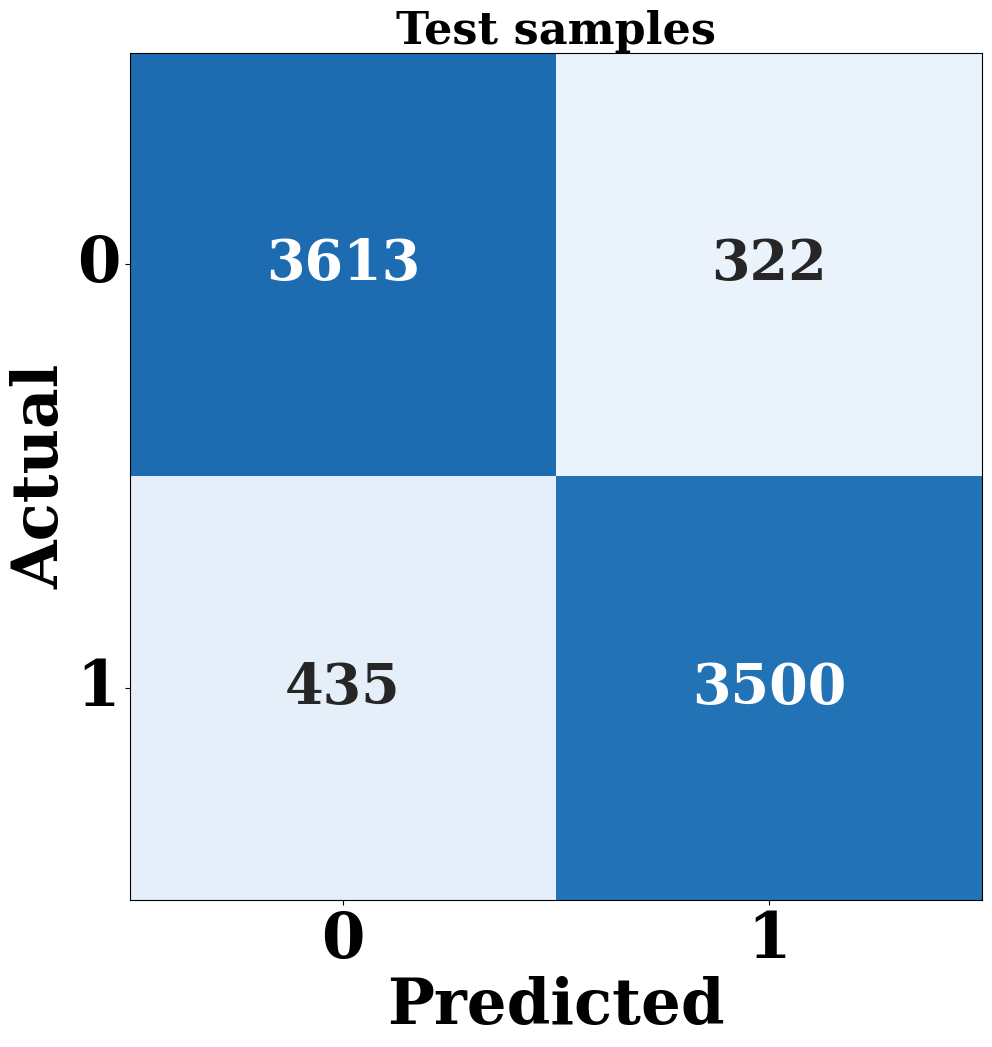

In [14]:
(test_cm ,  test_GT_0_count, test_GT_1_count, 
test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs),best_prob_threshold )

# plot confusion matrix
cm_datas = [ (test_cm, 'Test', 'Blues')]
Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=best_weight_path)

# Embedding tSNE

In [15]:
features_np = np.concatenate(tSNE_embed_list, axis=0)
labels_np = torch.concatenate(eval_targets).detach().cpu().numpy()
print(f"Features shape: {features_np.shape}, Labels shape: {labels_np.shape}")

Features shape: (7870, 54), Labels shape: (7870,)


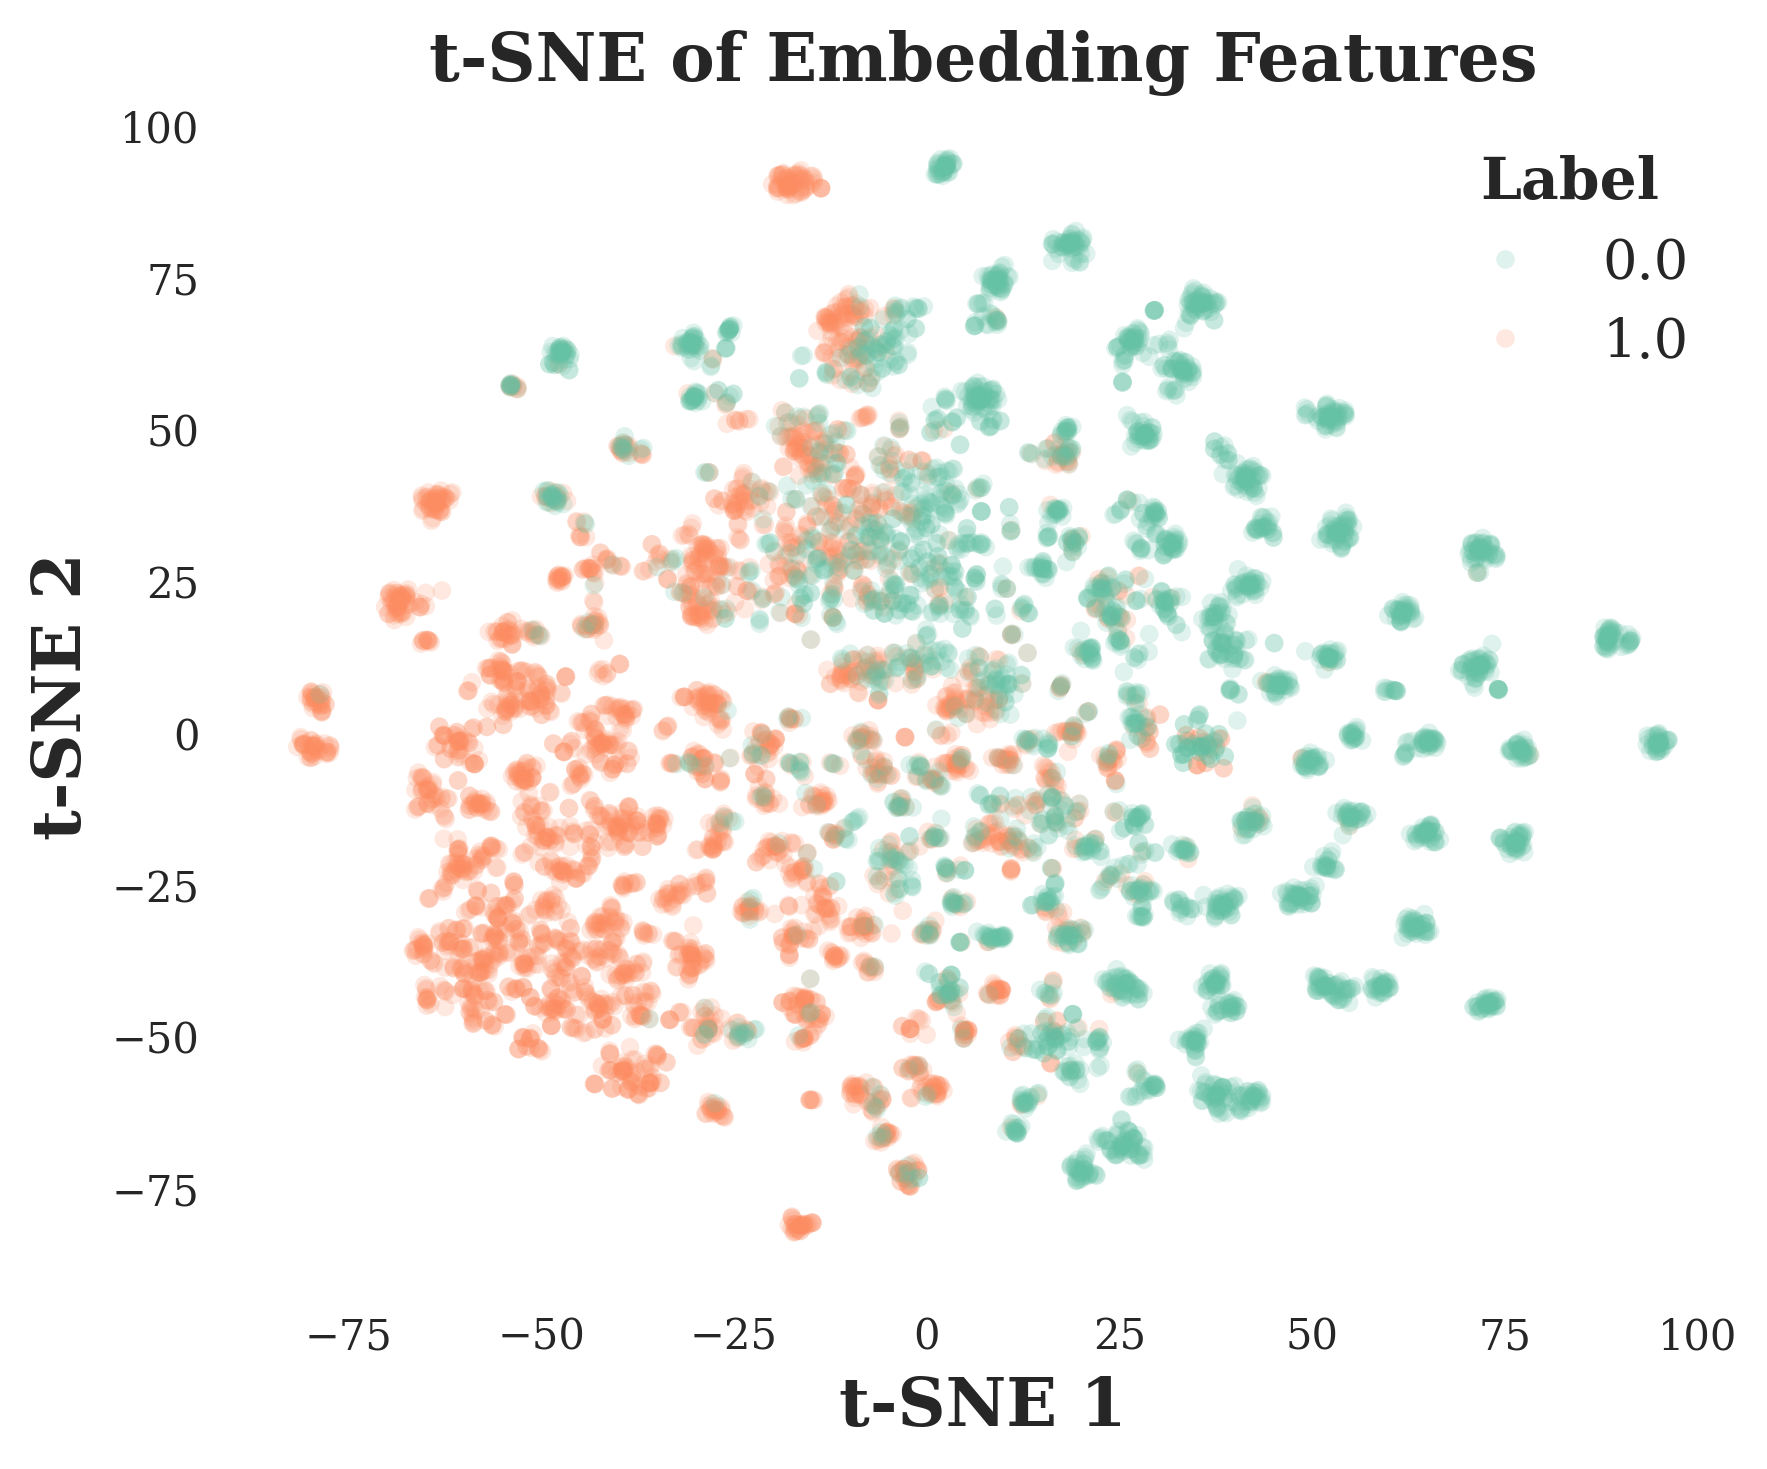

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-v0_8')  # Use default style instead of seaborn
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (10, 10)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"
# 使用 t-SNE 做降維
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
features_2d = tsne.fit_transform(features_np)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=features_2d[:, 0], y=features_2d[:, 1],
    hue=labels_np,
    palette='Set2', s=20,  # Changed from 50 to 20 for smaller bubbles, 
    alpha=0.2,  # Changed from 0.8 to 0.5 for more transparency
    edgecolor='none'  # Remove white edges
)
plt.title("t-SNE of Embedding Features", fontsize=16,fontweight="bold")
plt.xlabel("t-SNE 1", fontsize=16,fontweight="bold")
plt.ylabel("t-SNE 2", fontsize=16,fontweight="bold")
leg = plt.legend(title="Label", fontsize=13, title_fontsize=14) # Label1:sensitive, Label0:resistant
plt.setp(leg.get_title(), weight='bold')
plt.tight_layout()
plt.show()

# 

In [17]:
print(np.concatenate(predAUCwithUnknownGT).shape)
print(test_df.shape)
test_df['predict_value'] = np.concatenate(predAUCwithUnknownGT)
test_df 

(7870,)
(7870, 14)


COSMIC_ID CELL_LINE_NAME primary_disease  DRUG_ID  \
46167     909742       SU-DHL-1    UNCLASSIFIED     1911   
7042      949090         Caov-4              OV     1941   
26240     910861             RL            DLBC     1911   
19615     688013       NCI-H209            SCLC     1494   
19726     688013       NCI-H209            SCLC     1817   
...          ...            ...             ...      ...   
39088     910910       UACC-812            BRCA     2499   
8302     1240218         SU8686            PAAD     2499   
24049     910689       COLO-678          COREAD     2439   
14310     906826        CAL-120            BRCA     2499   
24044     910689       COLO-678          COREAD     2499   

                  drug_name             PUTATIVE_TARGET  \
46167          Dactinomycin              RNA polymerase   
7042   Sepantronium bromide                       BIRC5   
26240          Dactinomycin              RNA polymerase   
19615                 SN-38                        TOP1   
19726            Romidepsin  HDAC1, HDAC2, HDAC3, HDAC8   
...                     ...                         ...   
39088     N-acetyl cysteine                  Metabolism   
8302      N-acetyl cysteine                  Metabolism   
24049           glutathione       anti-oxidant proteins   
14310     N-acetyl cysteine                  Metabolism   
24044     N-acetyl cysteine                  Metabolism   

                        PATHWAY_NAME  MAX_CONC(μM)     lnIC50       AUC  \
46167                          Other          0.80  -7.617658  0.077661   
7042            Apoptosis regulation         10.00  -7.310776  0.040197   
26240                          Other          0.80  -7.113407  0.110082   
19615                DNA replication          0.01  -7.077823  0.629519   
19726  Chromatin histone acetylation          0.01  -7.071202  0.630374   
...                              ...           ...        ...       ...   
39088                     Metabolism       2000.00  11.504569  0.981980   
8302                      Metabolism       2000.00  11.732421  0.976413   
24049                          Other        640.00  12.125419  0.967474   
14310                     Metabolism       2000.00  12.215060  0.964582   
24044                     Metabolism       2000.00  12.457217  0.955791   

       Label     ModelID drug_name_normalized           mapped_name  \
46167      1  ACH-000664         dactinomycin          dactinomycin   
7042       1  ACH-000103  sepantroniumbromide  sepantronium bromide   
26240      1  ACH-000371         dactinomycin          dactinomycin   
19615      1  ACH-000290                 sn38                 sn-38   
19726      1  ACH-000290           romidepsin            Romidepsin   
...      ...         ...                  ...                   ...   
39088      0  ACH-000568      nacetylcysteine     N-acetyl cysteine   
8302       0  ACH-000114      nacetylcysteine     N-acetyl cysteine   
24049      0  ACH-000350          glutathione           glutathione   
14310      0  ACH-000212      nacetylcysteine     N-acetyl cysteine   
24044      0  ACH-000350      nacetylcysteine     N-acetyl cysteine   

       predict_value  
46167       0.957763  
7042        0.999030  
26240       0.967787  
19615       0.994509  
19726       0.999624  
...              ...  
39088       0.002805  
8302        0.001323  
24049       0.001957  
14310       0.001715  
24044       0.000450  

[7870 rows x 15 columns]

## inference on CCL all dataset(train+val+test) to see perfoemance by cancerType

In [18]:
%%time
# inference
set_seed(seed)
def collate_fn(batch):
        gene_feature, drug_list, target = zip(*batch)
        return list(gene_feature), list(drug_list), list(target)
all_dataset = InstanceResponseDataset(AUC_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn) #, num_workers=4, pin_memory=True

(eval_targets, eval_outputs,predAUCwithUnknownGT, 
AttenScorMat_DrugSelf,AttenScorMat_DrugCellSelf,
eval_outputs_before_final_activation_list,  tSNE_embed_list,
 mean_batch_eval_loss_WO_penalty)= evaluation(model, None,None,
                                             criterion, all_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')

CPU times: user 6.34 s, sys: 55.9 ms, total: 6.39 s
Wall time: 6.39 s


In [19]:
print(np.concatenate(predAUCwithUnknownGT).shape)
print(torch.cat(eval_outputs).shape)
print(torch.cat(eval_targets).shape)

(78920,)
torch.Size([78920])
torch.Size([78920])


In [20]:
best_prob_threshold

0.53332370519638

In [21]:
print(torch.cat(eval_outputs)[:10])
print(torch.cat(eval_targets)[:10])

tensor([0.9987, 0.0345, 0.9931, 0.3519, 0.0061, 0.8711, 0.8305, 0.9643, 0.9886,
        0.9851], device='cuda:0')
tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 1.], device='cuda:0')


In [22]:
print(np.concatenate(predAUCwithUnknownGT).shape)
AUC_df = AUC_df.copy() 
# predAUCmatrix = predAUCwithUnknownGT_list.reshape(476, 1440) # numpy.ndarray
AUC_df['predict_value'] = np.concatenate(predAUCwithUnknownGT)
AUC_df

(78920,)


COSMIC_ID CELL_LINE_NAME primary_disease  DRUG_ID          drug_name  \
50        905933        OVCAR-3              OV     1843             LMP744   
79        905933        OVCAR-3              OV     1373         Dabrafenib   
73        905933        OVCAR-3              OV     2148             POMHEX   
34        905933        OVCAR-3              OV     1052            RO-3306   
1         905933        OVCAR-3              OV     2499  N-acetyl cysteine   
...          ...            ...             ...      ...                ...   
78718     909252         p30ohk             ALL     1010          Gefitinib   
78726     909252         p30ohk             ALL     1918            AZD8186   
78722     909252         p30ohk             ALL     1720            AZD5991   
78861     909252         p30ohk             ALL     1706            AZD5153   
78858     909252         p30ohk             ALL     1048              Mirin   

           PUTATIVE_TARGET          PATHWAY_NAME  MAX_CONC(μM)     lnIC50  \
50                    TOP1       DNA replication           3.0   0.812172   
79                    BRAF    ERK MAPK signaling          10.0   5.595749   
73                     NaN          Unclassified          10.0   1.329852   
34                    CDK1            Cell cycle          10.0   5.700996   
1               Metabolism            Metabolism        2000.0  10.423511   
...                    ...                   ...           ...        ...   
78718                 EGFR        EGFR signaling           2.0   2.355511   
78726  PI3Kalpha, PI3Kbeta   PI3K/MTOR signaling          10.0   2.104089   
78722                 MCL1  Apoptosis regulation          10.0   0.228031   
78861                 BRD4       Chromatin other          10.0  -1.677125   
78858                MRE11      Genome integrity         100.0   4.117406   

            AUC  Label     ModelID drug_name_normalized        mapped_name  \
50     0.850384      1  ACH-000001               lmp744             LMP744   
79     0.986309      0  ACH-000001           dabrafenib         dabrafenib   
73     0.789574      1  ACH-000001               pomhex             POMHEX   
34     0.987351      0  ACH-000001               ro3306            ro-3306   
1      0.980557      0  ACH-000001      nacetylcysteine  N-acetyl cysteine   
...         ...    ...         ...                  ...                ...   
78718  0.990040      0  ACH-002059            gefitinib          gefitinib   
78726  0.912210      1  ACH-002059              azd8186            azd8186   
78722  0.694040      1  ACH-002059              azd5991            azd5991   
78861  0.425209      1  ACH-002059              azd5153            azd5153   
78858  0.886406      1  ACH-002059                mirin              mirin   

       predict_value  
50          0.998733  
79          0.034514  
73          0.993084  
34          0.351865  
1           0.006082  
...              ...  
78718       0.024012  
78726       0.244527  
78722       0.655099  
78861       0.933227  
78858       0.875706  

[78920 rows x 15 columns]

/tmp/ipykernel_111395/1191639789.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bce_by_cancer, x='primary_disease', y='Mean_BCE', palette='coolwarm')


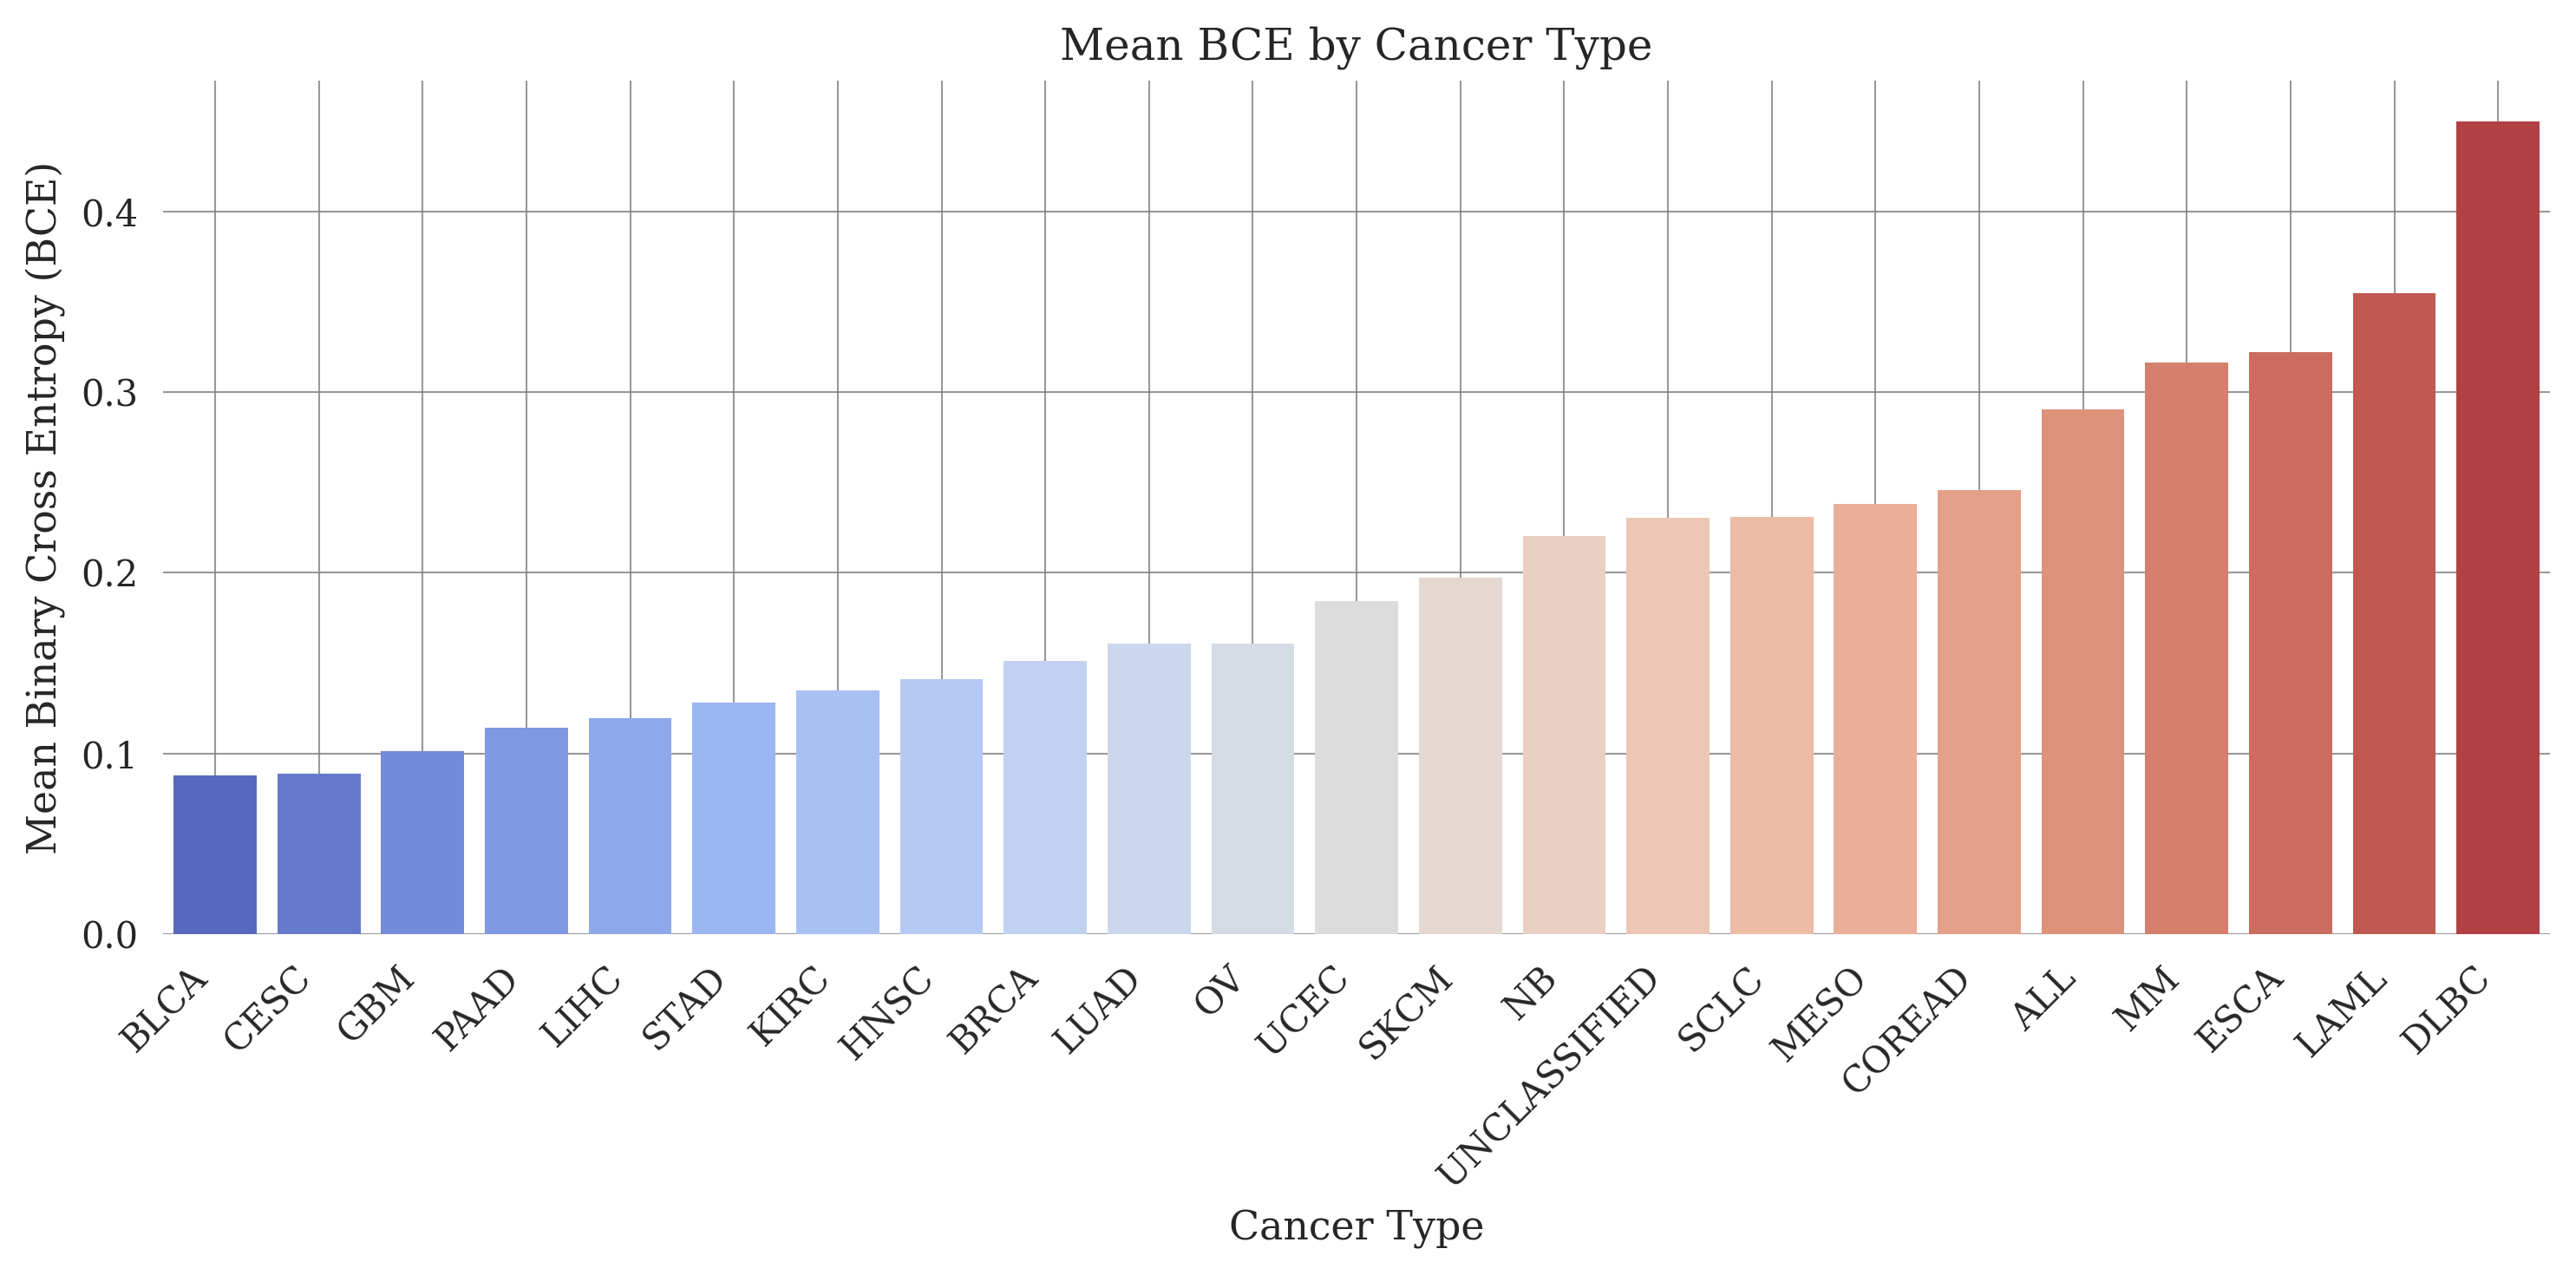

In [23]:
from sklearn.metrics import log_loss
# 先過濾掉缺失值（保險起見）
response_df = test_df.dropna(subset=['primary_disease', 'Label', 'predict_value'])
# 計算每個 primary_disease 的 mean BCE
bce_by_cancer = (
    response_df
    .groupby('primary_disease')
    .apply(lambda df: log_loss(df['Label'], df['predict_value'], labels=[0, 1]))
    .reset_index(name='Mean_BCE')
    .sort_values(by='Mean_BCE')
)
import matplotlib.font_manager as fm
import matplotlib as mpl
plt.style.use('seaborn-v0_8') # Better default style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (8, 5)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"

plt.figure(figsize=(10, 5))
sns.barplot(data=bce_by_cancer, x='primary_disease', y='Mean_BCE', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Binary Cross Entropy (BCE)")
plt.xlabel("Cancer Type")
plt.title("Mean BCE by Cancer Type")
plt.tight_layout()
plt.grid(True, linestyle='-', color='gray', linewidth=0.5, alpha=0.8)

plt.savefig('./results/Mean BCE by Cancer Type (Bar).png', format='png', dpi=300) 
plt.show()

In [24]:
# 計算Cell lines各個Cancer Type的metrics
cancerType_metrics={}
for cancerType in test_df["primary_disease"].unique().tolist():
    cancerType_metrics[cancerType], _  = metrics_calculator(torch.tensor(test_df[test_df["primary_disease"] == cancerType]['Label'].values), 
                                                      torch.tensor(test_df[test_df["primary_disease"] == cancerType]['predict_value'].values), 
                                                      best_prob_threshold, metric, dataset="test")
ccl_test_cancerType_perform= pd.DataFrame(cancerType_metrics).T.map(lambda x: x.item() if hasattr(x, 'item') else x)
# Sort by AUPRC first, then by AUROC
ccl_test_cancerType_perform.sort_values(['AUPRC', 'AUROC'], ascending=[False, False])

Accuracy     AUROC     AUPRC  Sensitivity  Specificity  \
BLCA          0.964789  0.999802  0.999804     0.929577     1.000000   
CESC          0.975248  0.997647  0.997745     0.980198     0.970297   
LIHC          0.954545  0.996327  0.996266     1.000000     0.909091   
GBM           0.972393  0.994731  0.995246     0.969325     0.975460   
PAAD          0.952381  0.992301  0.993036     0.947090     0.957672   
STAD          0.945312  0.991699  0.992017     0.906250     0.984375   
HNSC          0.933333  0.988209  0.989583     0.921212     0.945455   
BRCA          0.944245  0.986905  0.988421     0.946043     0.942446   
OV            0.934066  0.985026  0.985874     0.934066     0.934066   
LUAD          0.930233  0.984451  0.985873     0.889535     0.970930   
KIRC          0.956522  0.986767  0.985374     0.956522     0.956522   
UCEC          0.919192  0.979390  0.980316     0.888889     0.949495   
NB            0.921053  0.970049  0.974967     0.921053     0.921053   
SKCM          0.922705  0.977246  0.971578     0.927536     0.917874   
SCLC          0.902516  0.966694  0.970254     0.877358     0.927673   
UNCLASSIFIED  0.893855  0.967743  0.968421     0.869274     0.918436   
COREAD        0.894737  0.963408  0.966855     0.877193     0.912281   
MESO          0.891892  0.970051  0.965477     0.810811     0.972973   
ALL           0.877273  0.950537  0.954979     0.890909     0.863636   
ESCA          0.889831  0.949153  0.950291     0.898305     0.881356   
MM            0.859551  0.947229  0.947407     0.797753     0.921348   
LAML          0.841463  0.922665  0.918612     0.859756     0.823171   
DLBC          0.797222  0.891690  0.898606     0.783333     0.811111   

              Precision        F1    Youden  F1_RecSpe  F1_RecSpePre  \
BLCA           1.000000  0.963504  0.929577   0.963504      0.951923   
CESC           0.970588  0.975369  0.950495   0.975222      0.948049   
LIHC           0.916667  0.956522  0.909091   0.952381      0.884718   
GBM            0.975309  0.972308  0.944785   0.972383      0.947426   
PAAD           0.957219  0.952128  0.904762   0.952352      0.910068   
STAD           0.983051  0.943089  0.890625   0.943698      0.915520   
HNSC           0.944099  0.932515  0.866667   0.933176      0.877636   
BRCA           0.942652  0.944345  0.888489   0.944241      0.890592   
OV             0.934066  0.934066  0.868132   0.934066      0.872479   
LUAD           0.968354  0.927273  0.860465   0.928452      0.886955   
KIRC           0.956522  0.956522  0.913043   0.956522      0.914934   
UCEC           0.946237  0.916667  0.838384   0.918193      0.860390   
NB             0.921053  0.921053  0.842105   0.921053      0.848338   
SKCM           0.918660  0.923077  0.845411   0.922680      0.848870   
SCLC           0.923841  0.900000  0.805032   0.901814      0.826623   
UNCLASSIFIED   0.914219  0.891180  0.787709   0.893179      0.810406   
COREAD         0.909091  0.892857  0.789474   0.894393      0.808759   
MESO           0.967742  0.882353  0.783784   0.884521      0.832391   
ALL            0.867257  0.878924  0.754545   0.877061      0.763543   
ESCA           0.883333  0.890756  0.779661   0.889750      0.787863   
MM             0.910256  0.850299  0.719101   0.855108      0.763357   
LAML           0.829412  0.844311  0.682927   0.841066      0.700936   
DLBC           0.805714  0.794366  0.594445   0.796980      0.639866   

              Best_Threshold  
BLCA                0.533324  
CESC                0.533324  
LIHC                0.533324  
GBM                 0.533324  
PAAD                0.533324  
STAD                0.533324  
HNSC                0.533324  
BRCA                0.533324  
OV                  0.533324  
LUAD                0.533324  
KIRC                0.533324  
UCEC                0.533324  
NB                  0.533324  
SKCM                0.533324  
SCLC                0.533324  
UNCLASSIFIED        0.533324  
COREAD              0.533324 

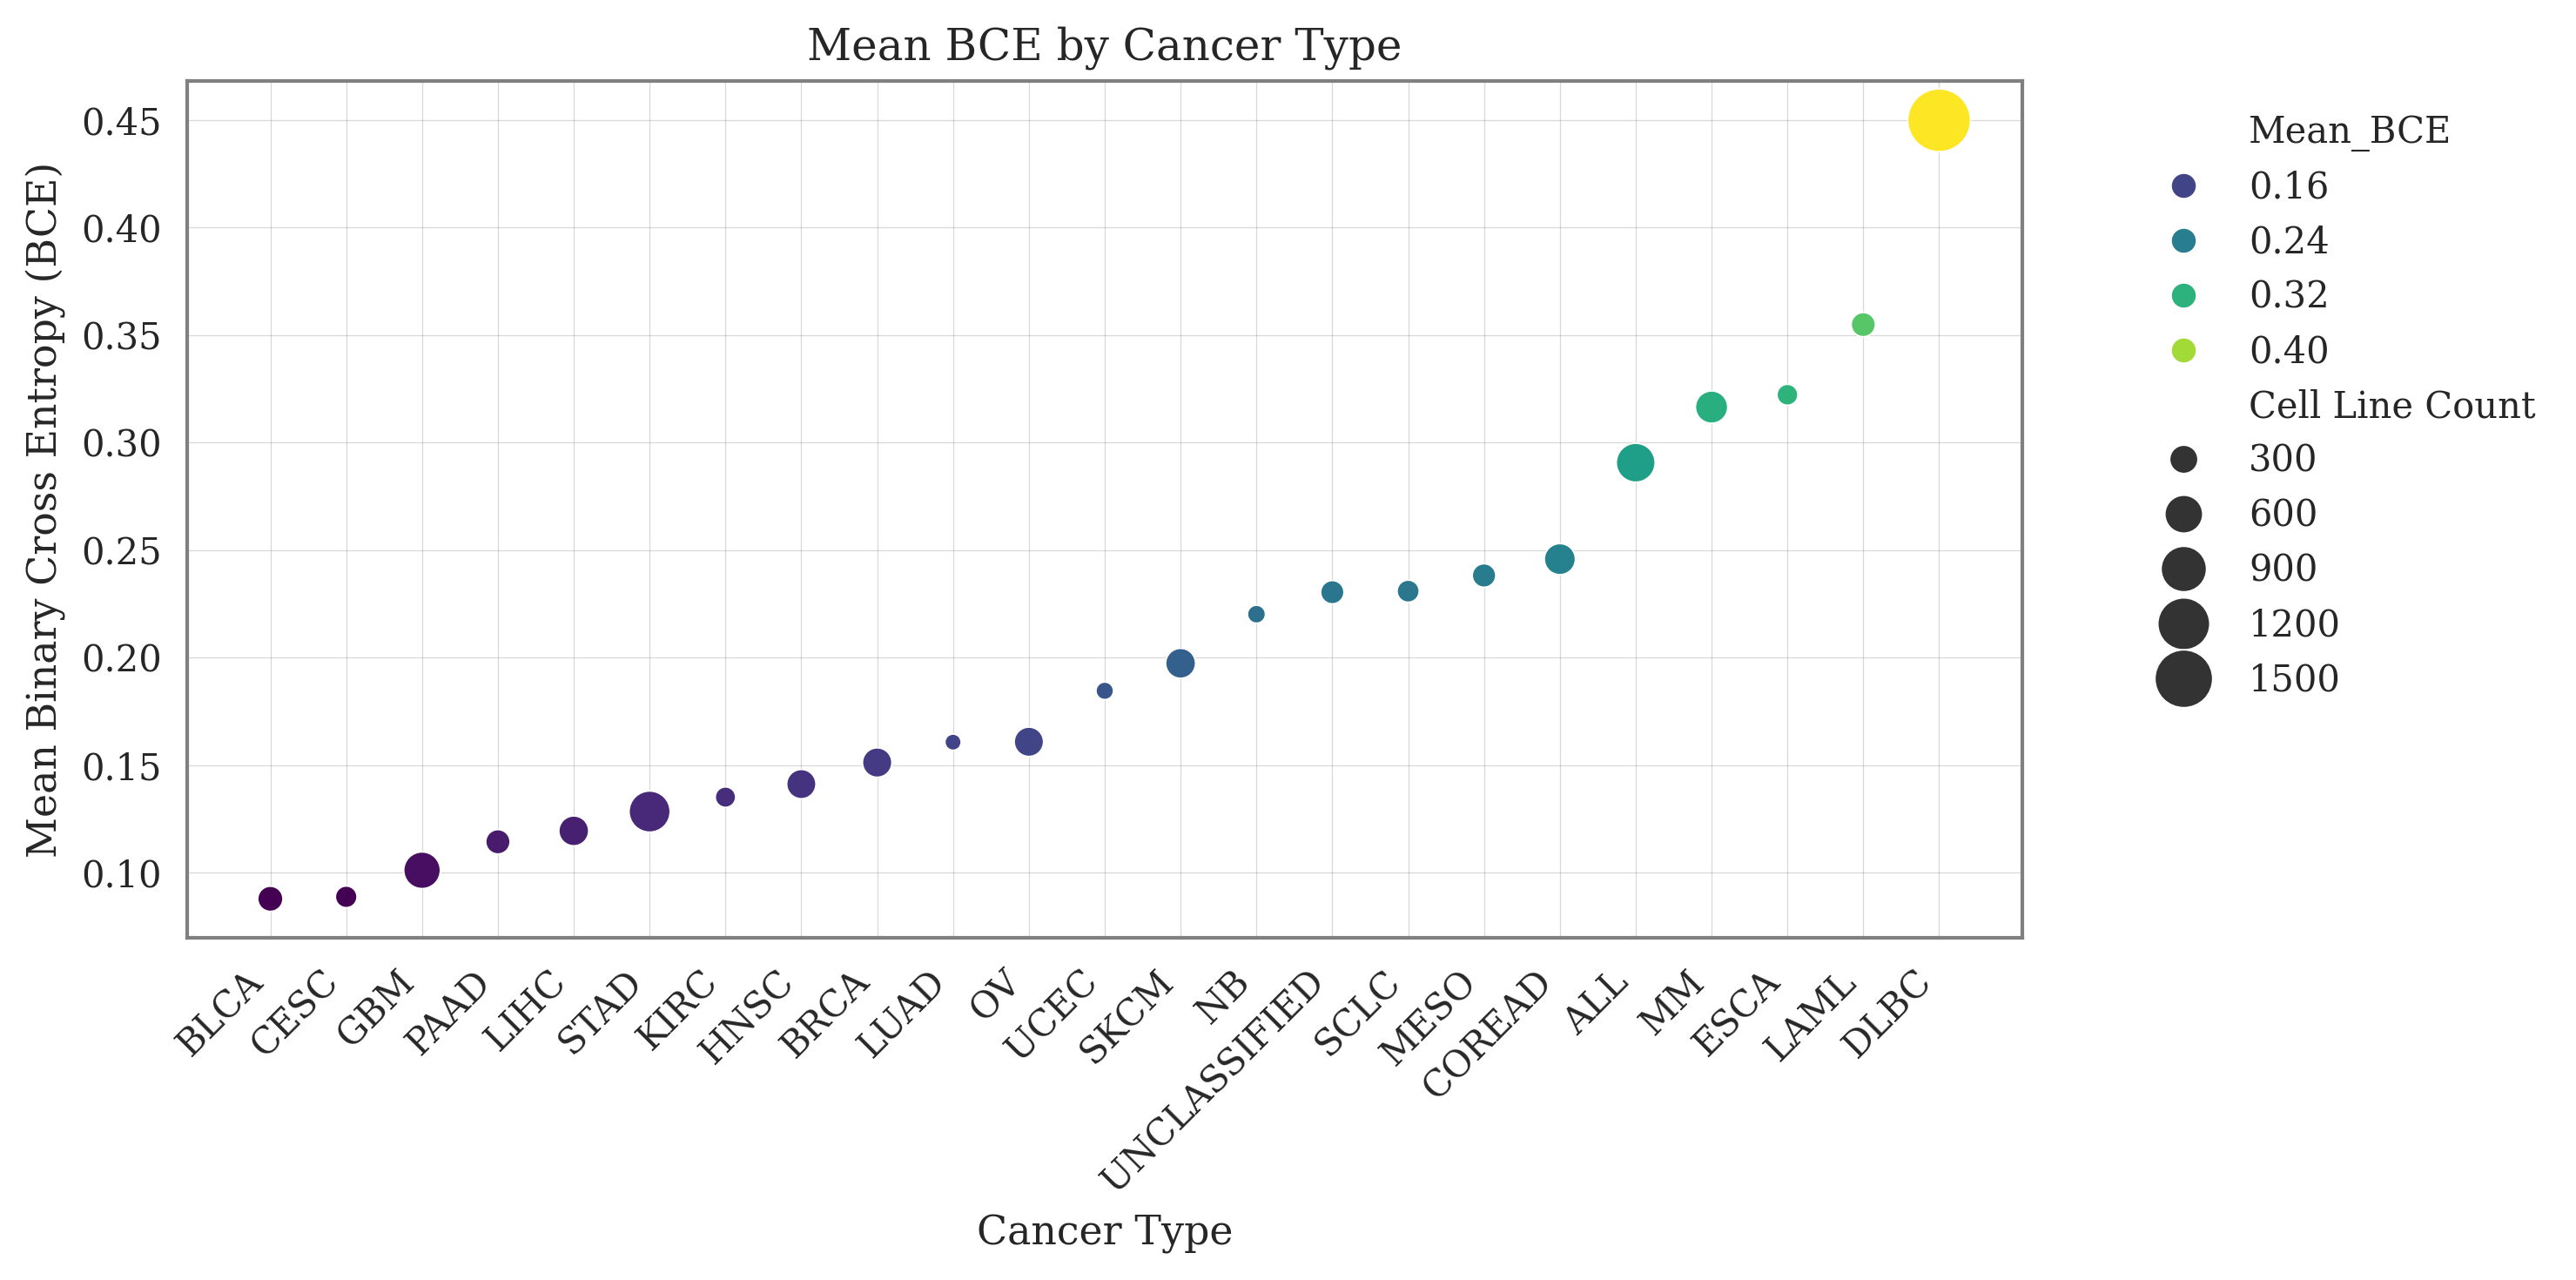

In [25]:
import matplotlib.font_manager as fm
import matplotlib as mpl
plt.style.use('seaborn-v0_8') # Better default style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (8, 5)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"

bce_by_cancer['Cell Line Count'] = response_df.groupby('primary_disease').size().values
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=bce_by_cancer, x='primary_disease', y='Mean_BCE',
    size='Cell Line Count', sizes=(20, 300), hue='Mean_BCE', palette='viridis', legend='brief')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Binary Cross Entropy (BCE)")
plt.xlabel("Cancer Type")
plt.title("Mean BCE by Cancer Type")
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
for spine in plt.gca().spines.values():
    spine.set_color('gray')  
    spine.set_linewidth(1)
plt.savefig('./results/Mean BCE by Cancer Type (Bubble)in testset.png', format='png', dpi=300) 
plt.show()

In [26]:
test_df.shape

(7870, 15)

In [27]:
from scipy.stats import pearsonr, spearmanr
# 建立結果列表
corr_list = []
# 分組處理每個 ModelID
for model_id, group in test_df.groupby('ModelID'):
    if group['Label'].nunique() > 1:
        pearson_corr, _ = pearsonr(group['predict_value'], group['Label'])
        spearman_corr, _ = spearmanr(group['predict_value'], group['Label'])
    else:
        pearson_corr, spearman_corr = None, None
    corr_list.append({'ModelID': model_id, 'PearsonCorr': pearson_corr, 'SpearmanCorr': spearman_corr})
# 轉為 DataFrame
correlation_df = pd.DataFrame(corr_list)

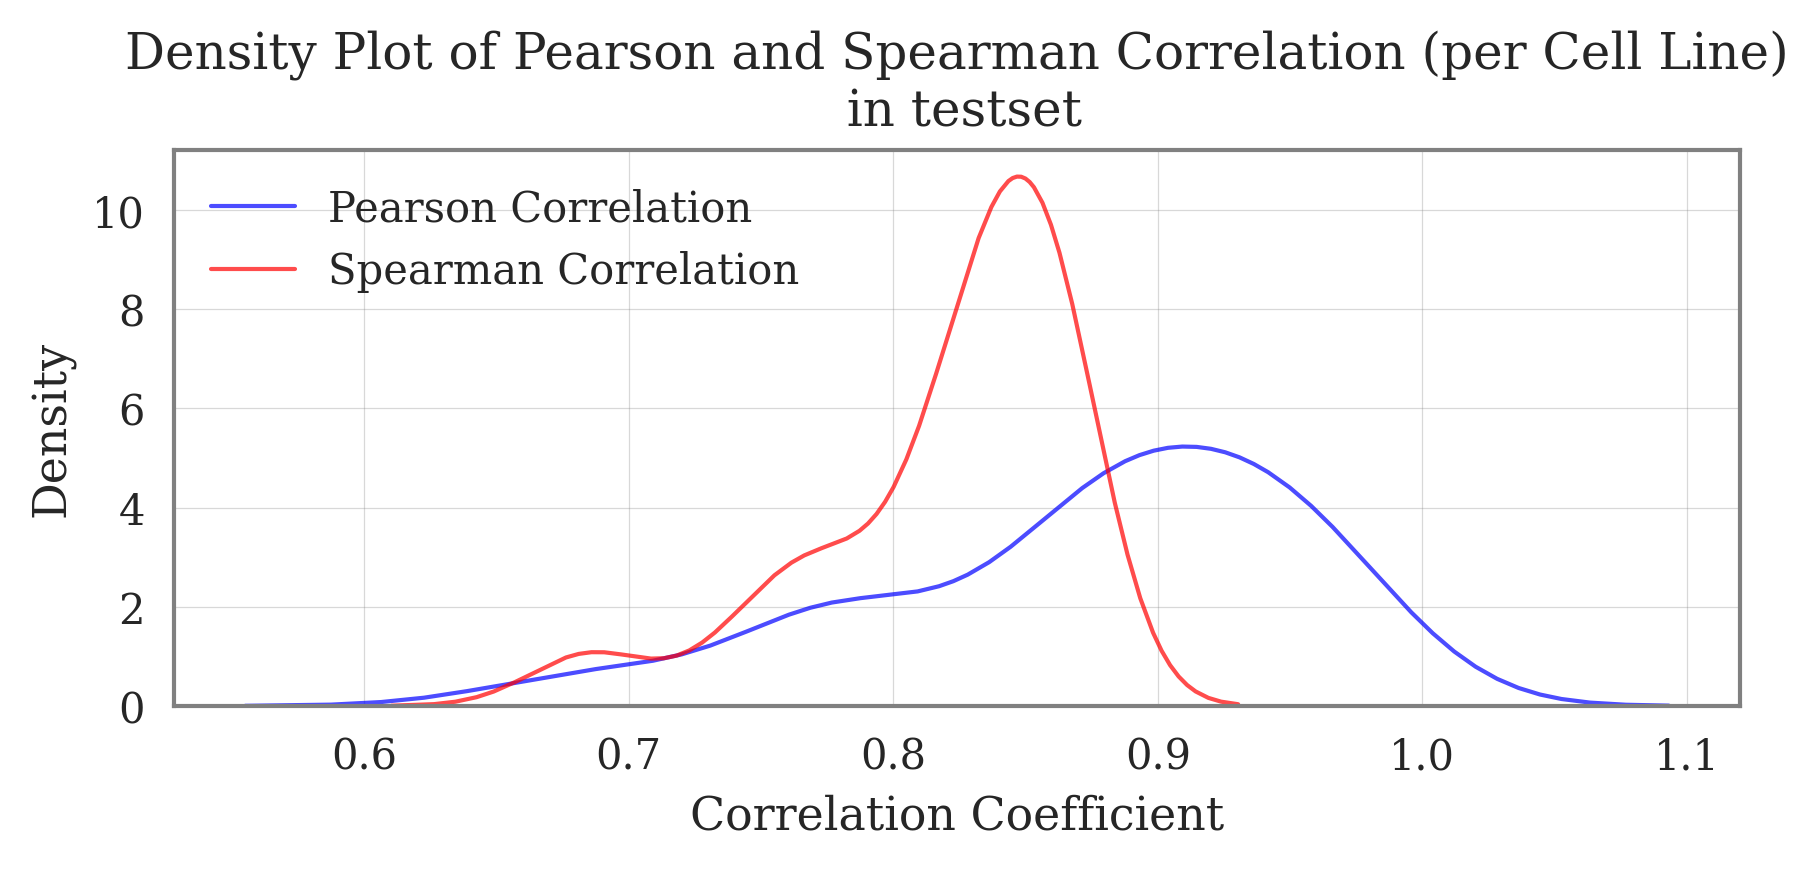

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
valid_corr_df = correlation_df.dropna(subset=['PearsonCorr', 'SpearmanCorr'])# 去除空值（None 或 NaN）
# 繪製 density plot
plt.figure(figsize=(6, 3))
sns.kdeplot(valid_corr_df['PearsonCorr'], label='Pearson Correlation',color='blue', linewidth=1,alpha=0.7 )
sns.kdeplot(valid_corr_df['SpearmanCorr'], label='Spearman Correlation',color='red', linewidth=1,alpha=0.7)

plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Density Plot of Pearson and Spearman Correlation (per Cell Line)\n in testset')
plt.legend(loc='upper left')
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
    spine.set_color('gray')      # Set spine color to gray
    spine.set_linewidth(1)
plt.tight_layout()
plt.savefig('./results/Correlation Dendity plot per cell line in testset.png', format='png', dpi=300) 
plt.show()

In [29]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd
correlation_info = []# 儲存結果
# 分群處理
for model_id, group in test_df.groupby('ModelID'):
    if len(group['predict_value'].unique()) > 1 and len(group['Label'].unique()) > 1:
        pearson_corr, _ = pearsonr(group['predict_value'], group['Label'])
        spearman_corr, _ = spearmanr(group['predict_value'], group['Label'])
    else:
        pearson_corr, spearman_corr = float('nan'), float('nan')
    
    cancer_type = group['primary_disease'].iloc[0]
    correlation_info.append({ 'ModelID': model_id,  'primary_disease': cancer_type,
                          'PearsonCorr': pearson_corr,'SpearmanCorr': spearman_corr    })
# 建立 DataFrame
correlation_df = pd.DataFrame(correlation_info)
# 篩選低相關（例如 Pearson < 0.2）
low_corr_df = correlation_df[correlation_df['PearsonCorr'] < 0.2]
# 查看這些 ModelID 屬於哪些 primary_disease
low_corr_counts = low_corr_df['primary_disease'].value_counts()
print(low_corr_counts)

Series([], Name: count, dtype: int64)


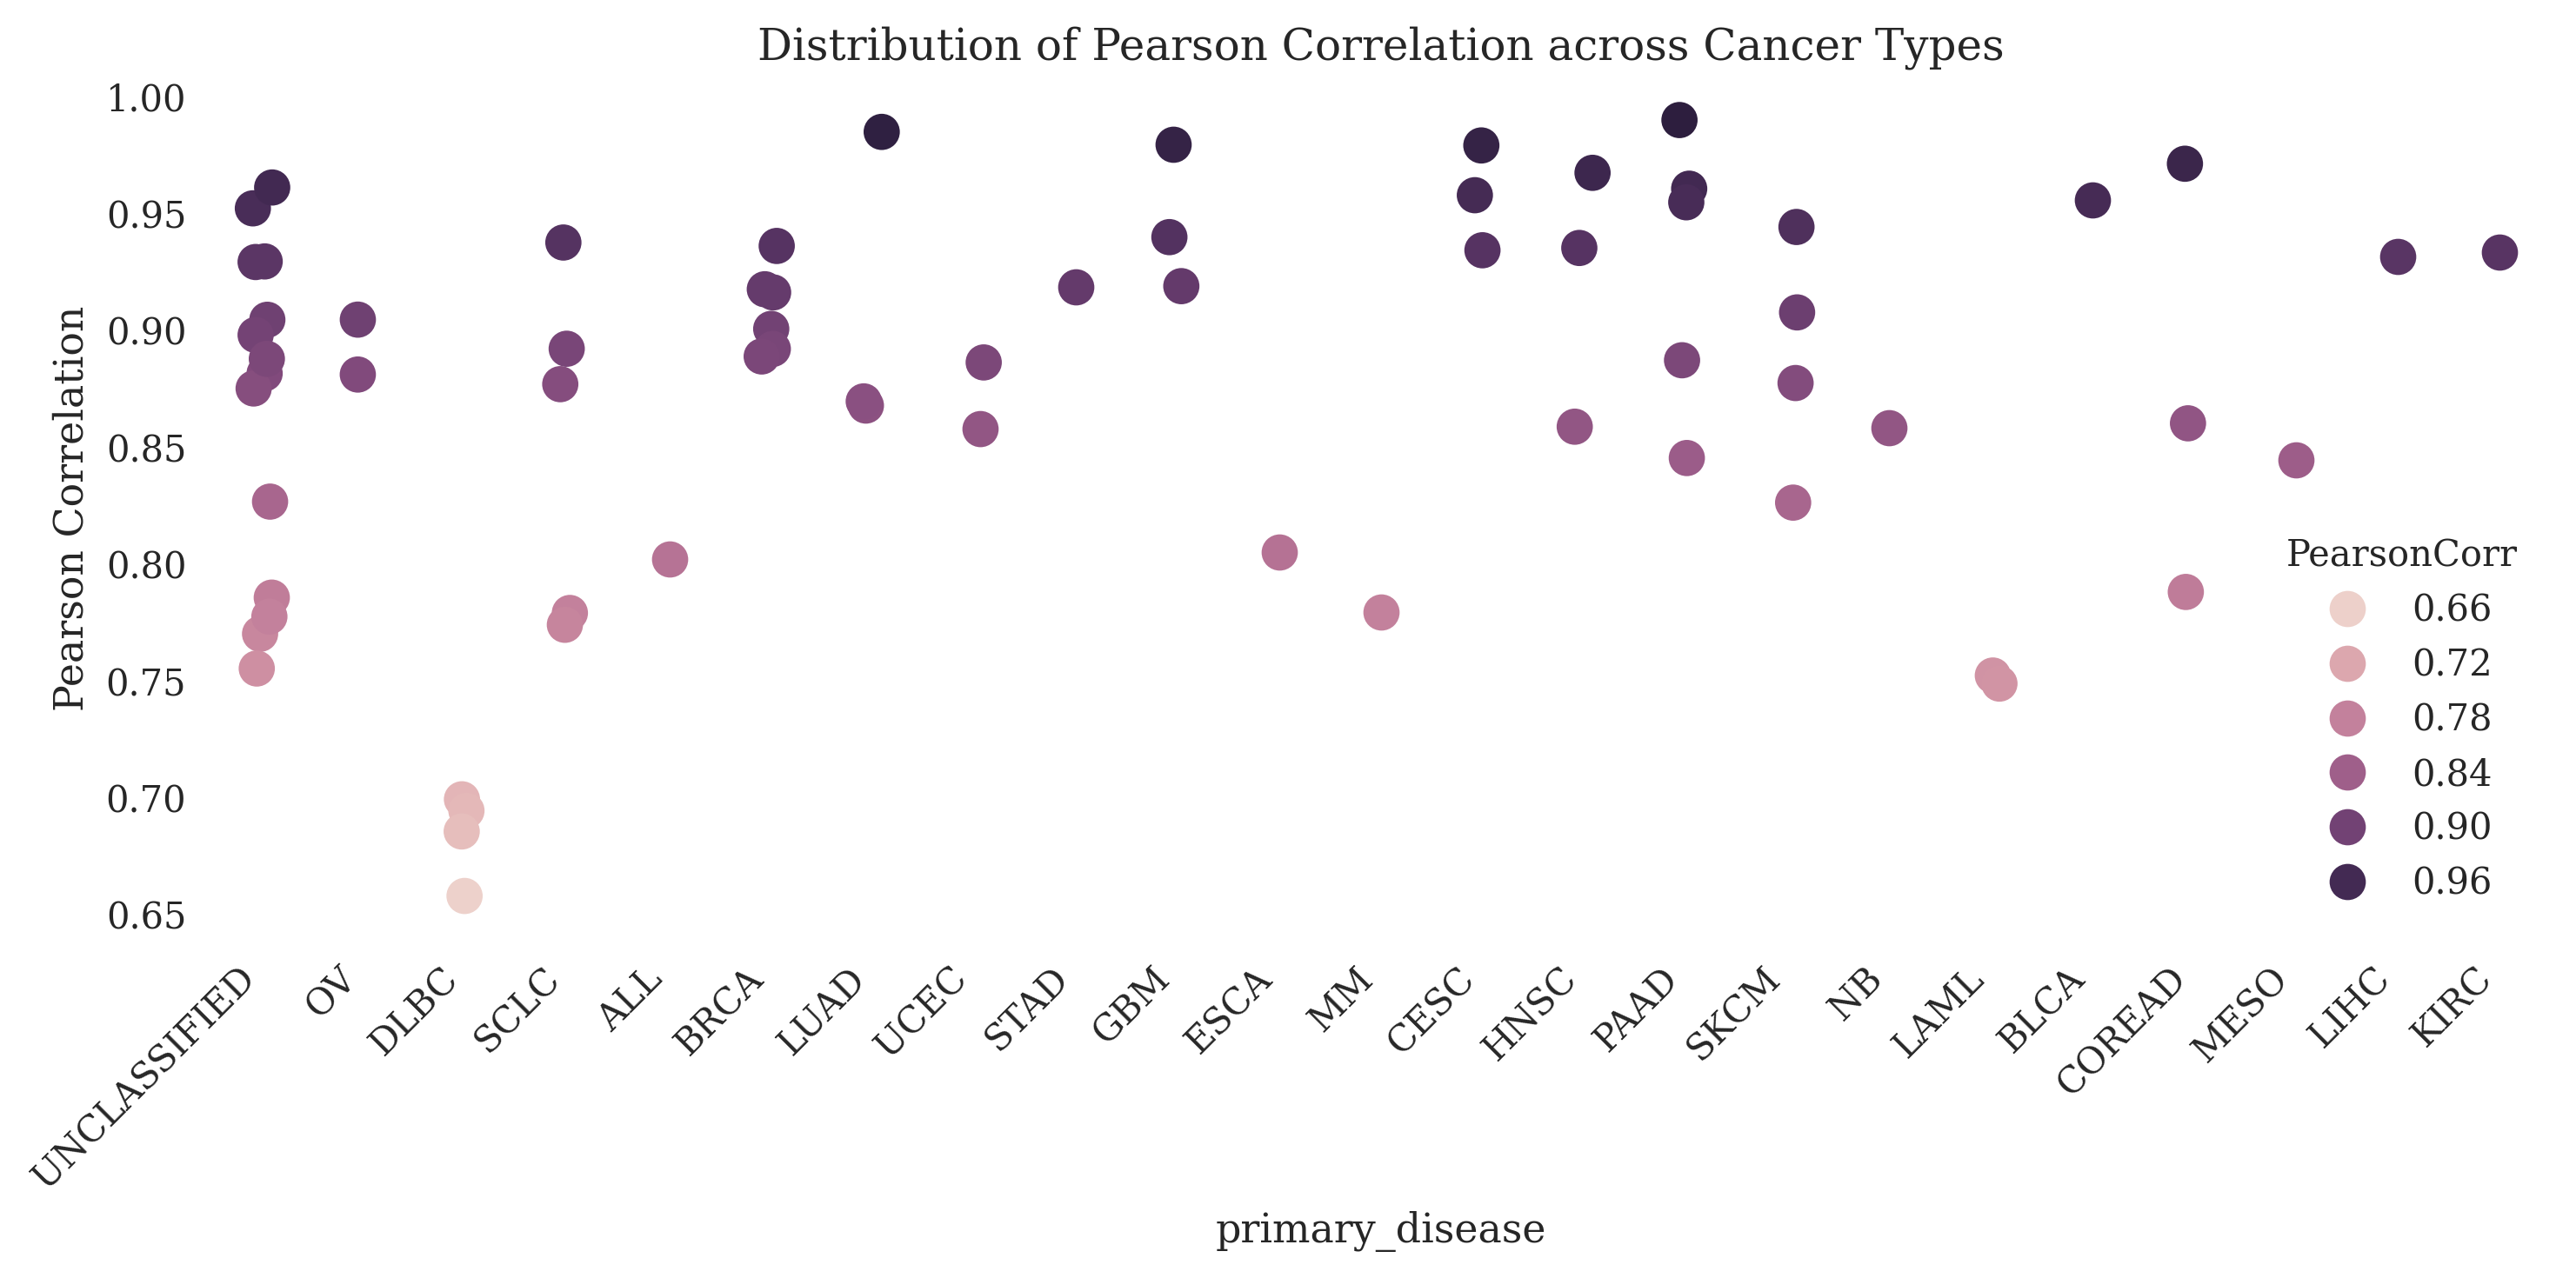

In [30]:
corr_plot_df = test_df[['ModelID', 'primary_disease']].drop_duplicates().copy()
corr_plot_df = corr_plot_df.merge(correlation_df[['ModelID', 'PearsonCorr']], on='ModelID', how='left')
corr_plot_df = corr_plot_df.merge(correlation_df[['ModelID', 'SpearmanCorr']], on='ModelID', how='left')
corr_plot_df
# 繪製 dot plot：primary_disease 為橫軸，correlation 為縱軸
plt.figure(figsize=(10, 5))
sns.stripplot(data=corr_plot_df, x='primary_disease', y='PearsonCorr', jitter=True,size=10, hue ='PearsonCorr')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Pearson Correlation')
plt.title('Distribution of Pearson Correlation across Cancer Types')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

In [44]:
sample_counts = test_df['ModelID'].value_counts().rename('SampleCount')
corr_plot_df = corr_plot_df.merge(sample_counts, left_on='ModelID', right_index=True)
# 排序癌別順序
cancer_order = corr_plot_df['primary_disease'].value_counts().index.tolist()
cancer_to_x = {cancer: i for i, cancer in enumerate(cancer_order)}
x_vals = corr_plot_df['primary_disease'].map(cancer_to_x)
# 畫圖
plt.figure(figsize=(13, 5))
sc = plt.scatter(
    x_vals, corr_plot_df['PearsonCorr'],
    c=corr_plot_df['PearsonCorr'],               # 顏色：以 correlation 上色
    cmap='coolwarm',
    s=corr_plot_df['SampleCount_x']*0.8,          # 大小：樣本數 * 10（可依需求調整）
    alpha=0.7,    edgecolor='k')
plt.colorbar(sc, label='')
plt.xticks(ticks=range(len(cancer_order)), labels=cancer_order, rotation=45, ha='right')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation per Cancer Type in testset (Dot Size = Sample Count)')
plt.tight_layout()
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
for size in [50, 100, 300]:
    plt.scatter([], [], c='gray', alpha=0.6, s=size * 0.8, label=f'{size} samples', edgecolors='k')
plt.legend(
    scatterpoints=1, frameon=True, labelspacing=1, title='Sample Count',
    loc='center left', bbox_to_anchor=(1.12, 0.5), borderaxespad=0)
plt.savefig('./results/Pearson Correlation per Cancer Typ in testset.png', format='png', dpi=300)  # High-res raster
plt.show()

KeyError: 'SampleCount_x'

<Figure size 3900x1500 with 0 Axes>

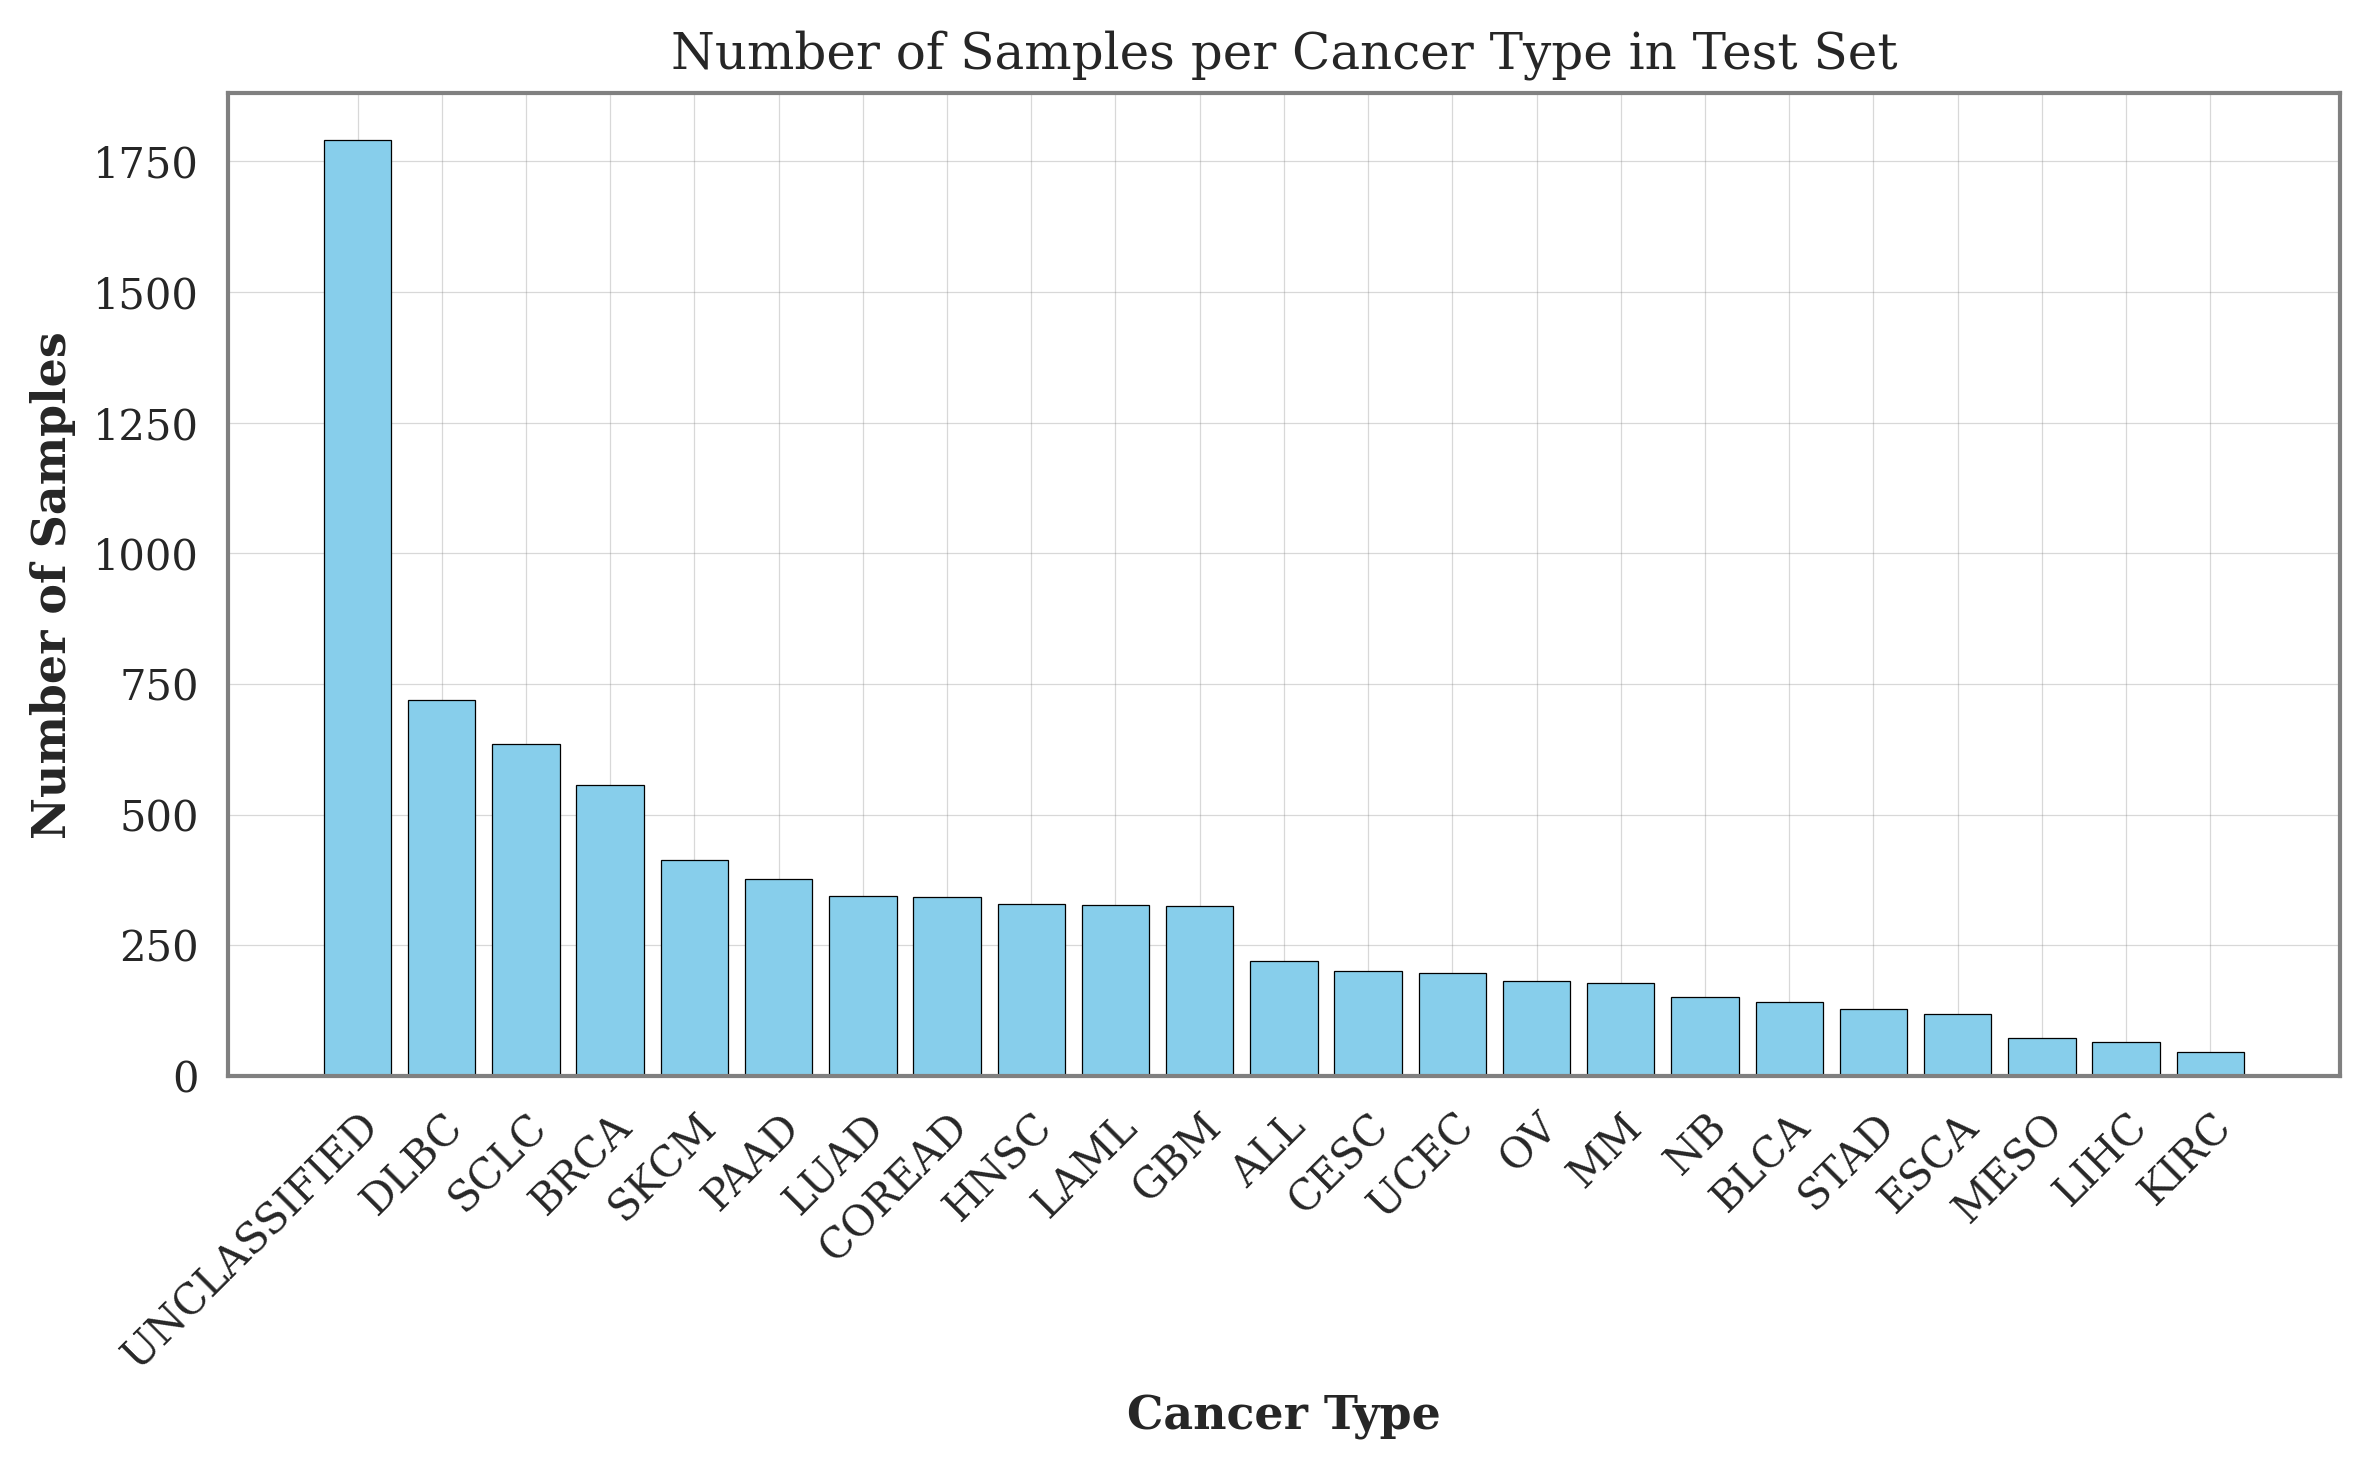

In [31]:
import matplotlib.font_manager as fm
import matplotlib as mpl

# Set up high-quality rendering
plt.style.use('seaborn-v0_8')  # Better default style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (8, 5)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"

cancer_counts = test_df['primary_disease'].value_counts()
cancer_counts_df = cancer_counts.reset_index()
cancer_counts_df.columns = ['primary_disease', 'SampleCount']
# 畫條形圖
plt.figure(figsize=(8, 5))
bars = plt.bar(cancer_counts_df['primary_disease'], cancer_counts_df['SampleCount'], color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Cancer Type', fontweight="bold")
plt.ylabel('Number of Samples', fontweight="bold")
plt.title('Number of Samples per Cancer Type in Test Set')
plt.tight_layout()
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
for spine in plt.gca().spines.values():
    spine.set_color('gray')  
    spine.set_linewidth(1)
plt.show()

In [32]:
test_df['primary_disease'].value_counts().sum()

7870

✅ Set read-only permissions on: ./results/2026-0206-0724_BF3_BCE_test_loss0.2240460_BestValEpo485_filedown_high_Omics_DrugESPF_Model_ModelID_ESPFFalse_DrugSelfAttenFalse_Exp32_nlayer1_DA-VAEwC_1/None-Test Confusion_Matrix.png


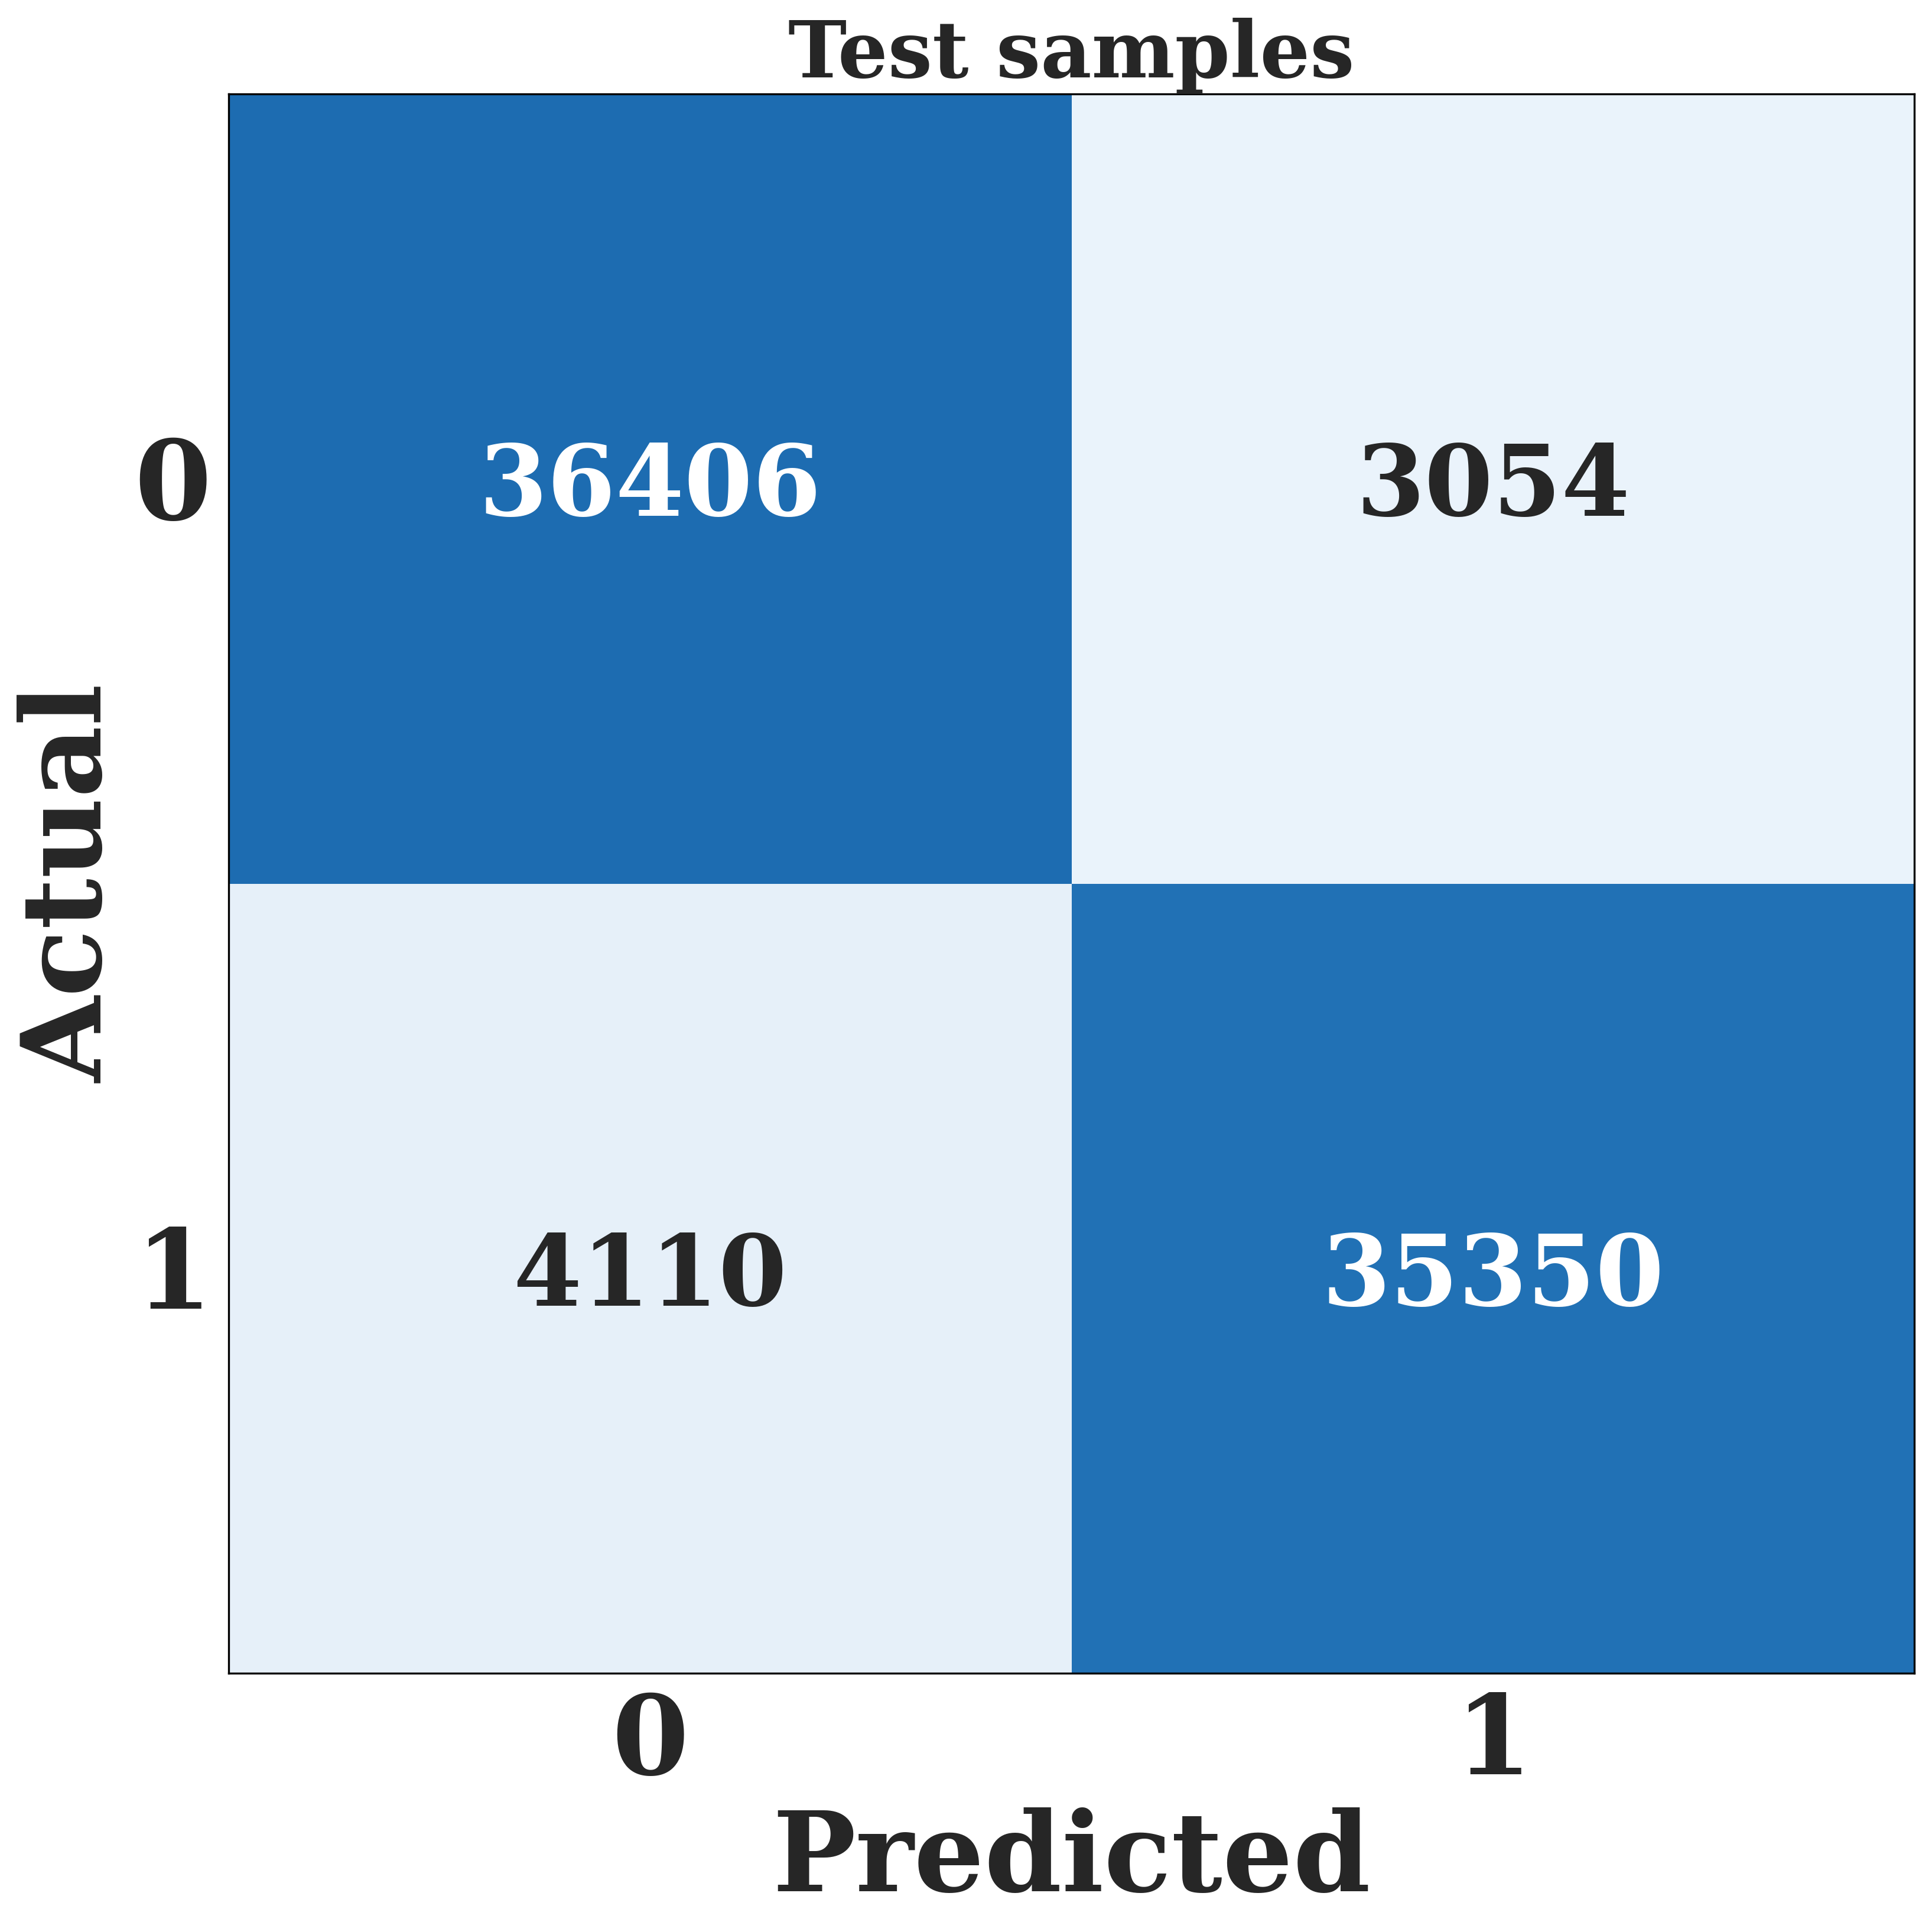

In [33]:
if 'BCE' in criterion.loss_type :
    (test_cm ,  test_GT_0_count, test_GT_1_count, 
    test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs),best_prob_threshold )

    # plot confusion matrix
    cm_datas = [ (test_cm, 'Test', 'Blues')]
    Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=best_weight_path)

In [34]:
def Confusion_Matrix_plot(datasets,hyperparameter_folder_path=None,drug=None):
    plt.rcParams["font.family"] = "serif"
    if len(datasets)==1:
        fig, ax = plt.subplots(figsize=(11,11))
        cm, title, color = datasets[0]
        sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"}, 
                    cmap=color, cbar=False, vmin=0, vmax=max(cm.max() * 1.3, 1), linewidths=0,
                    xticklabels=["0", "1"], yticklabels=["0", "1"], ax=ax) # xticklabels=["Predicted  0", "Predicted  1"], yticklabels=["Actual  0", "Actual  1"]
        if drug is not None:
            ax.set_title(f'{drug}-{title} samples',fontsize=32, fontweight='bold')
        else:
            ax.set_title(f'{title} samples',fontsize=32, fontweight='bold')
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.8)
            spine.set_edgecolor('black')
        # Make x and y tick labels bold
        ax.tick_params(axis='x', labelsize=45, labelrotation=0)
        ax.tick_params(axis='y', labelsize=45, labelrotation=0)
        ax.set_xlabel("Predicted", fontsize=45, fontweight='bold', fontname="serif")
        ax.set_ylabel("Actual", fontsize=45, fontweight='bold', fontname="serif")
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        if hyperparameter_folder_path is not None:
            output_file = os.path.join(hyperparameter_folder_path, f'{drug}-{title} Confusion_Matrix.png')
            try:
                fig.savefig(output_file)
#                 os.chmod(output_file, 0o444)
                print(f"✅ Set read-only permissions on: {output_file}")
            except Exception as e:
                print(f"⚠️ Failed to set permissions: {e}")

# TCGA infernece

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
def tSNE_embed_plot(datasets,hyperparameter_folder_path=None,drug=None):
    plt.rcParams["font.family"] = "serif"
    if len(datasets)==1:
        fig, ax = plt.subplots(figsize=(6,6))
        tSNE_embed_list, eval_targets, title, color = datasets[0]
        features_np = np.concatenate(tSNE_embed_list, axis=0)
        labels_np = torch.concatenate(eval_targets).detach().cpu().numpy()
        print(f"tSNE Embed shape: {features_np.shape}, Labels shape: {labels_np.shape}")
        # 使用 t-SNE 做降維
        tsne = TSNE(n_components=2, random_state=42, perplexity=len(features_np)//3, max_iter=1000)
        features_2d = tsne.fit_transform(features_np)
        sns.scatterplot( x=features_2d[:, 0], y=features_2d[:, 1], hue=labels_np, palette='Set2', s=60, alpha=0.8, ax=ax )
        ax.set_title("t-SNE of Embedding Features", fontsize=16, fontweight="bold")
        ax.set_xlabel("t-SNE 1", fontsize=16, fontweight="bold")
        ax.set_ylabel("t-SNE 2", fontsize=16, fontweight="bold")
        leg = ax.legend(title="Label", fontsize=13, title_fontsize=14)
        plt.setp(leg.get_title(), weight='bold')
        fig.tight_layout()
        if hyperparameter_folder_path is not None:
            output_file = os.path.join(hyperparameter_folder_path, f'{drug}-{title} tSNE_Embedding.png')
            try:
                fig.savefig(output_file)
#                 os.chmod(output_file, 0o444)
                print(f"✅ Set read-only permissions on: {output_file}")
            except Exception as e:
                print(f"⚠️ Failed to set permissions: {e}")
    return plt

## DeepCDR TCGA dataset

In [36]:
paper = 'DiSyn'# 'DeepCDR' DiSyn
label_df_pth = f"../data/TCGA/DiSyn TCGA drug response match exp file samples.csv" # TCGA DeepCDR samples.csv DiSyn TCGA drug response match exp file samples.csv
TCGA_EXP_pth = f"../data/TCGA/TCGA DiSyn samples EXP1426.csv"# TCGA DeepCDR samples EXP1426.csv TCGA DiSyn samples EXP1426.csv

TCGAexp data (817, 32)
label_df data (1240, 5)
Exp num_features 32
(421, 10)
num_ccl,num_drug:  817 421

 MACCS166 is applied 

✅ Set read-only permissions on: ./results/2026-0206-0724_BF3_BCE_test_loss0.2240460_BestValEpo485_filedown_high_Omics_DrugESPF_Model_ModelID_ESPFFalse_DrugSelfAttenFalse_Exp32_nlayer1_DA-VAEwC_1/DiSyn-TCGA Confusion_Matrix.png


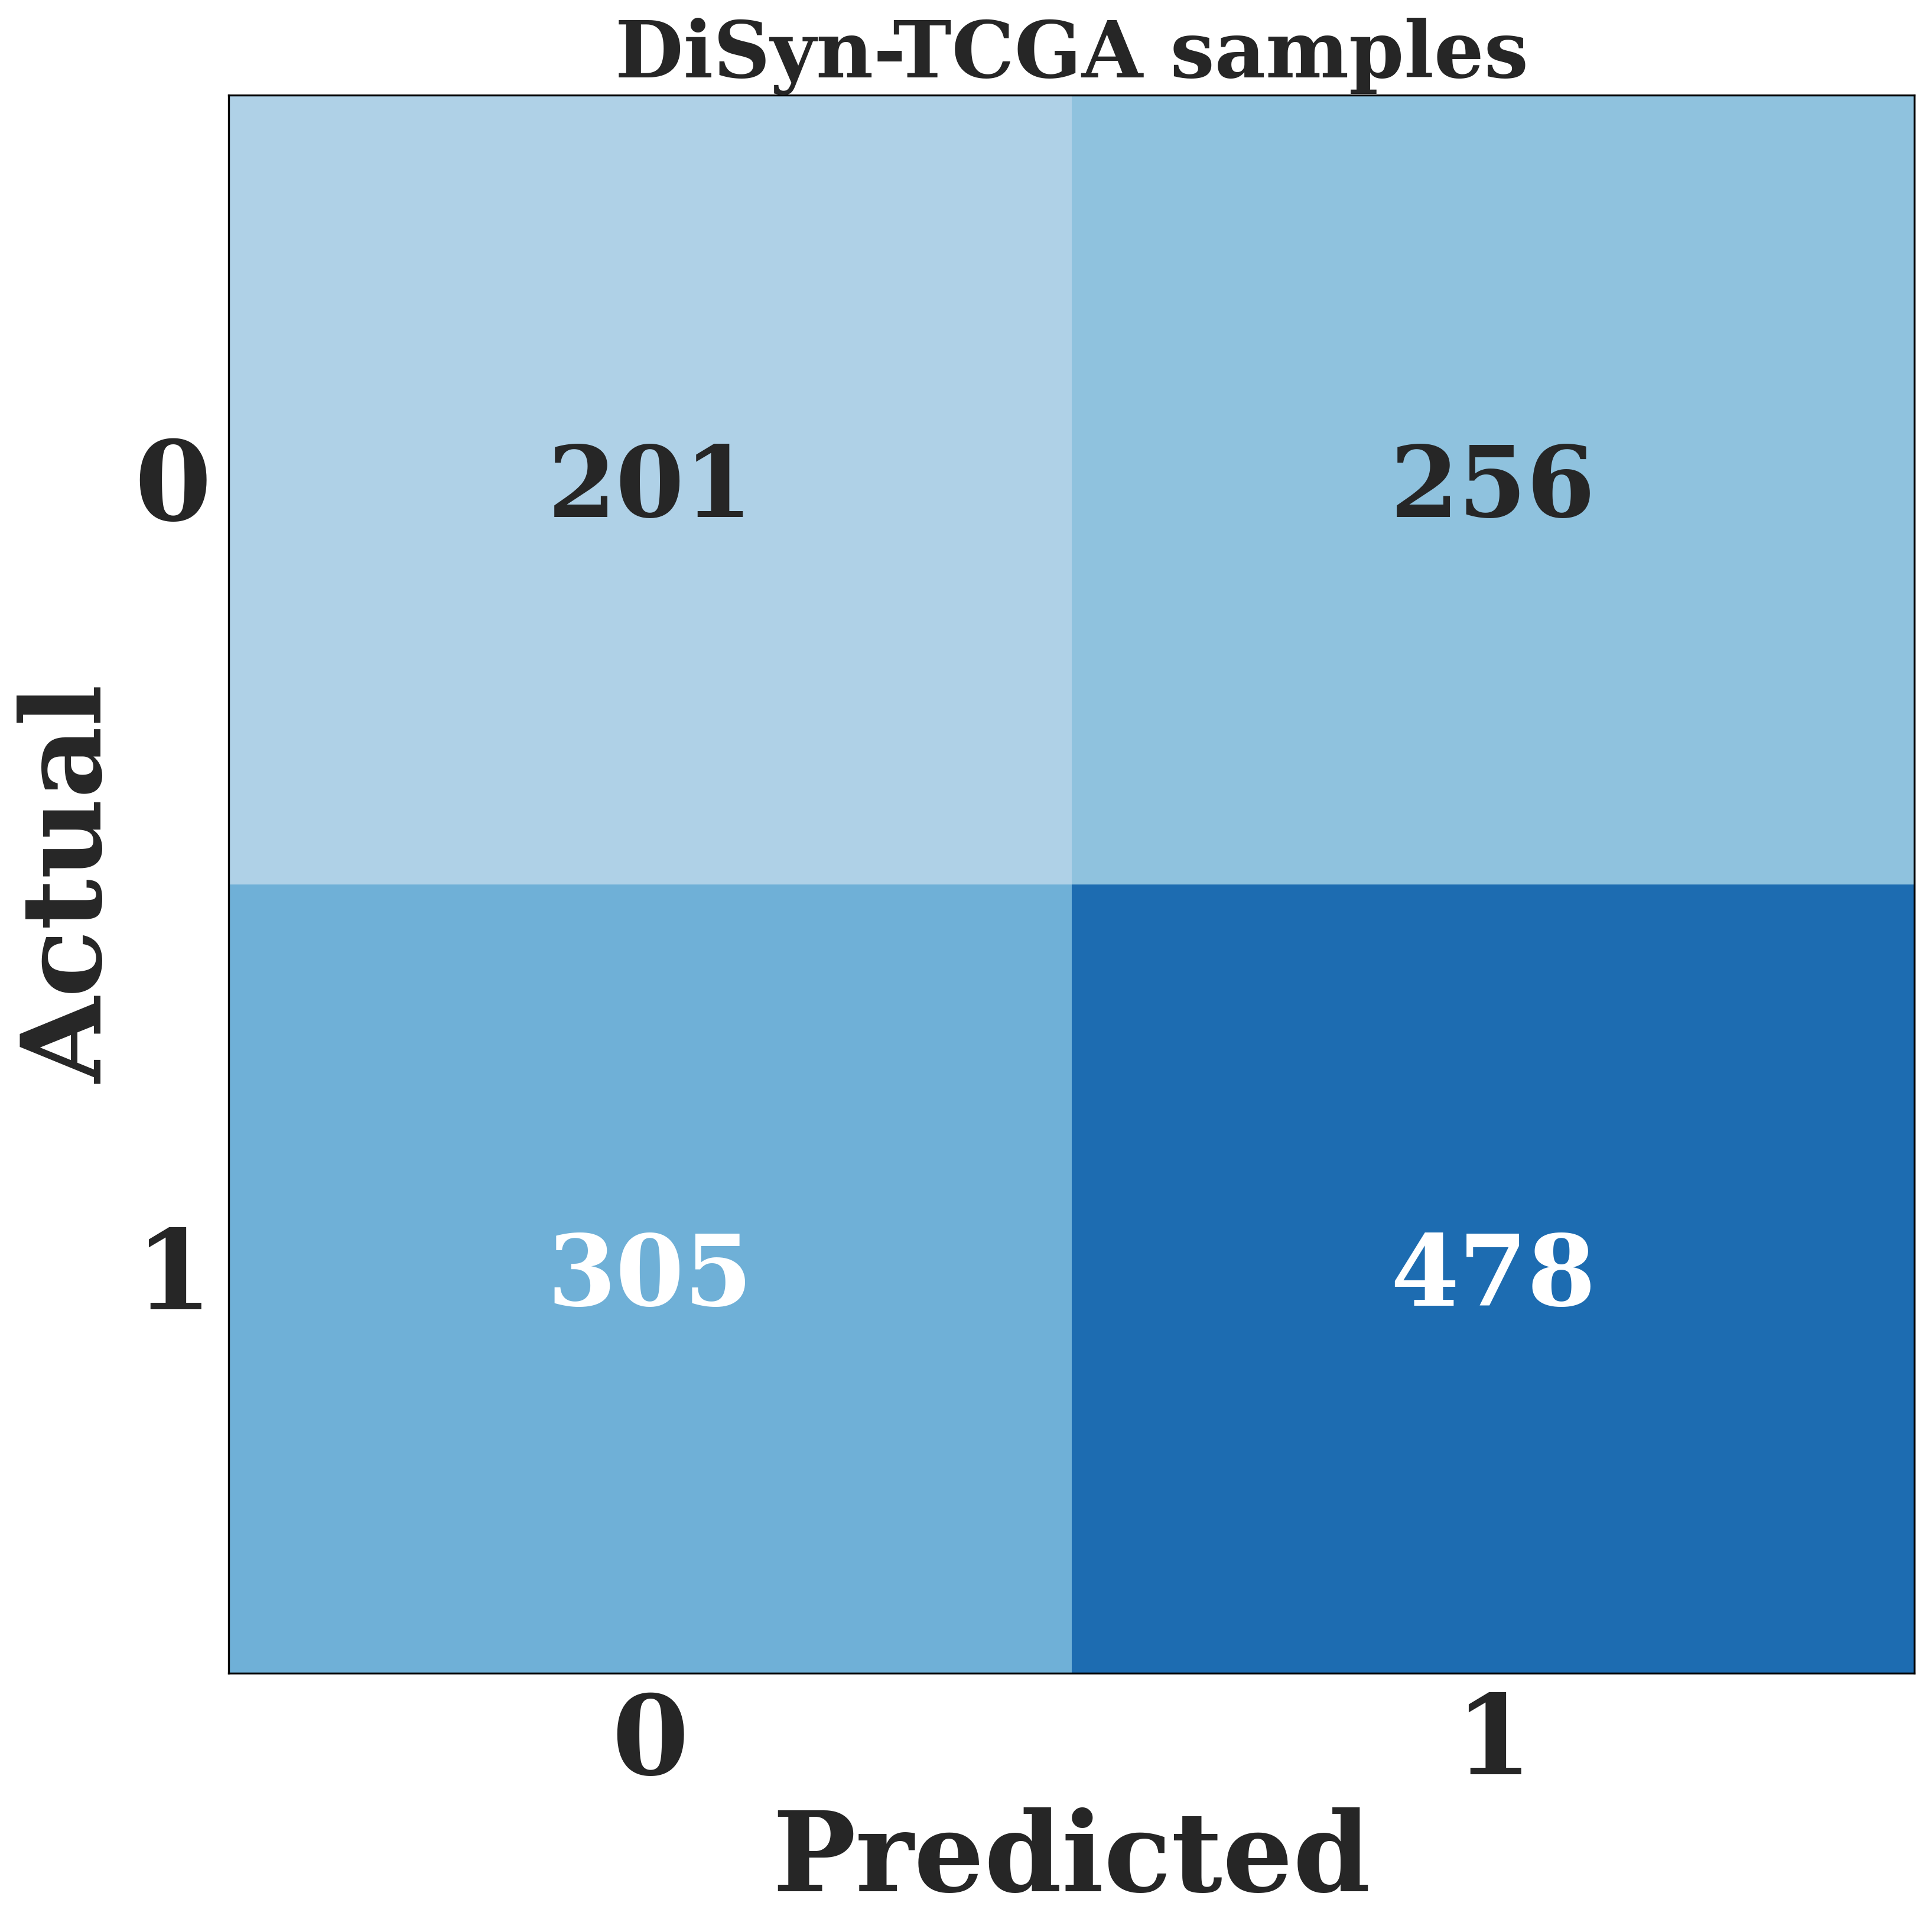

In [37]:
if model_inference is True:
    set_seed(seed)
    if model_name == "Omics_DrugESPF_Model":
        model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer, DA_Folder, TCGA_pretrain_weight_path_dict= None)
    elif model_name == "Omics_DCSA_Model":
        model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer, DA_Folder, TCGA_pretrain_weight_path_dict= None)
    elif model_name == "GIN_DCSA_model":
        model = GIN_DCSA_model(omics_encode_dim_dict, activation_func,activation_func_final,dense_layer_dim, device,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, 
                            n_layer, DA_Folder,TCGA_pretrain_weight_path_dict=None)
    model.to(device=device)
    model.load_state_dict(best_weight) 
    
    if DA_Folder != 'None':
        CohortExp_df = pd.read_csv(f"../data/DAPL/share/pretrain/{DA_Folder}/tcga_latent_results_{paper}_rmdup.csv", sep=',', index_col=0)
    else:
        CohortExp_df = pd.read_csv(TCGA_EXP_pth, sep=',', index_col=0) #1426
    label_df = pd.read_csv(label_df_pth, sep=',')
    label_df.columns.values[0] = 'ModelID'
    label_df['drug_name'] = label_df['drug_name'].str.lower() # match the drug name in drug_df
    CohortExp_df = CohortExp_df.sort_index(axis=0).sort_index(axis=1)
    print(f"{cohort}exp data",CohortExp_df.shape)
    label_df = label_df.sort_index(axis=0).sort_index(axis=1)
    print(f"label_df data",label_df.shape)
    for omic_type in include_omics:
        if DA_Folder != 'None':
            omics_data_dict["Exp"] = CohortExp_df
        else:
            if omic_type == "Exp":
                scaler = scaler_dict[omic_type]
                omics_data_dict[omic_type] = pd.DataFrame(scaler.transform(CohortExp_df),index=CohortExp_df.index,columns=CohortExp_df.columns) # use fitted CCLE scaler to transform TCGA data
        # omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
        omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]
        # print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
        print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

    drug_df = pd.read_csv( drug_df_path, sep=',') # "../data/GDSC/GDSC_drug_merge_pubchem_dropNA_MACCS.csv"
    drug_df['name'] = drug_df['name'].str.lower()
    drug_df = drug_df.set_index('name', drop=False)
    print(drug_df.shape)        
    
    if ESPF is True:
        # 挑出重複的SMILES
        duplicate =  drug_df["SMILES"][drug_df["SMILES"].duplicated(keep=False)]
        vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
        sub_csv = pd.read_csv(ESPF_file)# token with frequency
        # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
        drug_df["drug_encode"] = pd.Series(drug_df["SMILES"]).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
#             print("drug_encode",type(drug_df["drug_encode"]))
        drug_df["drug_encode"] = [i[:2] for i in drug_df["drug_encode"].values]
    else:
        drug_df["drug_encode"]=[list(map(int, item.split(','))) for item in drug_df["MACCS166bits"].values]
    #--------------------------------------------------------------------------------------------------------------------------
    num_ccl = list(omics_data_dict.values())[0].shape[0]
    num_drug = drug_df["drug_encode"].shape[0]
    print("num_ccl,num_drug: ",num_ccl,num_drug)
# Fc1c[nH]c(=O)[nH]c1=O 
    set_seed(seed)
    dataset = InstanceResponseDataset(label_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
    whole_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
    (eval_targets, eval_outputs,predAUCwithUnknownGT,
    AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
    eval_outputs_before_final_activation_list,   tSNE_embed_list,
    mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                                criterion, whole_loader, device,ESPF,Drug_SelfAttention, 
                                                weighted_threshold, few_weight, more_weight, 
                                                outputcontrol='inference')
    # Calculate classification metrics  
    drugs_metrics={}
    drug_name = paper
    
    drugs_metrics[drug_name], _  = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs), best_prob_threshold, metric, dataset="test")
    drugs_metrics[drug_name]["eval_targets"]=eval_targets
    drugs_metrics[drug_name]["eval_outputs"]=eval_outputs
    drugs_metrics[drug_name]["eval_outputs_before_final_activation_list"]=eval_outputs_before_final_activation_list
    drugs_metrics[drug_name][criterion.loss_type] = mean_batch_eval_loss_WO_penalty

    if 'BCE' in criterion.loss_type :
        (test_cm ,  test_GT_0_count, test_GT_1_count, 
        test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), best_prob_threshold)
        drugs_metrics[drug_name]["CM"] = test_cm
        # # plot confusion matrix
        cm_datas = [(test_cm, cohort, 'Blues')]
        Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=best_weight_path,drug=drug_name)
#         tSNE_embed_datas = [(tSNE_embed_list,eval_targets, cohort, 'Blues')]
#         tSNE_embed_plot(tSNE_embed_datas,hyperparameter_folder_path=best_weight_path,drug=drug_name)

    else:#regression use prob_threshold to get binary outcome
        df = pd.DataFrame({'predicted AUDRC': torch.cat(eval_outputs).cpu().numpy(),
                'Label': torch.cat(eval_targets).cpu().numpy()})
        # Perform t-test between the two groups
        sensitive = df[df['Label'] == 1]['predicted AUDRC']
        resistant = df[df['Label'] == 0]['predicted AUDRC']
        t_stat, p_val = ttest_ind(sensitive, resistant)
        drugs_metrics[drug_name]["pvalue"]= p_val
        if p_val<=0.05:
            TCGA_predAUDRC_box_plot_twoClass(drug_name,cohort,df,sensitive,resistant,p_val,best_weight_path)
output_file = f"{best_weight_path}/{paper}_BF{BF}_{cohort}_inference_result.txt"
with open(output_file, "w") as file:
    if 'BCE' in criterion.loss_type :
        for drug_name, metrics in drugs_metrics.items():
            file.write(f"\n{drug_name}\n")
            file.write(f"BF_best_prob_threshold: {best_prob_threshold} according to {metric}\n")
            file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
            for key in metrics_type_set:
                file.write(f"  '{key}': {metrics[key].item():.4f}\n")
            for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                file.write(f"\n{key}\n{metrics[key][0][:20]}\n\n")
    else:
        for drug_name, metrics in drugs_metrics.items():
            file.write(f"{drug_name}\n")
            file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
            if metrics['pvalue'].item() <= 0.05:
                file.write(f"\n pvalue <= 0.05 ")
            else:
                file.write(f"\n pvalue > 0.05 ")
            file.write(f"{drug_name} pvalue: {metrics['pvalue'].item():.4f}\n\n")
            for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                file.write(f"\n{key}\n{metrics[key][0][:20]}\n")       
#     os.chmod(output_file, 0o444) #Read-only


In [38]:
print(torch.cat(eval_targets ).shape, torch.cat(eval_outputs ).shape,np.concatenate(predAUCwithUnknownGT).shape)
print(torch.cat(eval_targets ))
print(torch.cat(eval_outputs ))
print(np.concatenate(predAUCwithUnknownGT ))

torch.Size([1240]) torch.Size([1240]) (1240,)
tensor([0., 0., 0.,  ..., 0., 1., 1.], device='cuda:0')
tensor([0.9527, 0.9747, 0.0671,  ..., 0.9875, 0.3776, 0.9976], device='cuda:0')
[0.9526649  0.97473675 0.06710836 ... 0.98751694 0.37758967 0.9976441 ]


In [39]:
best_prob_threshold

0.53332370519638

In [40]:
print(np.concatenate(predAUCwithUnknownGT).shape)
label_df['predict_value'] = np.concatenate(predAUCwithUnknownGT)
label_df["predict_label"] = (label_df["predict_value"] > best_prob_threshold).astype(int)
label_df.head()

(1240,)


Label       ModelID cancers    drug_name                      response  \
0      0  TCGA-OU-A5PI     ACC    etoposide                Stable Disease   
1      0  TCGA-OU-A5PI     ACC  doxorubicin                Stable Disease   
2      0  TCGA-OU-A5PI     ACC    cisplatin                Stable Disease   
3      0  TCGA-PK-A5HB     ACC    sorafenib  Clinical Progressive Disease   
4      0  TCGA-G2-A2EJ    BLCA   paclitaxel                Stable Disease   

   predict_value  predict_label  
0       0.952665              1  
1       0.974737              1  
2       0.067108              0  
3       0.932768              1  
4       0.997666              1

In [41]:
if paper == 'DeepCDR':
    cancerType_ls=['CESC']
    label_df["primary_disease"]='CESC'
elif paper == 'DiSyn':
    cancerType_ls=label_df["cancers"].unique().tolist()
    label_df.rename(columns={'cancers': 'primary_disease'}, inplace=True)
    
TP_df = label_df[(label_df["Label"] == 1) & (label_df["predict_label"] == 1)]
TN_df = label_df[(label_df["Label"] == 0) & (label_df["predict_label"] == 0)]
FP_df = label_df[(label_df["Label"] == 0) & (label_df["predict_label"] == 1)]
FN_df = label_df[(label_df["Label"] == 1) & (label_df["predict_label"] == 0)]
def count_by_drug(df, name):
    return (df.groupby("drug_name").size().rename(name))
def count_by_cancerType(df, name):
    return (df.groupby("primary_disease").size().rename(name))
drug_confusion = ( count_by_drug(TP_df, "TP").to_frame()
             .join(count_by_drug(TN_df, "TN"), how="outer")
             .join(count_by_drug(FP_df, "FP"), how="outer")
             .join(count_by_drug(FN_df, "FN"), how="outer")
             .fillna(0) .astype(int))
cancerType_confusion = ( count_by_cancerType(TP_df, "TP").to_frame()
                 .join(count_by_cancerType(TN_df, "TN"), how="outer")
                 .join(count_by_cancerType(FP_df, "FP"), how="outer")
                 .join(count_by_cancerType(FN_df, "FN"), how="outer")
                 .fillna(0) .astype(int))

In [42]:
# 計算各個CancerTpye在TCGA和cell line的TP、TN、FP、FN
AUC_df["predict_label"] = (AUC_df["predict_value"] > best_prob_threshold).astype(int)
tcga_cancerType = cancerType_confusion.index.tolist()#取得 TCGA drug list
cellline_tcga_cancerType_df = AUC_df[AUC_df["primary_disease"].isin(tcga_cancerType)].copy()#篩 cell line 資料，只看 TCGA relevant Type 在 cell line 的表現」
cell_TP_df = cellline_tcga_cancerType_df[(cellline_tcga_cancerType_df["Label"] == 1) & (cellline_tcga_cancerType_df["predict_label"] == 1)]
cell_TN_df = cellline_tcga_cancerType_df[(cellline_tcga_cancerType_df["Label"] == 0) &(cellline_tcga_cancerType_df["predict_label"] == 0)]
cell_FP_df = cellline_tcga_cancerType_df[(cellline_tcga_cancerType_df["Label"] == 0) &(cellline_tcga_cancerType_df["predict_label"] == 1)]
cell_FN_df = cellline_tcga_cancerType_df[(cellline_tcga_cancerType_df["Label"] == 1) &(cellline_tcga_cancerType_df["predict_label"] == 0)]
cellline_cancerType_confusion = (count_by_cancerType(cell_TP_df, "TP").to_frame() 
                     .join(count_by_cancerType(cell_TN_df, "TN"), how="outer")
                     .join(count_by_cancerType(cell_FP_df, "FP"), how="outer")
                     .join(count_by_cancerType(cell_FN_df, "FN"), how="outer")
                     .fillna(0).astype(int))
comparison_df = cancerType_confusion.add_prefix("TCGA_").join(cellline_cancerType_confusion.add_prefix("CCL_"), how="left").astype('Int64')
comparison_df

TCGA_TP  TCGA_TN  TCGA_FP  TCGA_FN  CCL_TP  CCL_TN  CCL_FP  \
primary_disease                                                               
ACC                    0        1        3        0      73      73      10   
BLCA                  60       10       48        5     709     720      42   
BRCA                 106        4       14       35    2010    2092     177   
CESC                  10        8        6       43     429     430      26   
COAD                   2        6        3        3    <NA>    <NA>    <NA>   
ESCA                  12        0        4        0    1442    1467     104   
HNSC                  31        2        8       15    1114    1126      88   
KIRP                   1        0        0        1    <NA>    <NA>    <NA>   
LGG                    0       79        2       10     479     481      39   
LIHC                   3        3       14        0     526     538      44   
LUAD                  37       14       19       36    2299    2414     104   
LUSC                  29        3        9        8     669     695      32   
MESO                   2       19       13       12     210     216       8   
OV                     3        0        0        0    1123    1145      87   
PAAD                  22        6       28        4     906     909      41   
PCPG                   0        1        1        0    <NA>    <NA>    <NA>   
PRAD                   1        3        2       14     234     246      18   
SARC                  19        5       42        1    <NA>    <NA>    <NA>   
SKCM                   5        3        5        4    1787    1831     118   
STAD                  13       31       13       38    1059    1111      82   
TGCT                  76        3        4       68    <NA>    <NA>    <NA>   
THCA                   2        0        0        0     497     493      24   
UCEC                  20        0        7        3     362     379      27   
UCS                   24        0       11        5    <NA>    <NA>    <NA>   

                 CCL_FN  
primary_disease          
ACC                  10  
BLCA                 53  
BRCA                259  
CESC                 27  
COAD               <NA>  
ESCA                129  
HNSC                100  
KIRP               <NA>  
LGG                  41  
LIHC                 56  
LUAD                219  
LUSC                 58  
MESO                 14  
OV                  109  
PAAD                 44  
PCPG               <NA>  
PRAD                 30  
SARC               <NA>  
SKCM                162  
STAD                134  
TGCT               <NA>  
THCA                 26  
UCEC                 44  
UCS                <NA>

In [43]:
# 計算TCGA各個CancerType的metrics
cancerType_metrics={}
for cancerType in cancerType_ls:
    cancerType_metrics[cancerType], _  = metrics_calculator(torch.tensor(label_df[label_df["primary_disease"] == cancerType]['Label'].values), 
                                                      torch.tensor(label_df[label_df["primary_disease"] == cancerType]['predict_value'].values), 
                                                      best_prob_threshold, metric, dataset="test")
cancerType_perform= pd.DataFrame(cancerType_metrics).T.map(lambda x: x.item() if hasattr(x, 'item') else x)
# Sort by AUPRC first, then by AUROC
cancerType_perform.sort_values(['AUPRC', 'AUROC'], ascending=[False, False])
cancerType_confusion.join(pd.DataFrame(cancerType_metrics).T.map(lambda x: x.item() if hasattr(x, 'item') else x))

/home/S312112030/miniconda3/envs/ESPFgpu_py311/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/S312112030/miniconda3/envs/ESPFgpu_py311/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


TP  TN  FP  FN  Accuracy     AUROC     AUPRC  Sensitivity  \
primary_disease                                                               
ACC                0   1   3   0  0.250000  0.000000       NaN     0.000000   
BLCA              60  10  48   5  0.569106  0.436340  0.479485     0.923077   
BRCA             106   4  14  35  0.691824  0.501970  0.881100     0.751773   
CESC              10   8   6  43  0.268657  0.351752  0.742044     0.188679   
COAD               2   6   3   3  0.571429  0.600000  0.584860     0.400000   
ESCA              12   0   4   0  0.750000  0.291667  0.657744     1.000000   
HNSC              31   2   8  15  0.589286  0.306522  0.732506     0.673913   
KIRP               1   0   0   1  0.500000  0.000000  1.000000     0.500000   
LGG                0  79   2  10  0.868132  0.530864  0.135068     0.000000   
LIHC               3   3  14   0  0.300000  0.823529  0.569444     1.000000   
LUAD              37  14  19  36  0.481132  0.469074  0.712552     0.506849   
LUSC              29   3   9   8  0.653061  0.590090  0.834964     0.783784   
MESO               2  19  13  12  0.456522  0.375000  0.251887     0.142857   
OV                 3   0   0   0  1.000000  0.000000  1.000000     1.000000   
PAAD              22   6  28   4  0.466667  0.622172  0.626081     0.846154   
PCPG               0   1   1   0  0.500000  0.000000       NaN     0.000000   
PRAD               1   3   2  14  0.200000  0.426667  0.725536     0.066667   
SARC              19   5  42   1  0.358209  0.606383  0.434072     0.950000   
SKCM               5   3   5   4  0.470588  0.500000  0.610143     0.555556   
STAD              13  31  13  38  0.463158  0.491533  0.558879     0.254902   
TGCT              76   3   4  68  0.523179  0.545635  0.961112     0.527778   
THCA               2   0   0   0  1.000000  0.000000  1.000000     1.000000   
UCEC              20   0   7   3  0.666667  0.341615  0.709983     0.869565   
UCS               24   0  11   5  0.600000  0.463950  0.718916     0.827586   

                 Specificity  Precision        F1    Youden  F1_RecSpe  \
primary_disease                                                          
ACC                 0.250000   0.000000  0.000000 -0.750000   0.000000   
BLCA                0.172414   0.555556  0.693642  0.095491   0.290557   
BRCA                0.222222   0.883333  0.812261 -0.026005   0.343042   
CESC                0.571429   0.625000  0.289855 -0.239892   0.283688   
COAD                0.666667   0.400000  0.400000  0.066667   0.500000   
ESCA                0.000000   0.750000  0.857143  0.000000   0.000000   
HNSC                0.200000   0.794872  0.729412 -0.126087   0.308458   
KIRP                0.000000   1.000000  0.666667 -0.500000   0.000000   
LGG                 0.975309   0.000000  0.000000 -0.024691   0.000000   
LIHC                0.176471   0.176471  0.300000  0.176471   0.300000   
LUAD                0.424242   0.660714  0.573643 -0.068908   0.461881   
LUSC                0.250000   0.763158  0.773333  0.033784   0.379085   
MESO                0.593750   0.133333  0.137931 -0.263393   0.230303   
OV                  0.000000   1.000000  1.000000  0.000000   0.000000   
PAAD                0.176471   0.440000  0.578947  0.022624   0.292035   
PCPG                0.500000   0.000000  0.000000 -0.500000   0.000000   
PRAD                0.600000   0.333333  0.111111 -0.333333   0.120000   
SARC                0.106383   0.311475  0.469136  0.056383   0.191339   
SKCM                0.375000   0.500000  0.526316 -0.069444   0.447761   
STAD                0.704545   0.500000  0.337662 -0.040553   0.374361   
TGCT                0.428571   0.950000  0.678571 -0.043651   0.473029   
THCA                0.000000   1.000000  1.000000  0.000000   0.000000   
UCEC                0.000000   0.740741  0.800000 -0.130435   0.000000   
UCS                 0.000000   0.685714  0.750000 -0.172414   0.000000   

                 F1_RecSpePre  Best_Th

In [44]:
# 計算各個藥在TCGA和cell line的TP、TN、FP、FN
AUC_df["predict_label"] = (AUC_df["predict_value"] > best_prob_threshold).astype(int)
tcga_drugs = drug_confusion.index.tolist()#取得 TCGA drug list
cellline_tcga_drug_df = AUC_df[AUC_df["mapped_name"].isin(tcga_drugs)].copy()#篩 cell line 資料，只看 TCGA relevant drugs 在 cell line 的表現」
cell_TP_df = cellline_tcga_drug_df[(cellline_tcga_drug_df["Label"] == 1) & (cellline_tcga_drug_df["predict_label"] == 1)]
cell_TN_df = cellline_tcga_drug_df[(cellline_tcga_drug_df["Label"] == 0) &(cellline_tcga_drug_df["predict_label"] == 0)]
cell_FP_df = cellline_tcga_drug_df[(cellline_tcga_drug_df["Label"] == 0) &(cellline_tcga_drug_df["predict_label"] == 1)]
cell_FN_df = cellline_tcga_drug_df[(cellline_tcga_drug_df["Label"] == 1) &(cellline_tcga_drug_df["predict_label"] == 0)]
cellline_drug_confusion = (count_by_drug(cell_TP_df, "TP").to_frame() # 4311 samples
                     .join(count_by_drug(cell_TN_df, "TN"), how="outer")
                     .join(count_by_drug(cell_FP_df, "FP"), how="outer")
                     .join(count_by_drug(cell_FN_df, "FN"), how="outer")
                     .fillna(0).astype(int))
cellline_drug_confusion.index = cellline_drug_confusion.index.str.lower()
comparison_df = drug_confusion.add_prefix("TCGA_").join(cellline_drug_confusion.add_prefix("CCL_"), how="left").astype('Int64')
comparison_df

TCGA_TP  TCGA_TN  TCGA_FP  TCGA_FN  CCL_TP  CCL_TN  CCL_FP  \
drug_name                                                                    
5-fluorouracil        8       39        7       68      55     291      16   
bicalutamide          0        3        0       14       0      88       0   
bleomycin            22        2        3       25      35      42      11   
cisplatin            64       47       18      161      88      76      17   
docetaxel            56        0       32        0     666       0       1   
doxorubicin          53        0       31        0    <NA>    <NA>    <NA>   
etoposide            72        0       11        0    <NA>    <NA>    <NA>   
gemcitabine          69        0       76        0     491       0      11   
methotrexate          7        0        7        0     256       0      29   
paclitaxel           96        0       46        0     204       0       4   
pemetrexed            0       20        0       16    <NA>    <NA>    <NA>   
sorafenib             2        1       12        0     277       0      12   
tamoxifen             0        7        0       11       5     211       8   
temozolomide          0       82        0       10       1     638       1   
vinblastine           6        0        7        0     343       0       0   
vinorelbine          23        0        6        0     399       0       0   

                CCL_FN  
drug_name               
5-fluorouracil     111  
bicalutamide         1  
bleomycin            9  
cisplatin           32  
docetaxel            0  
doxorubicin       <NA>  
etoposide         <NA>  
gemcitabine          0  
methotrexate         3  
paclitaxel           0  
pemetrexed        <NA>  
sorafenib            0  
tamoxifen           42  
temozolomide        19  
vinblastine          0  
vinorelbine          0

In [45]:
# 計算TCGA各個藥的metrics
drugs_metrics={}
for drug_name in tcga_drugs:
    drugs_metrics[drug_name], _  = metrics_calculator(torch.tensor(label_df[label_df["drug_name"] == drug_name]['Label'].values), 
                                                      torch.tensor(label_df[label_df["drug_name"] == drug_name]['predict_value'].values), 
                                                      best_prob_threshold, metric, dataset="test")
drug_confusion.join(pd.DataFrame(drugs_metrics).T.map(lambda x: x.item() if hasattr(x, 'item') else x))

TP  TN  FP   FN  Accuracy     AUROC     AUPRC  Sensitivity  \
drug_name                                                                    
5-fluorouracil   8  39   7   68  0.385246  0.347826  0.579813     0.105263   
bicalutamide     0   3   0   14  0.176471  0.642857  0.894819     0.000000   
bleomycin       22   2   3   25  0.461538  0.468085  0.856336     0.468085   
cisplatin       64  47  18  161  0.382759  0.503932  0.795875     0.284444   
docetaxel       56   0  32    0  0.636364  0.612723  0.712952     1.000000   
doxorubicin     53   0  31    0  0.630952  0.768716  0.829995     1.000000   
etoposide       72   0  11    0  0.867470  0.635101  0.899160     1.000000   
gemcitabine     69   0  76    0  0.475862  0.707857  0.652287     1.000000   
methotrexate     7   0   7    0  0.500000  0.836735  0.892857     1.000000   
paclitaxel      96   0  46    0  0.676056  0.508605  0.673943     1.000000   
pemetrexed       0  20   0   16  0.555556  0.590625  0.556004     0.000000   
sorafenib        2   1  12    0  0.200000  0.653846  0.242857     1.000000   
tamoxifen        0   7   0   11  0.388889  0.363636  0.600142     0.000000   
temozolomide     0  82   0   10  0.891304  0.559756  0.148032     0.000000   
vinblastine      6   0   7    0  0.461538  0.309524  0.512529     1.000000   
vinorelbine     23   0   6    0  0.793103  0.659420  0.870012     1.000000   

                Specificity  Precision        F1    Youden  F1_RecSpe  \
drug_name                                                               
5-fluorouracil     0.847826   0.533333  0.175824 -0.046911   0.187275   
bicalutamide       1.000000   0.000000  0.000000  0.000000   0.000000   
bleomycin          0.400000   0.880000  0.611111 -0.131915   0.431373   
cisplatin          0.723077   0.780488  0.416938  0.007521   0.408280   
docetaxel          0.000000   0.636364  0.777778  0.000000   0.000000   
doxorubicin        0.000000   0.630952  0.773723  0.000000   0.000000   
etoposide          0.000000   0.867470  0.929032  0.000000   0.000000   
gemcitabine        0.000000   0.475862  0.644860  0.000000   0.000000   
methotrexate       0.000000   0.500000  0.666667  0.000000   0.000000   
paclitaxel         0.000000   0.676056  0.806723  0.000000   0.000000   
pemetrexed         1.000000   0.000000  0.000000  0.000000   0.000000   
sorafenib          0.076923   0.142857  0.250000  0.076923   0.142857   
tamoxifen          1.000000   0.000000  0.000000  0.000000   0.000000   
temozolomide       1.000000   0.000000  0.000000  0.000000   0.000000   
vinblastine        0.000000   0.461538  0.631579  0.000000   0.000000   
vinorelbine        0.000000   0.793103  0.884615  0.000000   0.000000   

                F1_RecSpePre  Best_Threshold  
drug_name                                     
5-fluorouracil      0.096064        0.533324  
bicalutamide        0.000000        0.533324  
bleomycin           0.282765        0.533324  
cisplatin           0.269339        0.533324  
docetaxel           0.000000        0.533324  
doxorubicin         0.000000        0.533324  
etoposide           0.000000        0.533324  
gemcitabine         0.000000        0.533324  
methotrexate        0.000000        0.533324  
paclitaxel          0.000000        0.533324  
pemetrexed          0.000000        0.533324  
sorafenib           0.027027        0.533324  
tamoxifen           0.000000        0.533324  
temozolomide        0.000000        0.533324  
vinblastine         0.000000        0.533324  
vinorelbine         0.000000        0.533324

In [46]:
# 計算cell line各個藥的metrics
drugs_metrics={}
for drug_name in cellline_drug_confusion.index.tolist():
    drugs_metrics[drug_name], _  = metrics_calculator(torch.tensor(AUC_df[AUC_df["mapped_name"] == drug_name]['Label'].values), 
                                                      torch.tensor(AUC_df[AUC_df["mapped_name"] == drug_name]['predict_value'].values), 
                                                      best_prob_threshold, metric, dataset="test")
cellline_drug_confusion.join(pd.DataFrame(drugs_metrics).T.map(lambda x: x.item() if hasattr(x, 'item') else x))

/home/S312112030/miniconda3/envs/ESPFgpu_py311/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


TP   TN  FP   FN  Accuracy     AUROC     AUPRC  Sensitivity  \
drug_name                                                                      
5-fluorouracil   55  291  16  111  0.731501  0.728562  0.642706     0.331325   
bicalutamide      0   88   0    1  0.988764  0.954545  0.200000     0.000000   
bleomycin        35   42  11    9  0.793814  0.843053  0.818524     0.795455   
cisplatin        88   76  17   32  0.769953  0.851971  0.881119     0.733333   
docetaxel       666    0   1    0  0.998501  0.827327  0.999716     1.000000   
gemcitabine     491    0  11    0  0.978088  0.807813  0.994634     1.000000   
methotrexate    256    0  29    3  0.888889  0.709493  0.952969     0.988417   
paclitaxel      204    0   4    0  0.980769  0.778186  0.992244     1.000000   
sorafenib       277    0  12    0  0.958477  0.598977  0.967047     1.000000   
tamoxifen         5  211   8   42  0.812030  0.682794  0.365426     0.106383   
temozolomide      1  638   1   19  0.969651  0.925822  0.351069     0.050000   
vinblastine     343    0   0    0  1.000000  0.000000  1.000000     1.000000   
vinorelbine     399    0   0    0  1.000000  0.000000  1.000000     1.000000   

                Specificity  Precision        F1    Youden  F1_RecSpe  \
drug_name                                                               
5-fluorouracil     0.947883   0.774648  0.464135  0.279208   0.491019   
bicalutamide       1.000000   0.000000  0.000000  0.000000   0.000000   
bleomycin          0.792453   0.760870  0.777778  0.587907   0.793951   
cisplatin          0.817204   0.838095  0.782222  0.550538   0.773000   
docetaxel          0.000000   0.998501  0.999250  0.000000   0.000000   
gemcitabine        0.000000   0.978088  0.988922  0.000000   0.000000   
methotrexate       0.000000   0.898246  0.941176 -0.011583   0.000000   
paclitaxel         0.000000   0.980769  0.990291  0.000000   0.000000   
sorafenib          0.000000   0.958477  0.978799  0.000000   0.000000   
tamoxifen          0.963470   0.384615  0.166667  0.069853   0.191609   
temozolomide       0.998435   0.500000  0.090909  0.048435   0.095231   
vinblastine        0.000000   1.000000  1.000000  0.000000   0.000000   
vinorelbine        0.000000   1.000000  1.000000  0.000000   0.000000   

                F1_RecSpePre  Best_Threshold  
drug_name                                     
5-fluorouracil      0.355357        0.533324  
bicalutamide        0.000000        0.533324  
bleomycin           0.612602        0.533324  
cisplatin           0.630808        0.533324  
docetaxel           0.000000        0.533324  
gemcitabine         0.000000        0.533324  
methotrexate        0.000000        0.533324  
paclitaxel          0.000000        0.533324  
sorafenib           0.000000        0.533324  
tamoxifen           0.081312        0.533324  
temozolomide        0.048360        0.533324  
vinblastine         0.000000        0.533324  
vinorelbine         0.000000        0.533324

In [47]:
best_prob_threshold

0.53332370519638

## CodeAE TCGA samples inference

In [48]:
label_df

Label       ModelID primary_disease    drug_name  \
0         0  TCGA-OU-A5PI             ACC    etoposide   
1         0  TCGA-OU-A5PI             ACC  doxorubicin   
2         0  TCGA-OU-A5PI             ACC    cisplatin   
3         0  TCGA-PK-A5HB             ACC    sorafenib   
4         0  TCGA-G2-A2EJ            BLCA   paclitaxel   
...     ...           ...             ...          ...   
1235      1  TCGA-NA-A4QW             UCS   paclitaxel   
1236      1  TCGA-NF-A4WX             UCS   paclitaxel   
1237      0  TCGA-NG-A4VU             UCS   paclitaxel   
1238      1  TCGA-NG-A4VW             UCS    cisplatin   
1239      1  TCGA-NG-A4VW             UCS  doxorubicin   

                          response  predict_value  predict_label  
0                   Stable Disease       0.952665              1  
1                   Stable Disease       0.974737              1  
2                   Stable Disease       0.067108              0  
3     Clinical Progressive Disease       0.932768              1  
4                   Stable Disease       0.997666              1  
...                            ...            ...            ...  
1235             Complete Response       0.995128              1  
1236             Complete Response       0.991608              1  
1237  Clinical Progressive Disease       0.987517              1  
1238             Complete Response       0.377590              0  
1239             Complete Response       0.997644              1  

[1240 rows x 7 columns]

TCGAexp cisplatindata (40, 32)
label_df cisplatindata (40, 3)
Exp num_features 32
           DRUG_NAME     PATHWAY_NAME  \
name                                    
cisplatin  cisplatin  DNA replication   

                                                    synonyms     pathway_name  \
name                                                                            
cisplatin  cis-Diammineplatinum(II) dichloride, Platinol,...  DNA replication   

                    target  pubchem Dataset       name  \
name                                                     
cisplatin  DNA crosslinker  84691.0   GDSC2  cisplatin   

                           SMILES  \
name                                
cisplatin  N.N.[Cl-].[Cl-].[Pt+2]   

                                                MACCS166bits  
name                                                          
cisplatin  0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0...  
num_ccl,num_drug:  40 1

 MACCS166 is applied 

✅ Set read-only permission

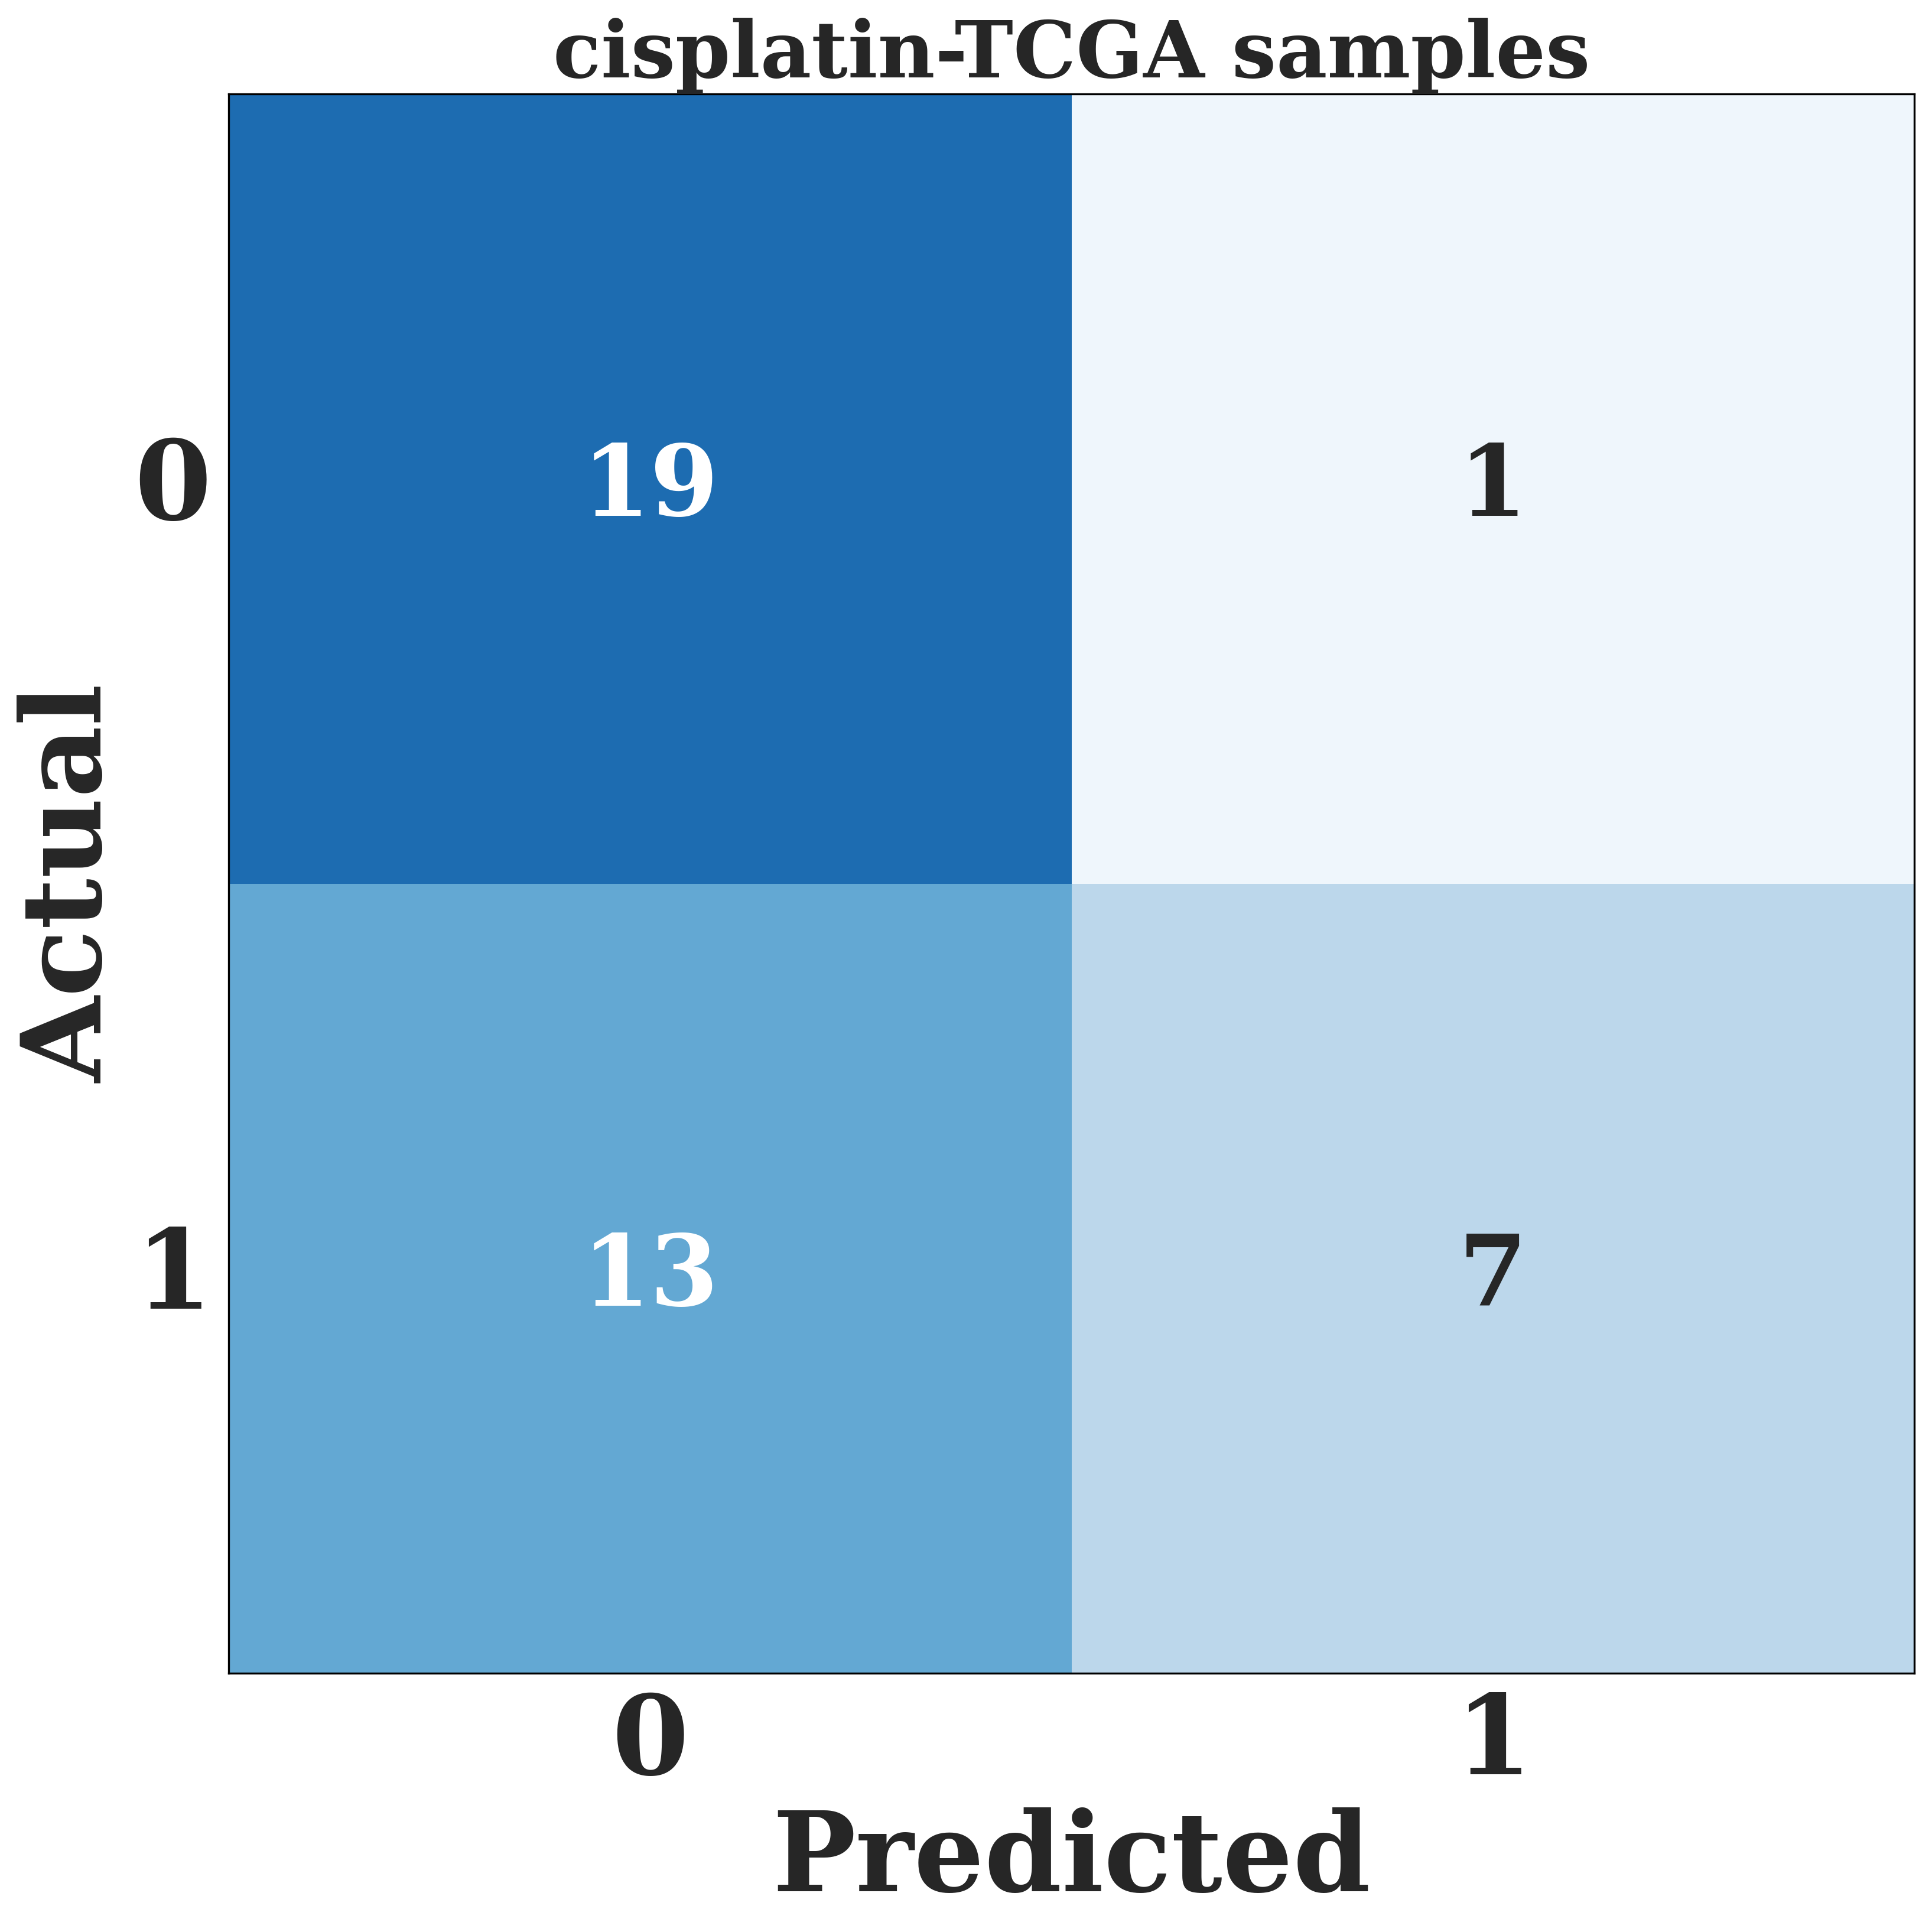

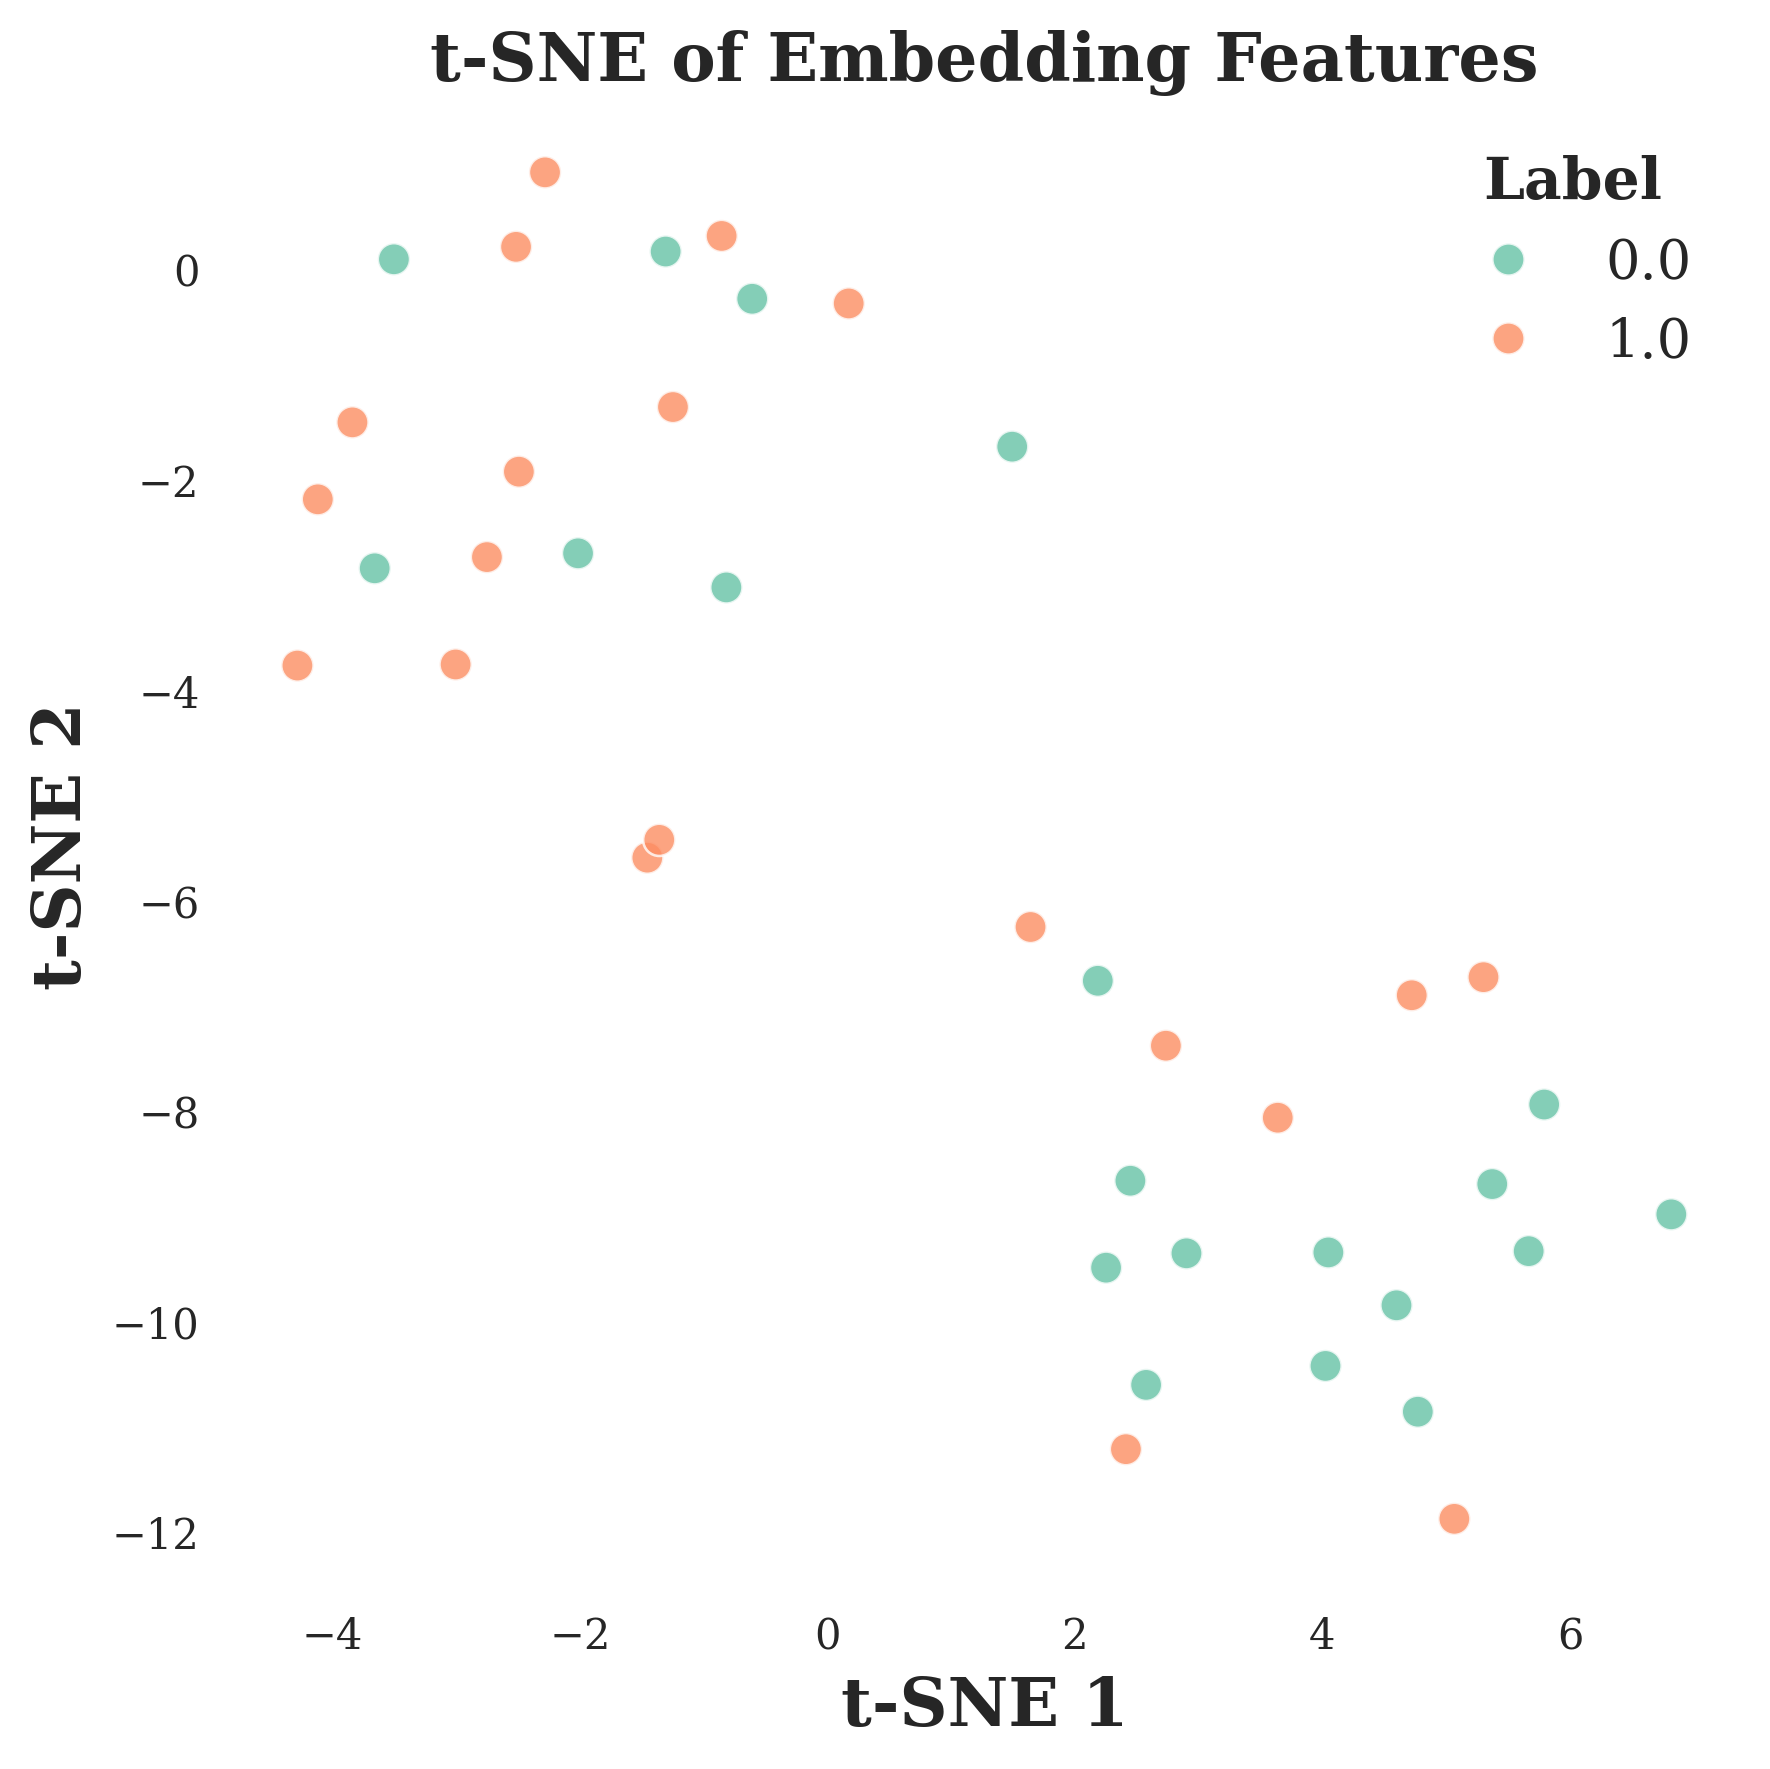

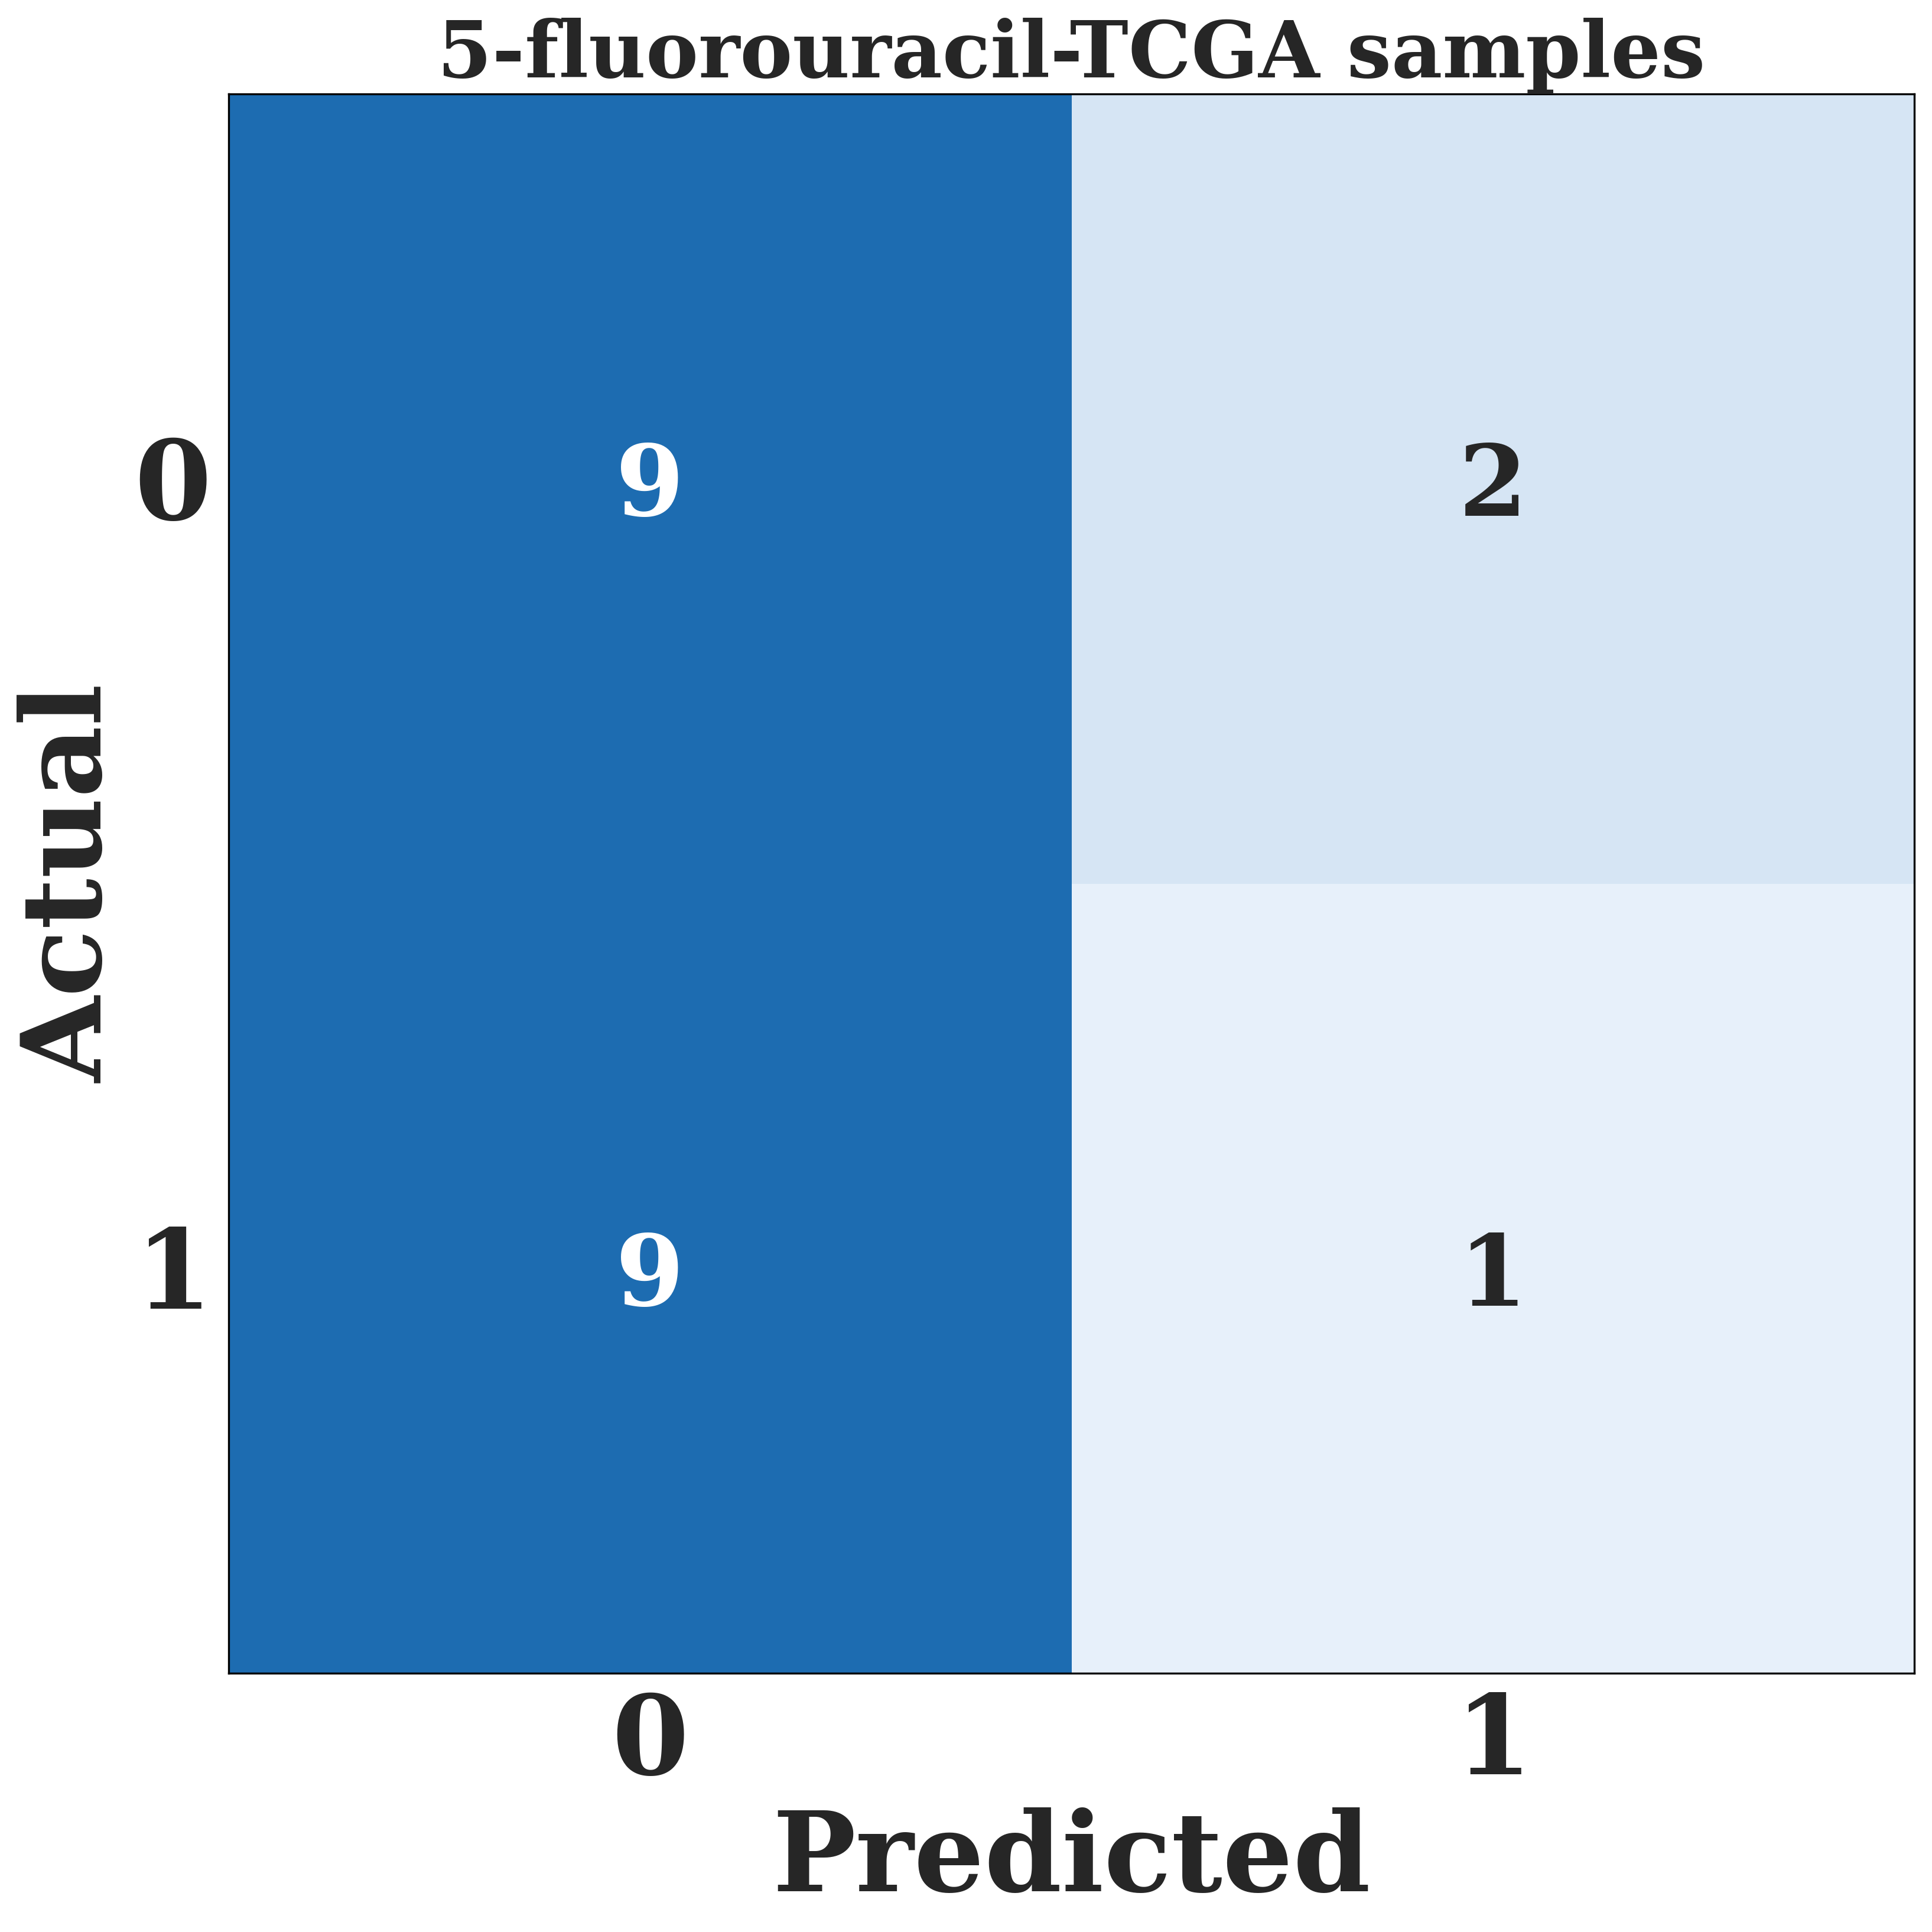

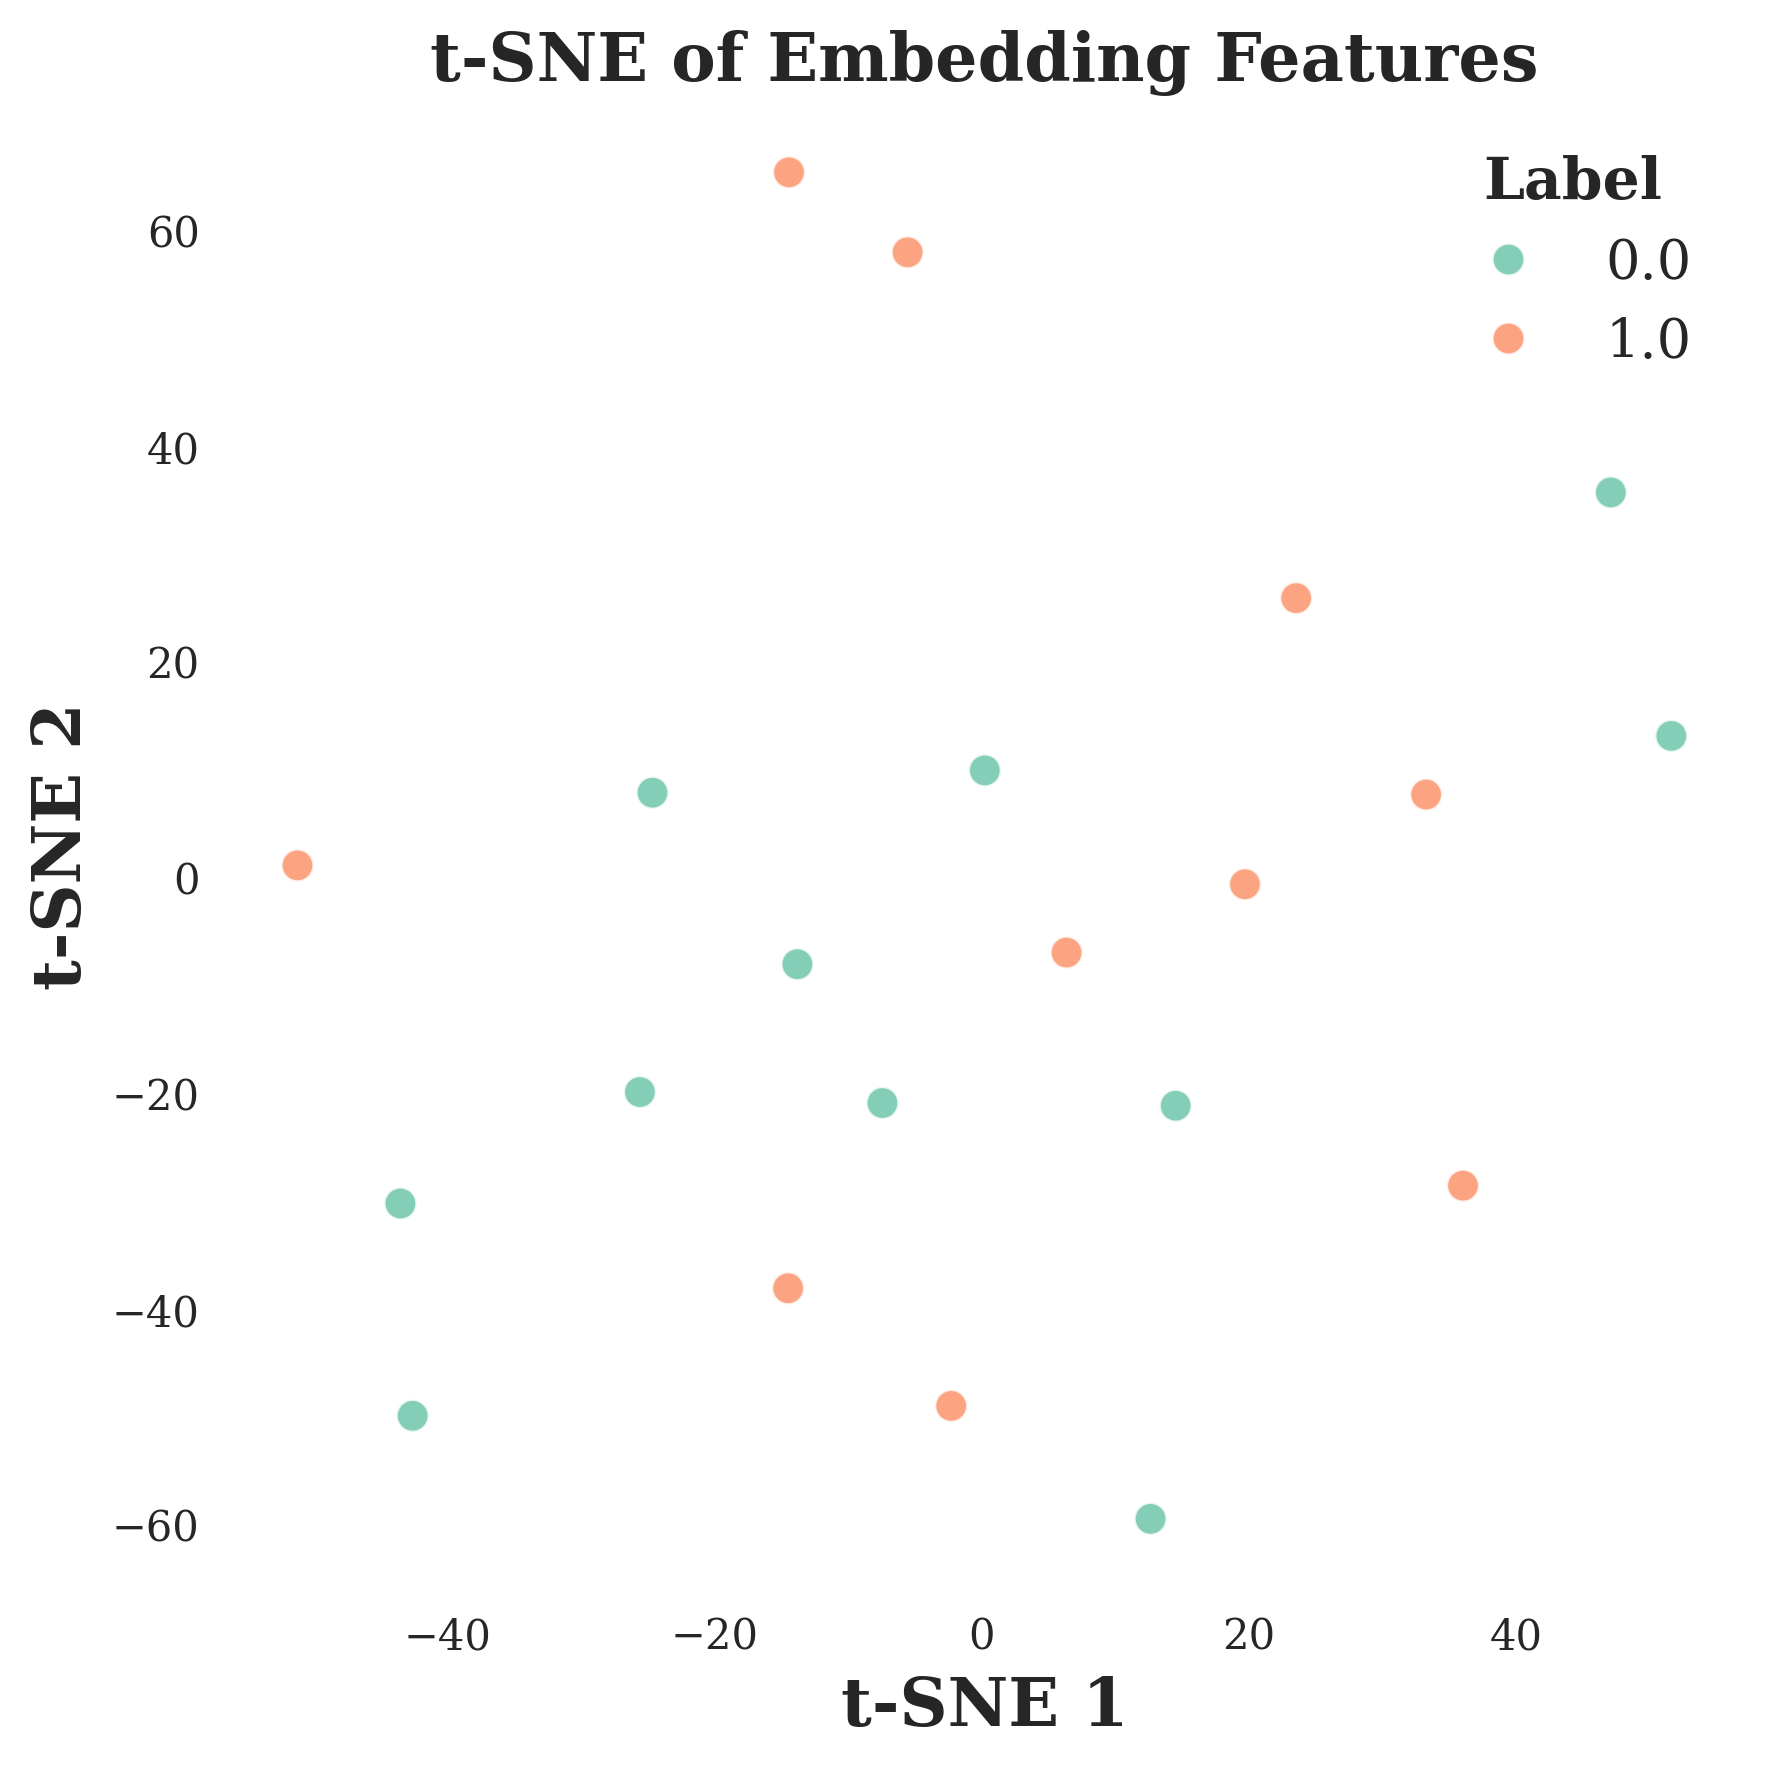

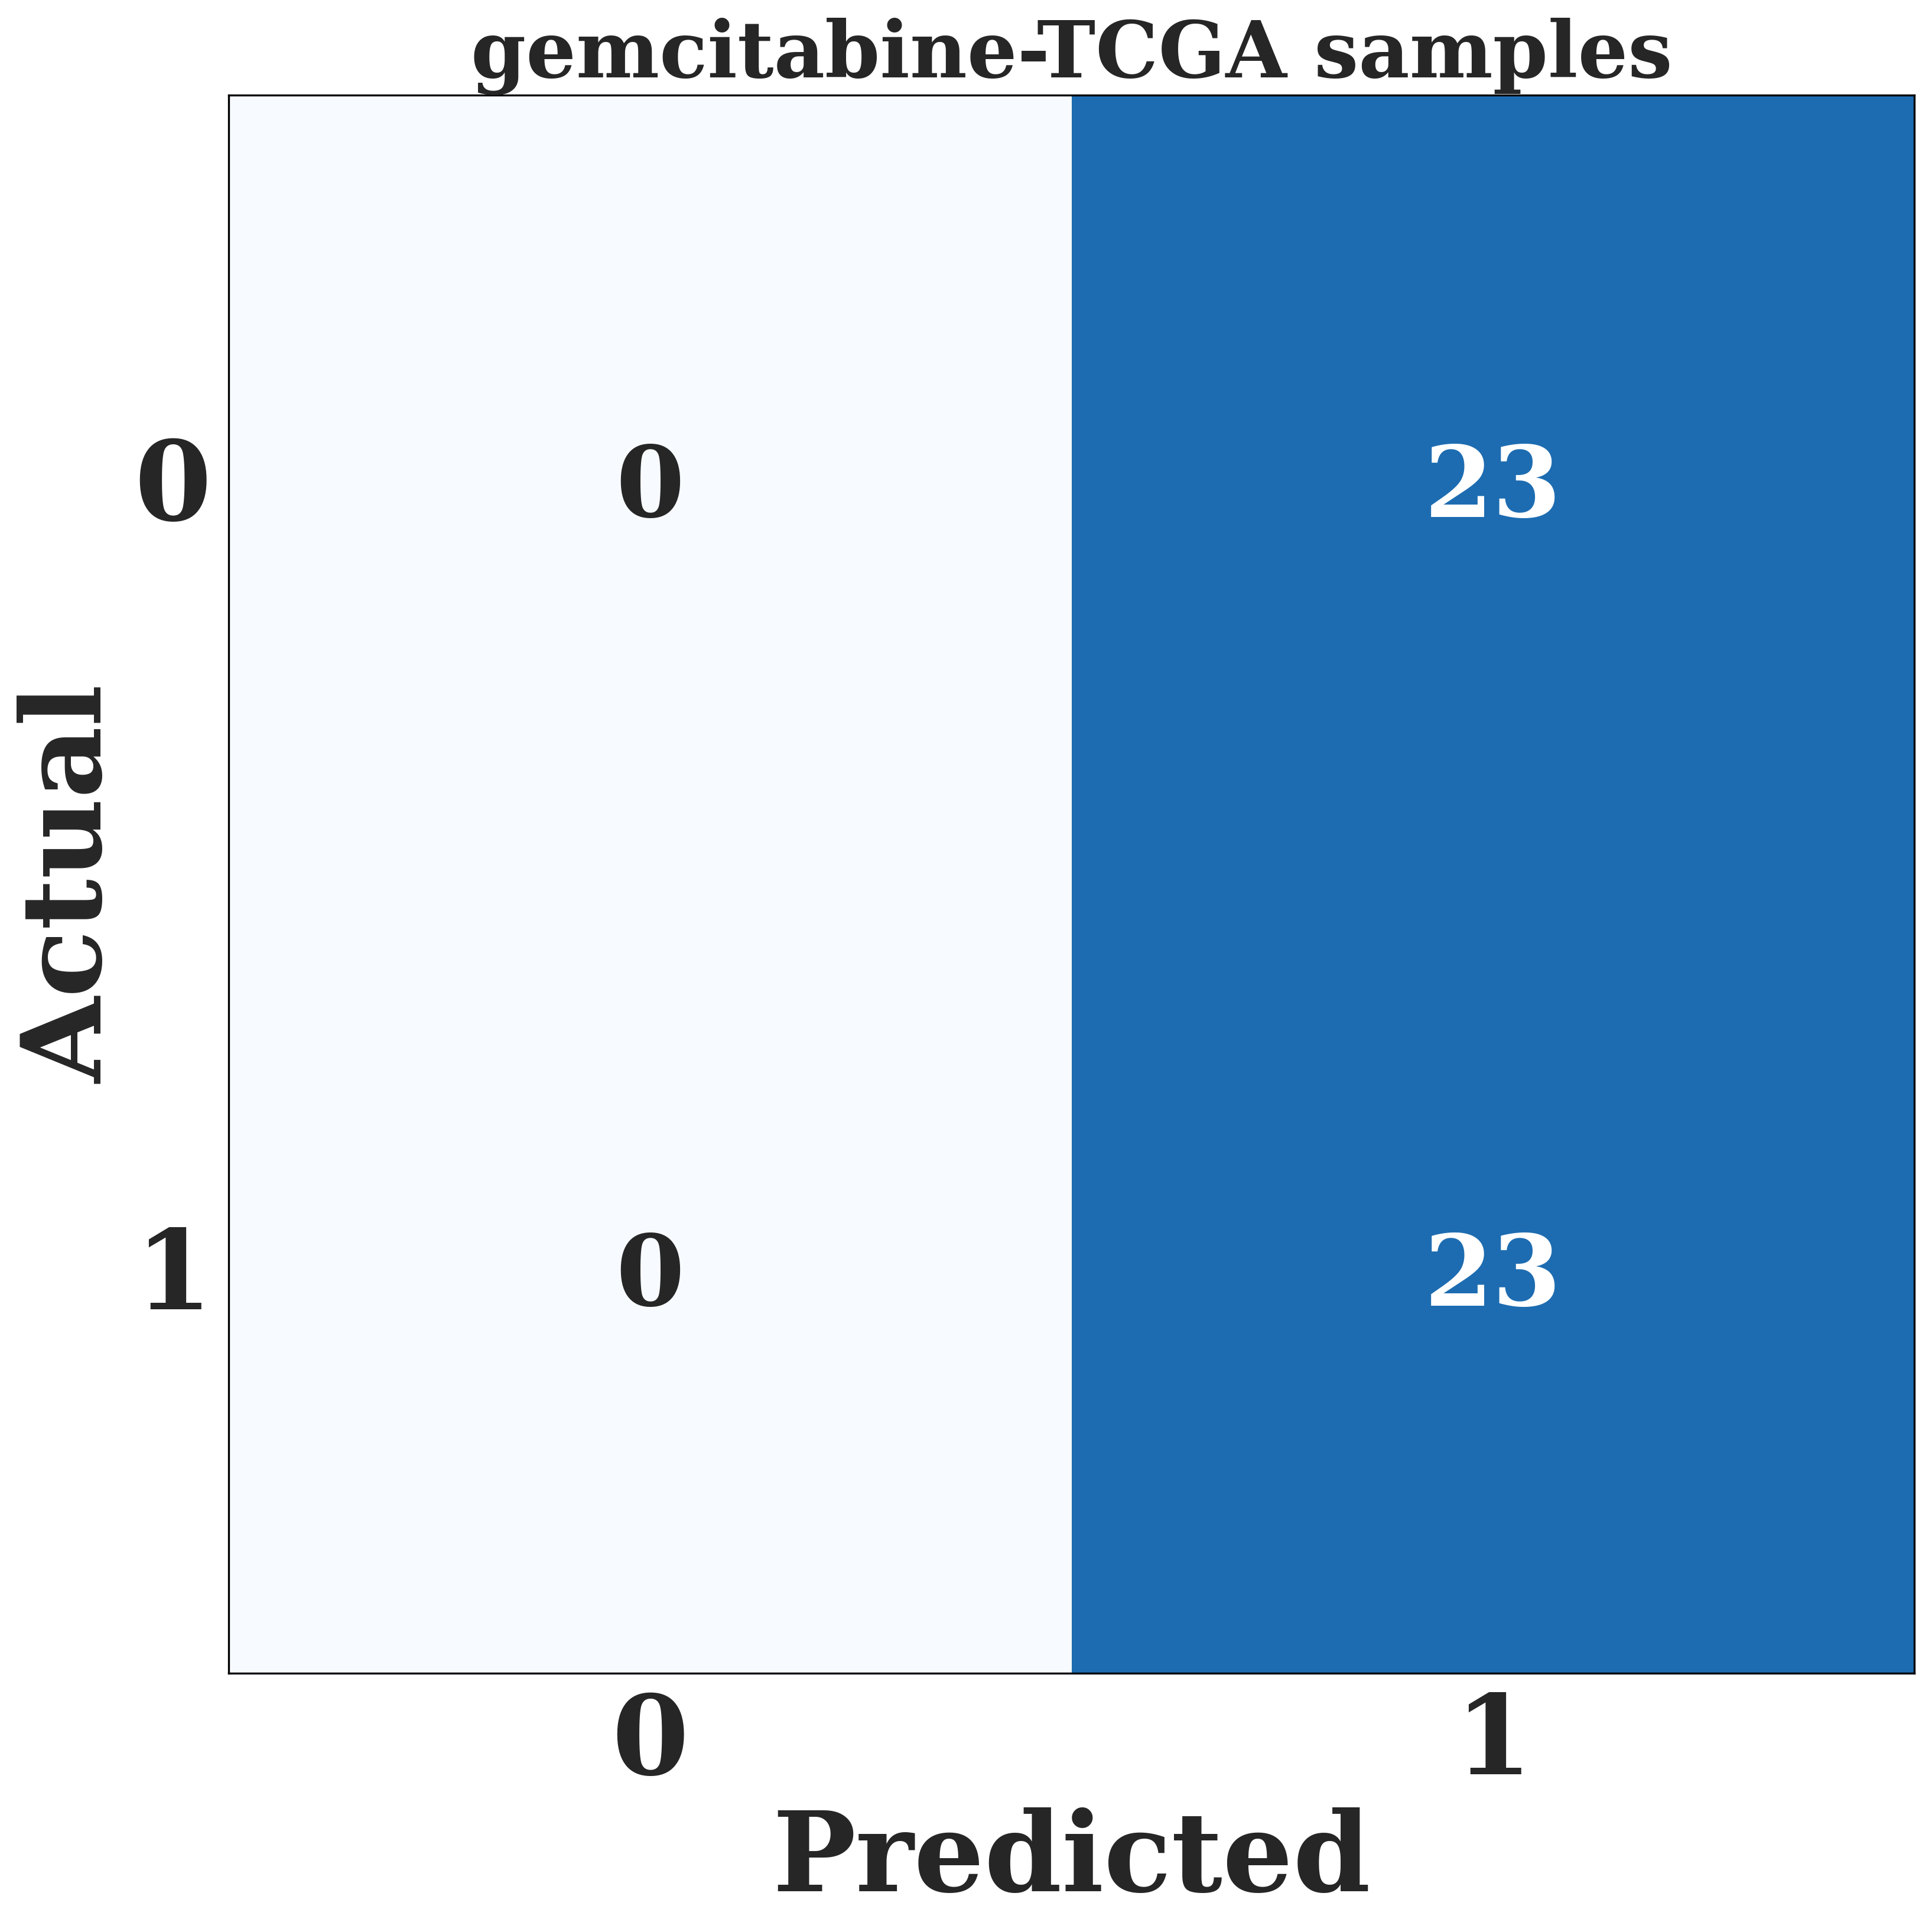

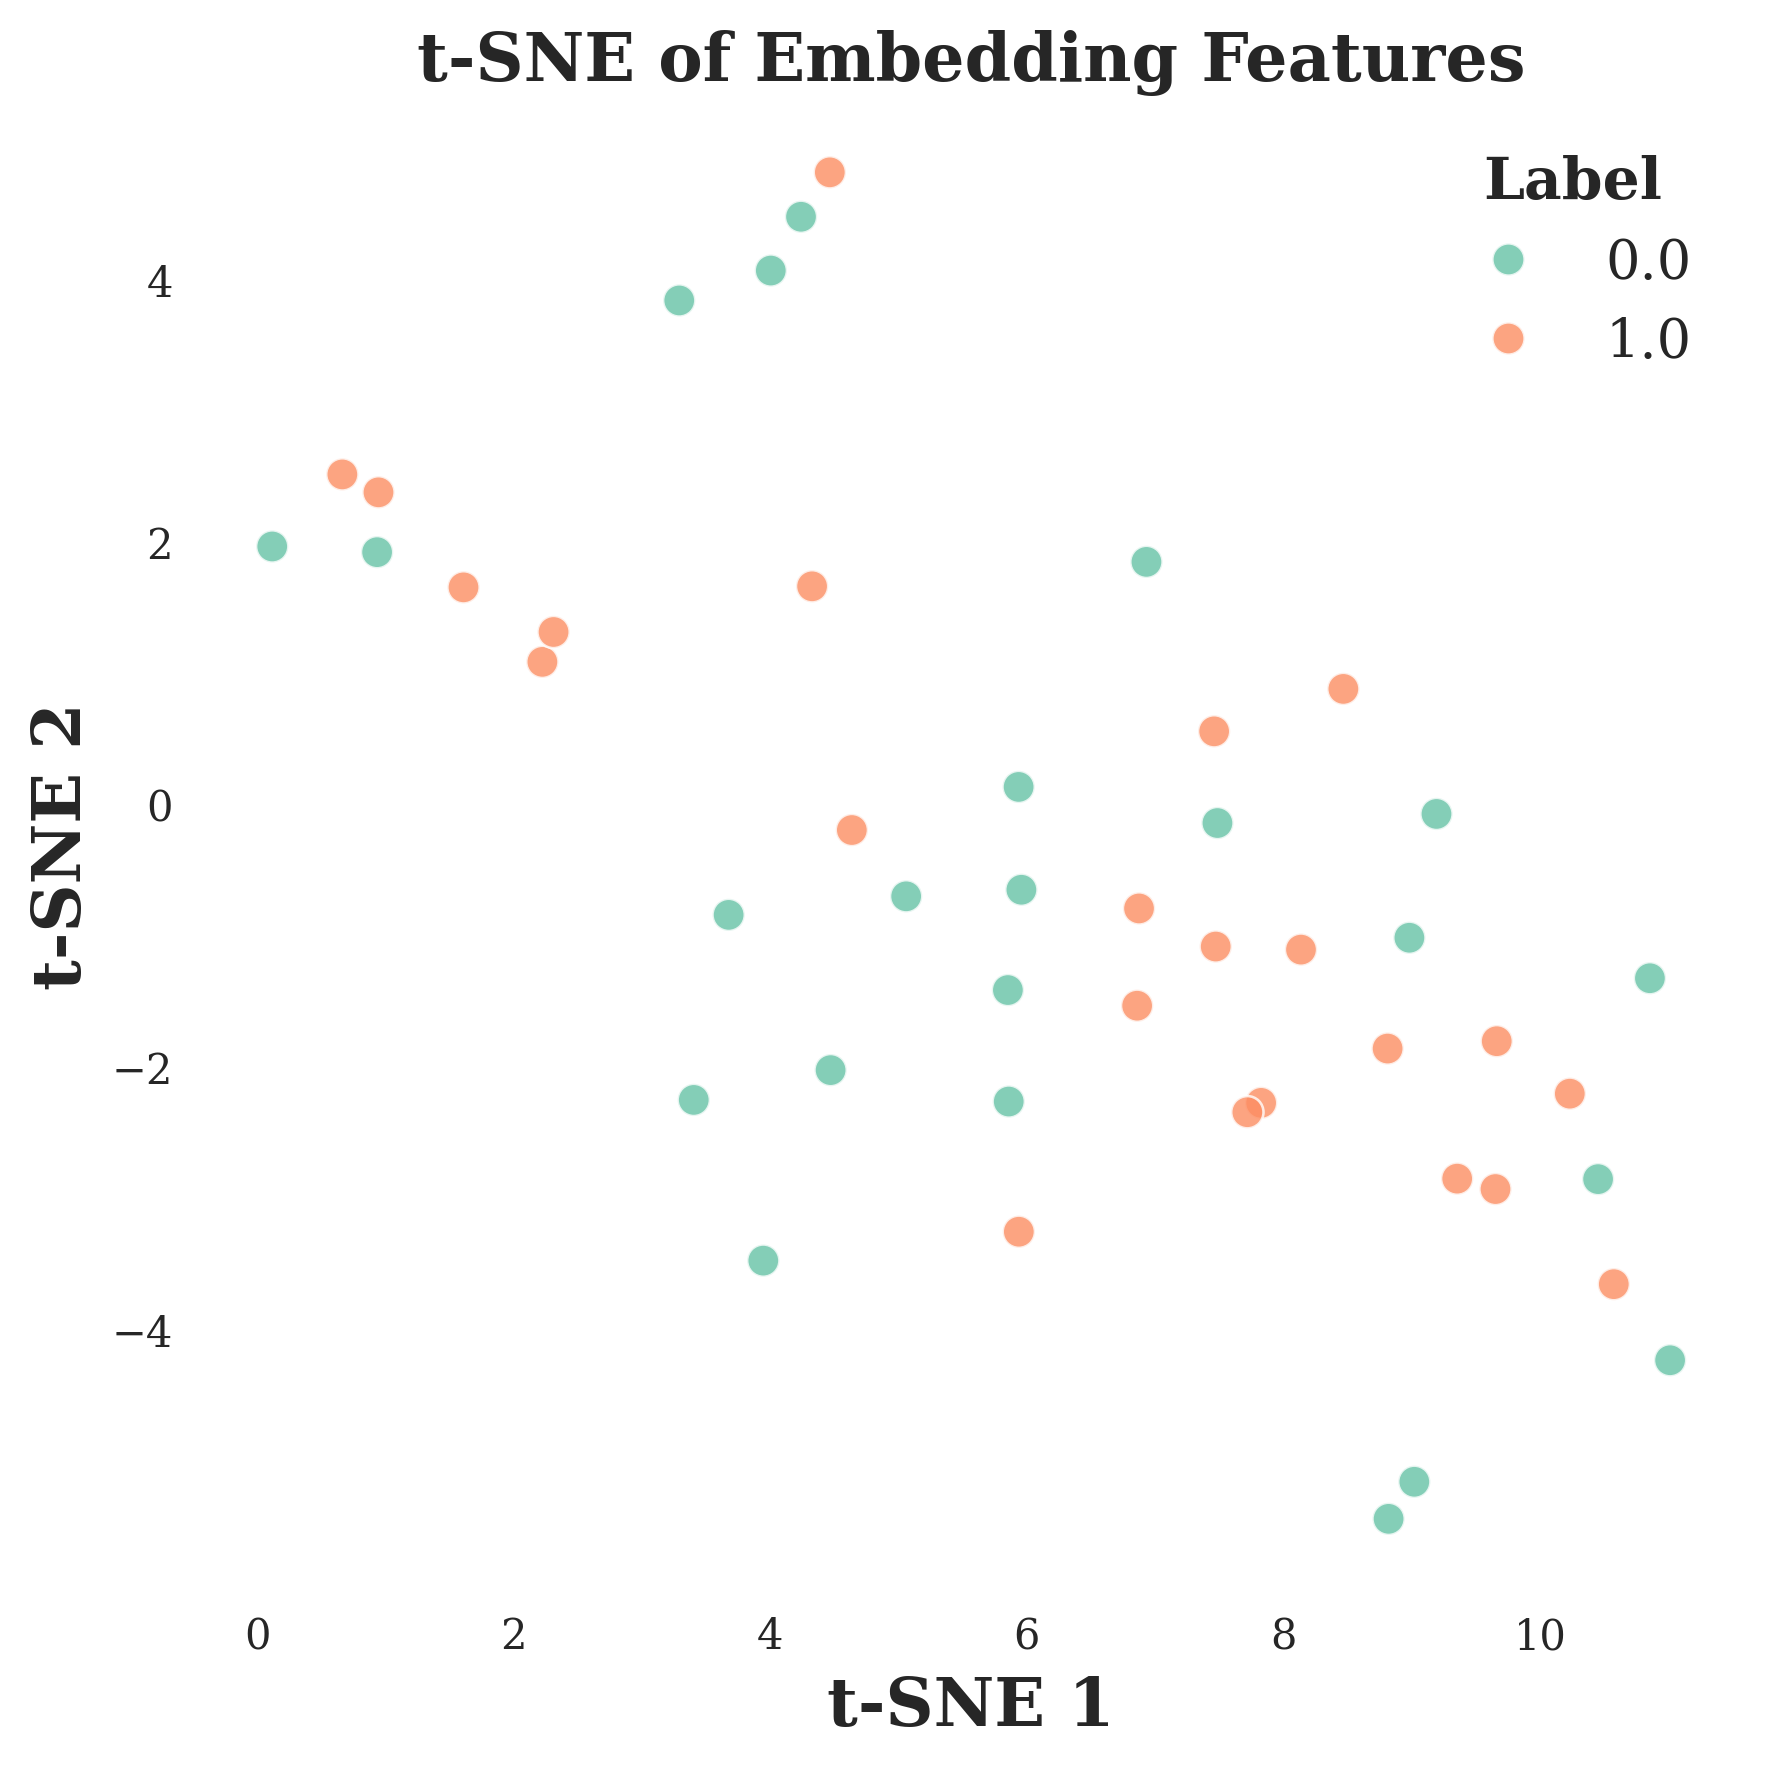

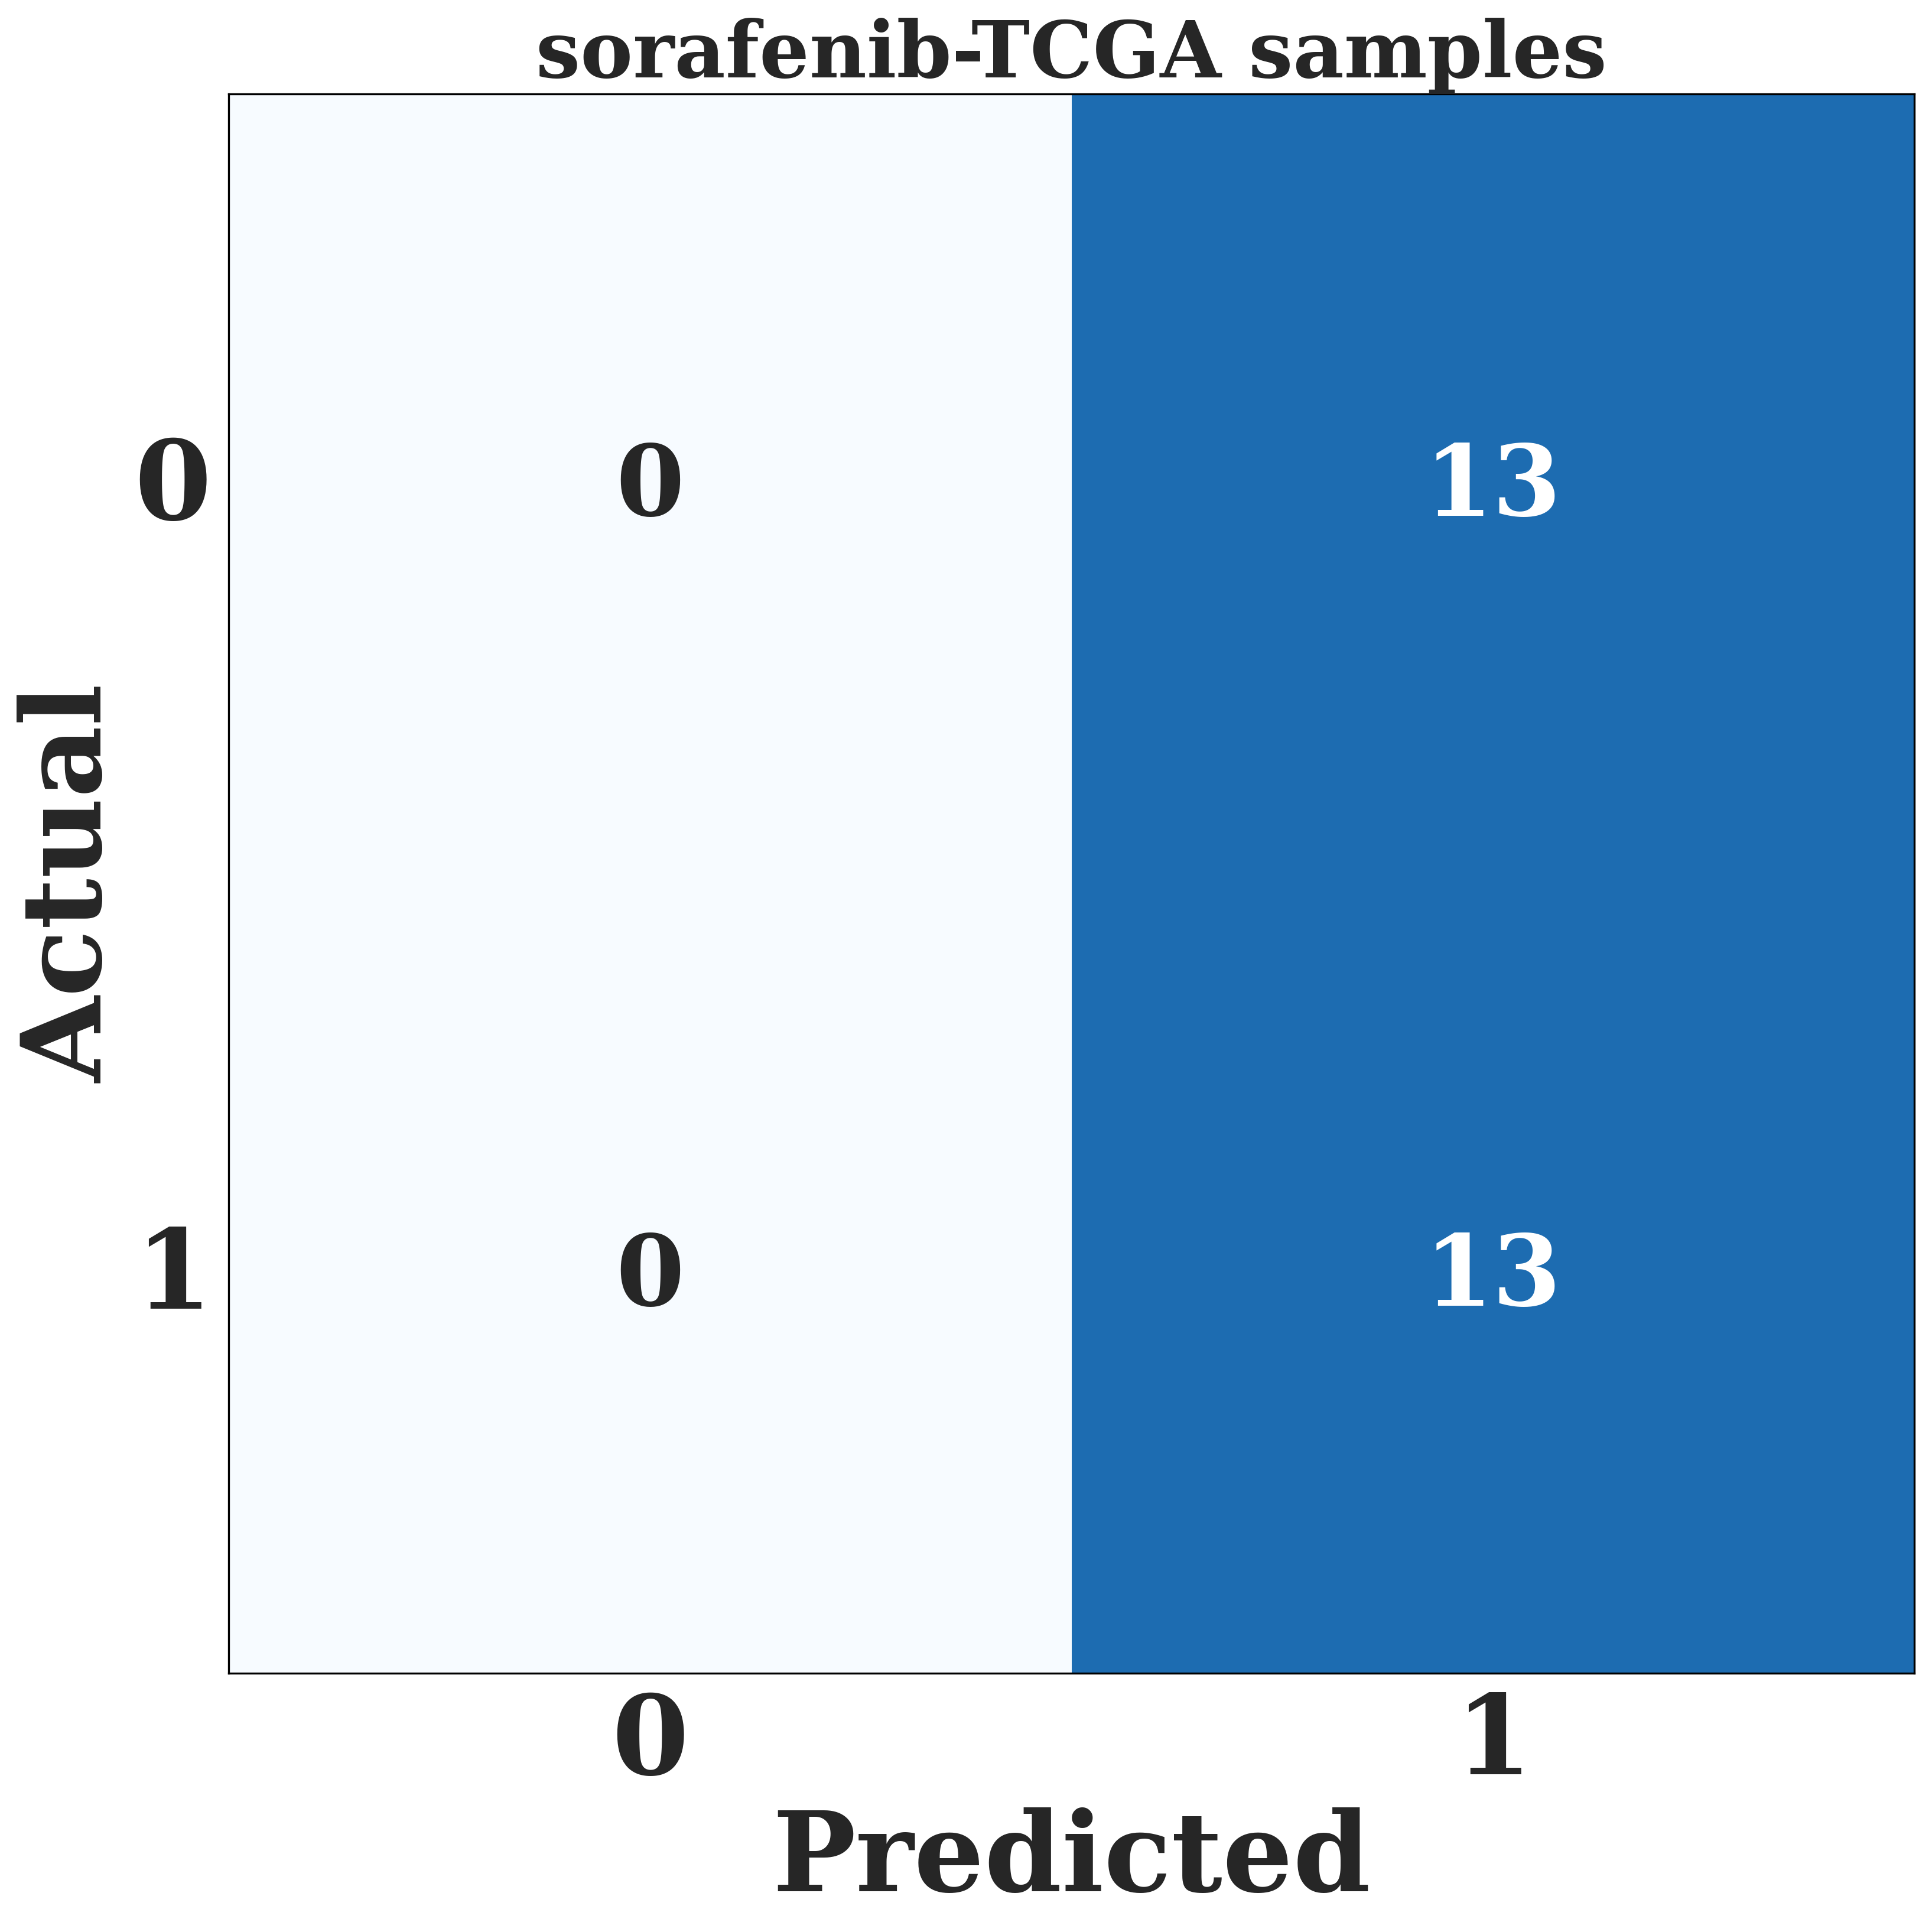

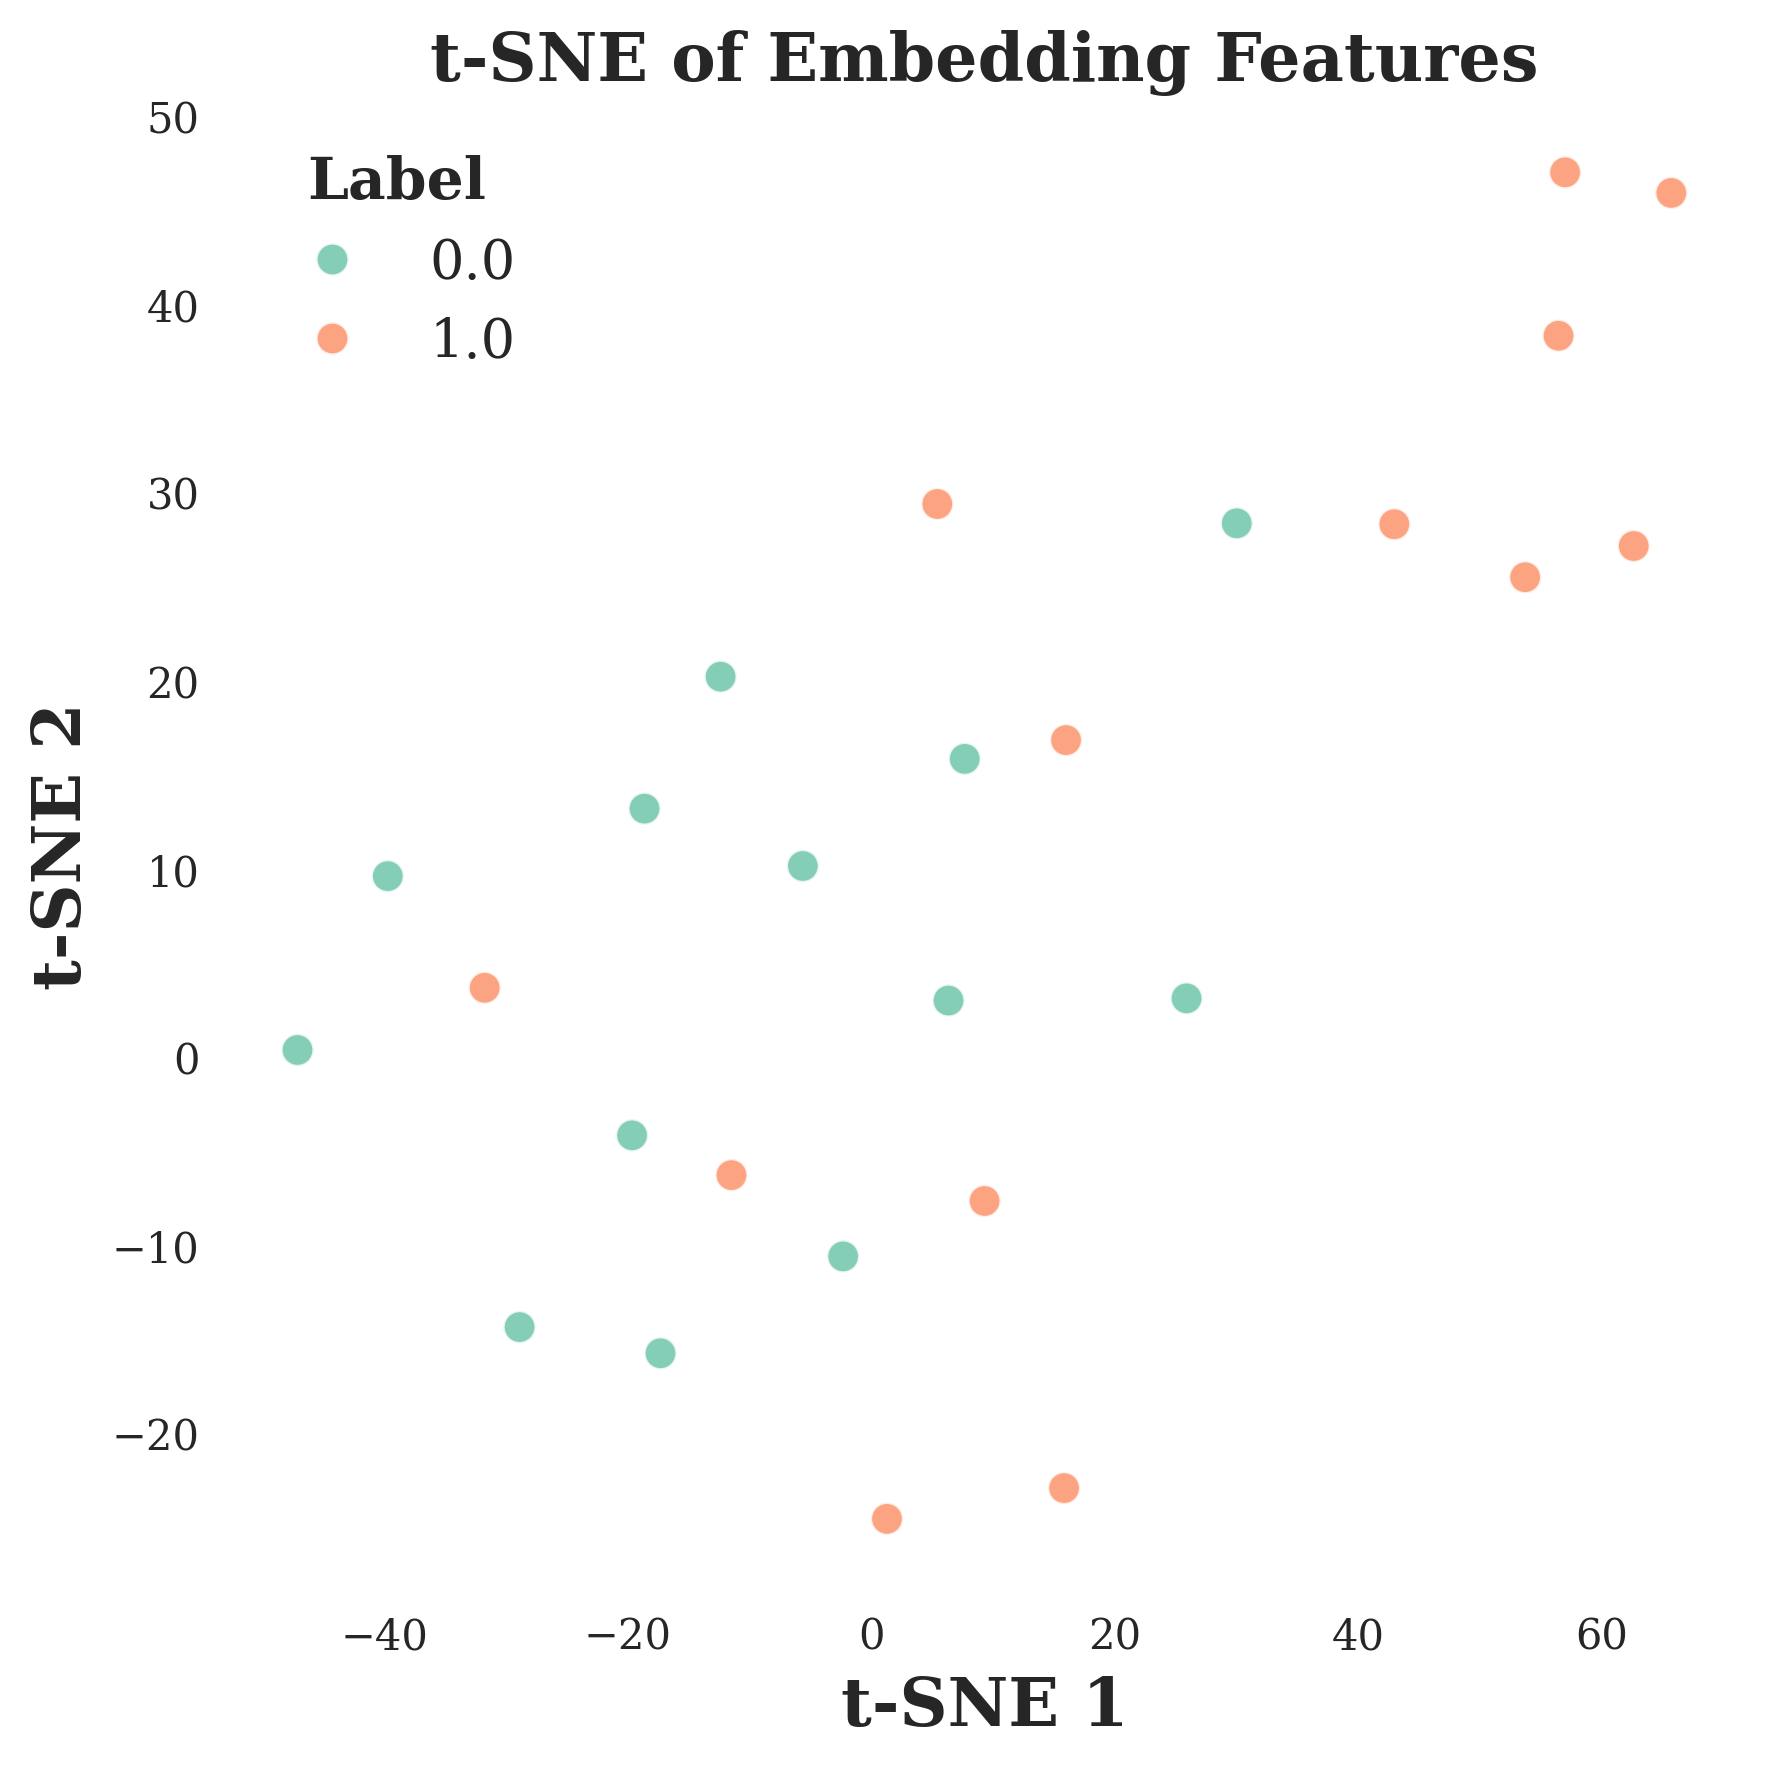

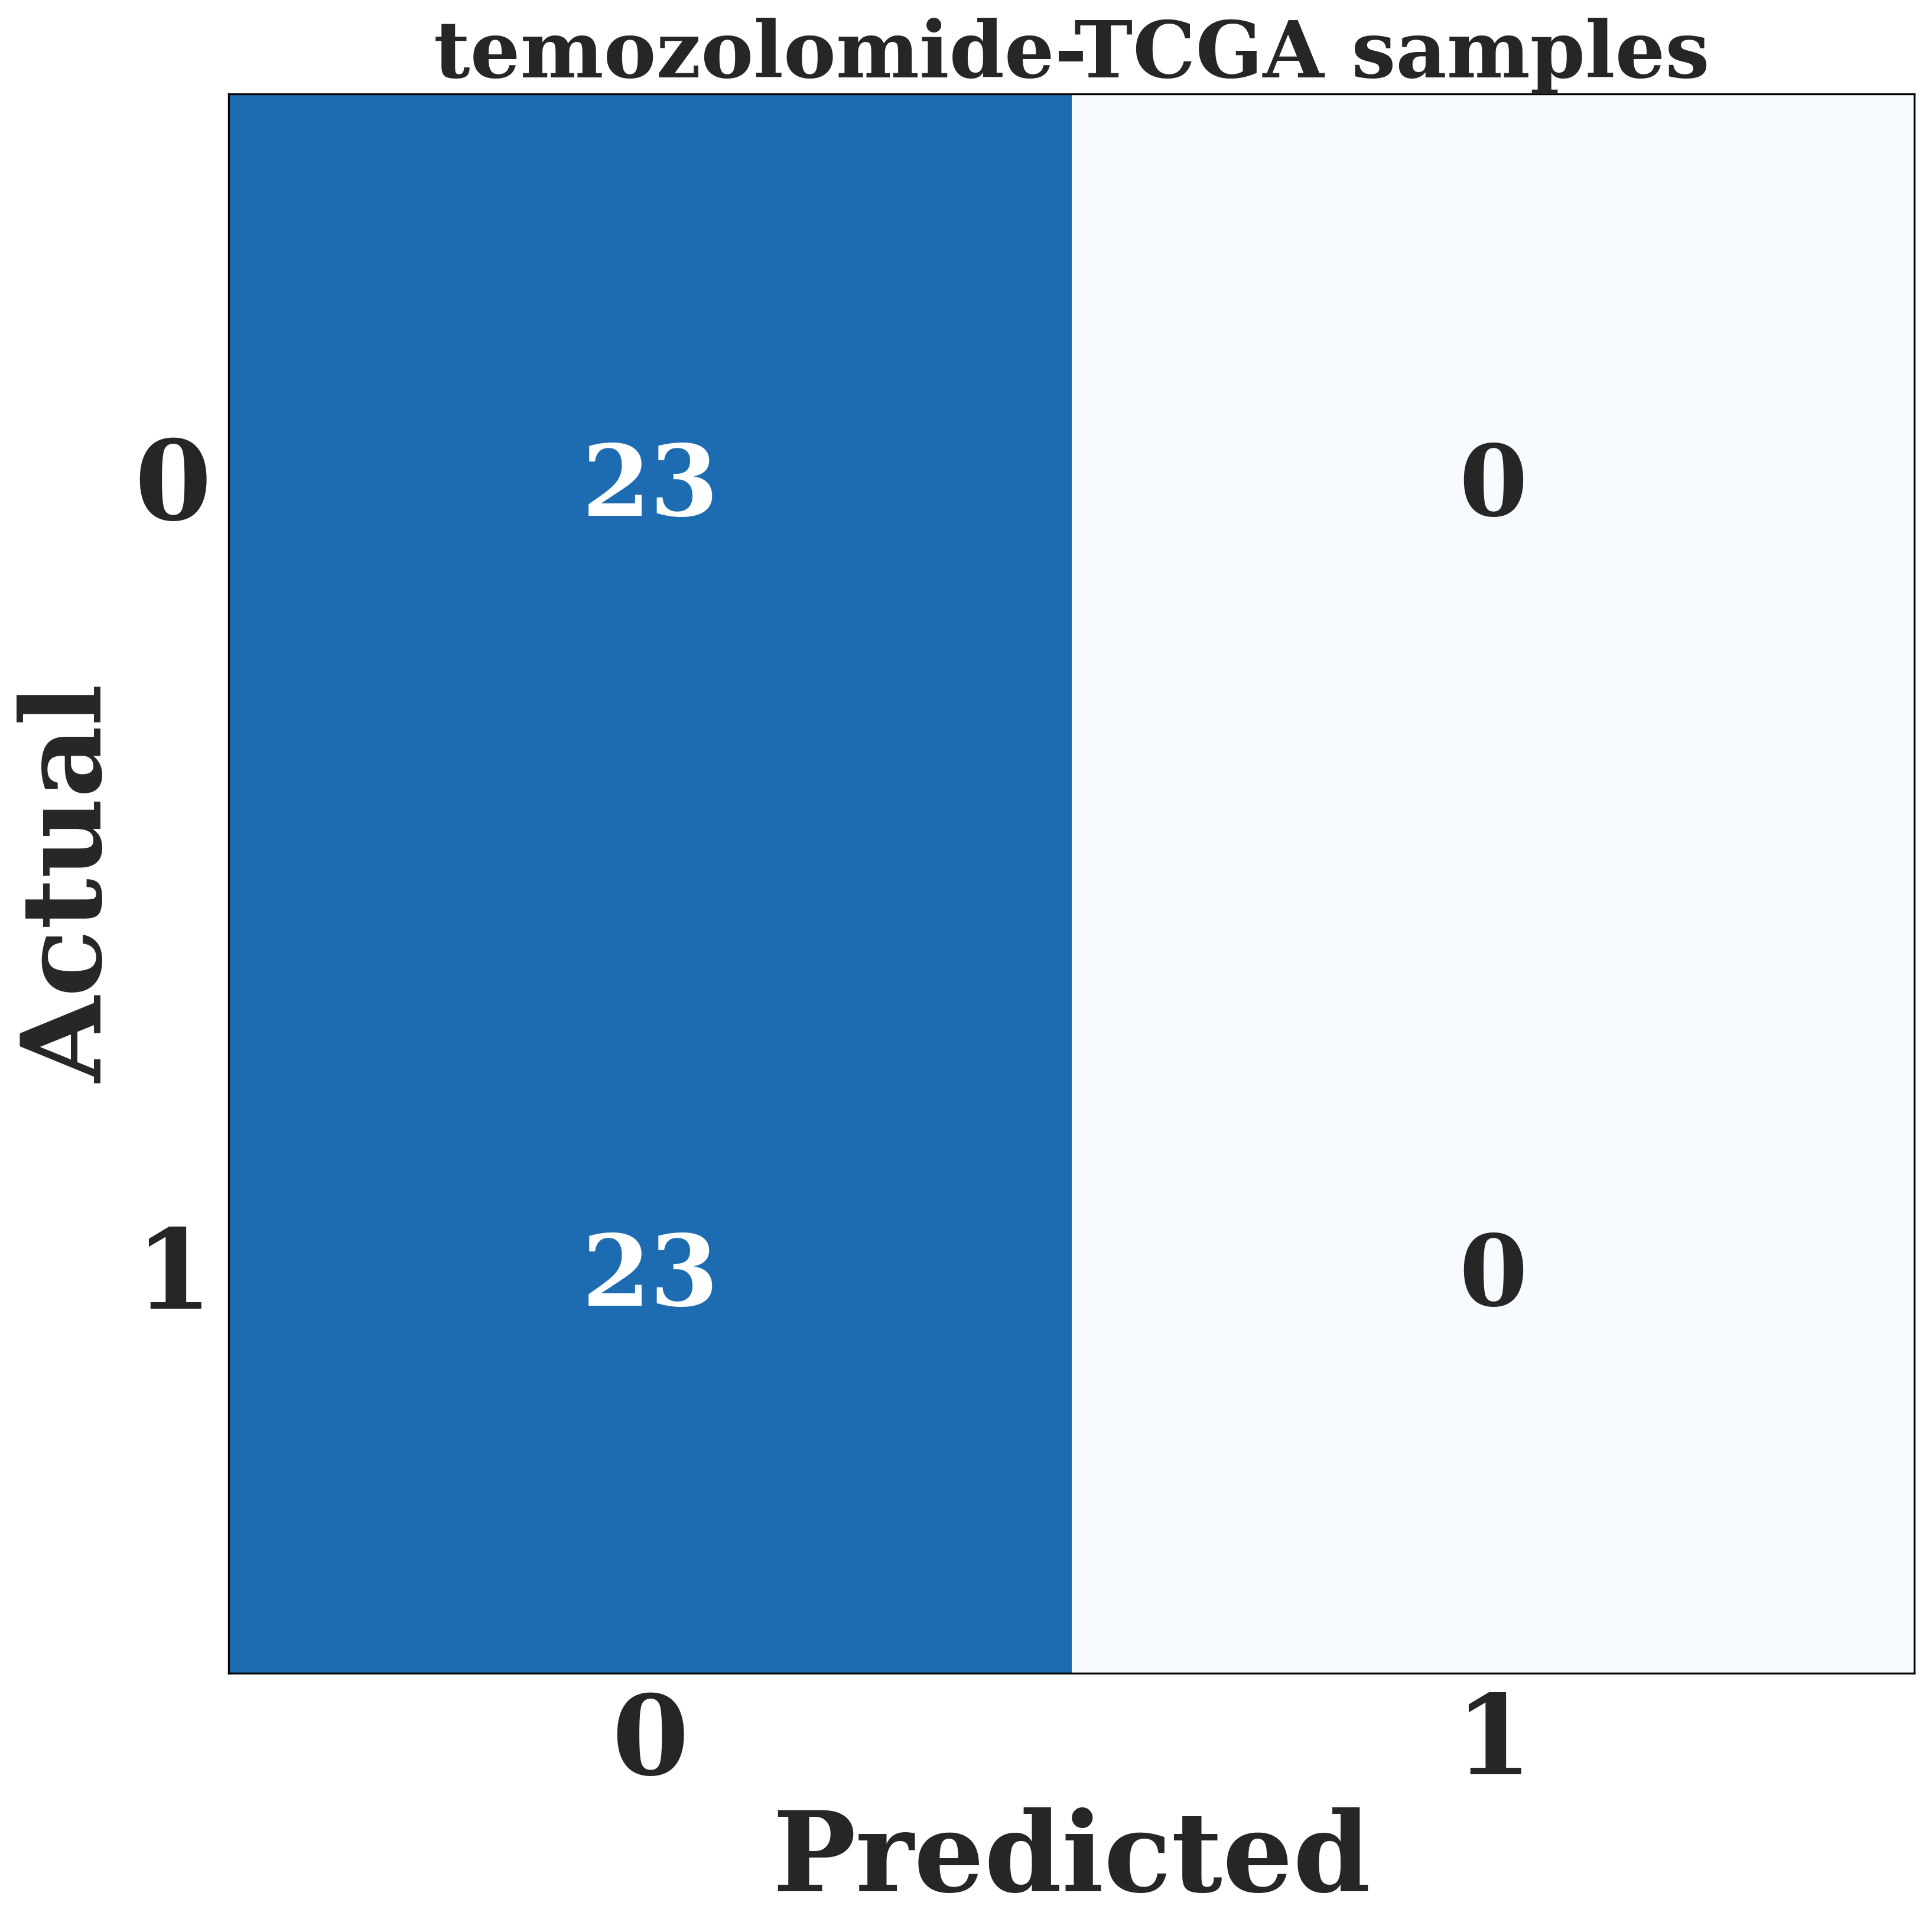

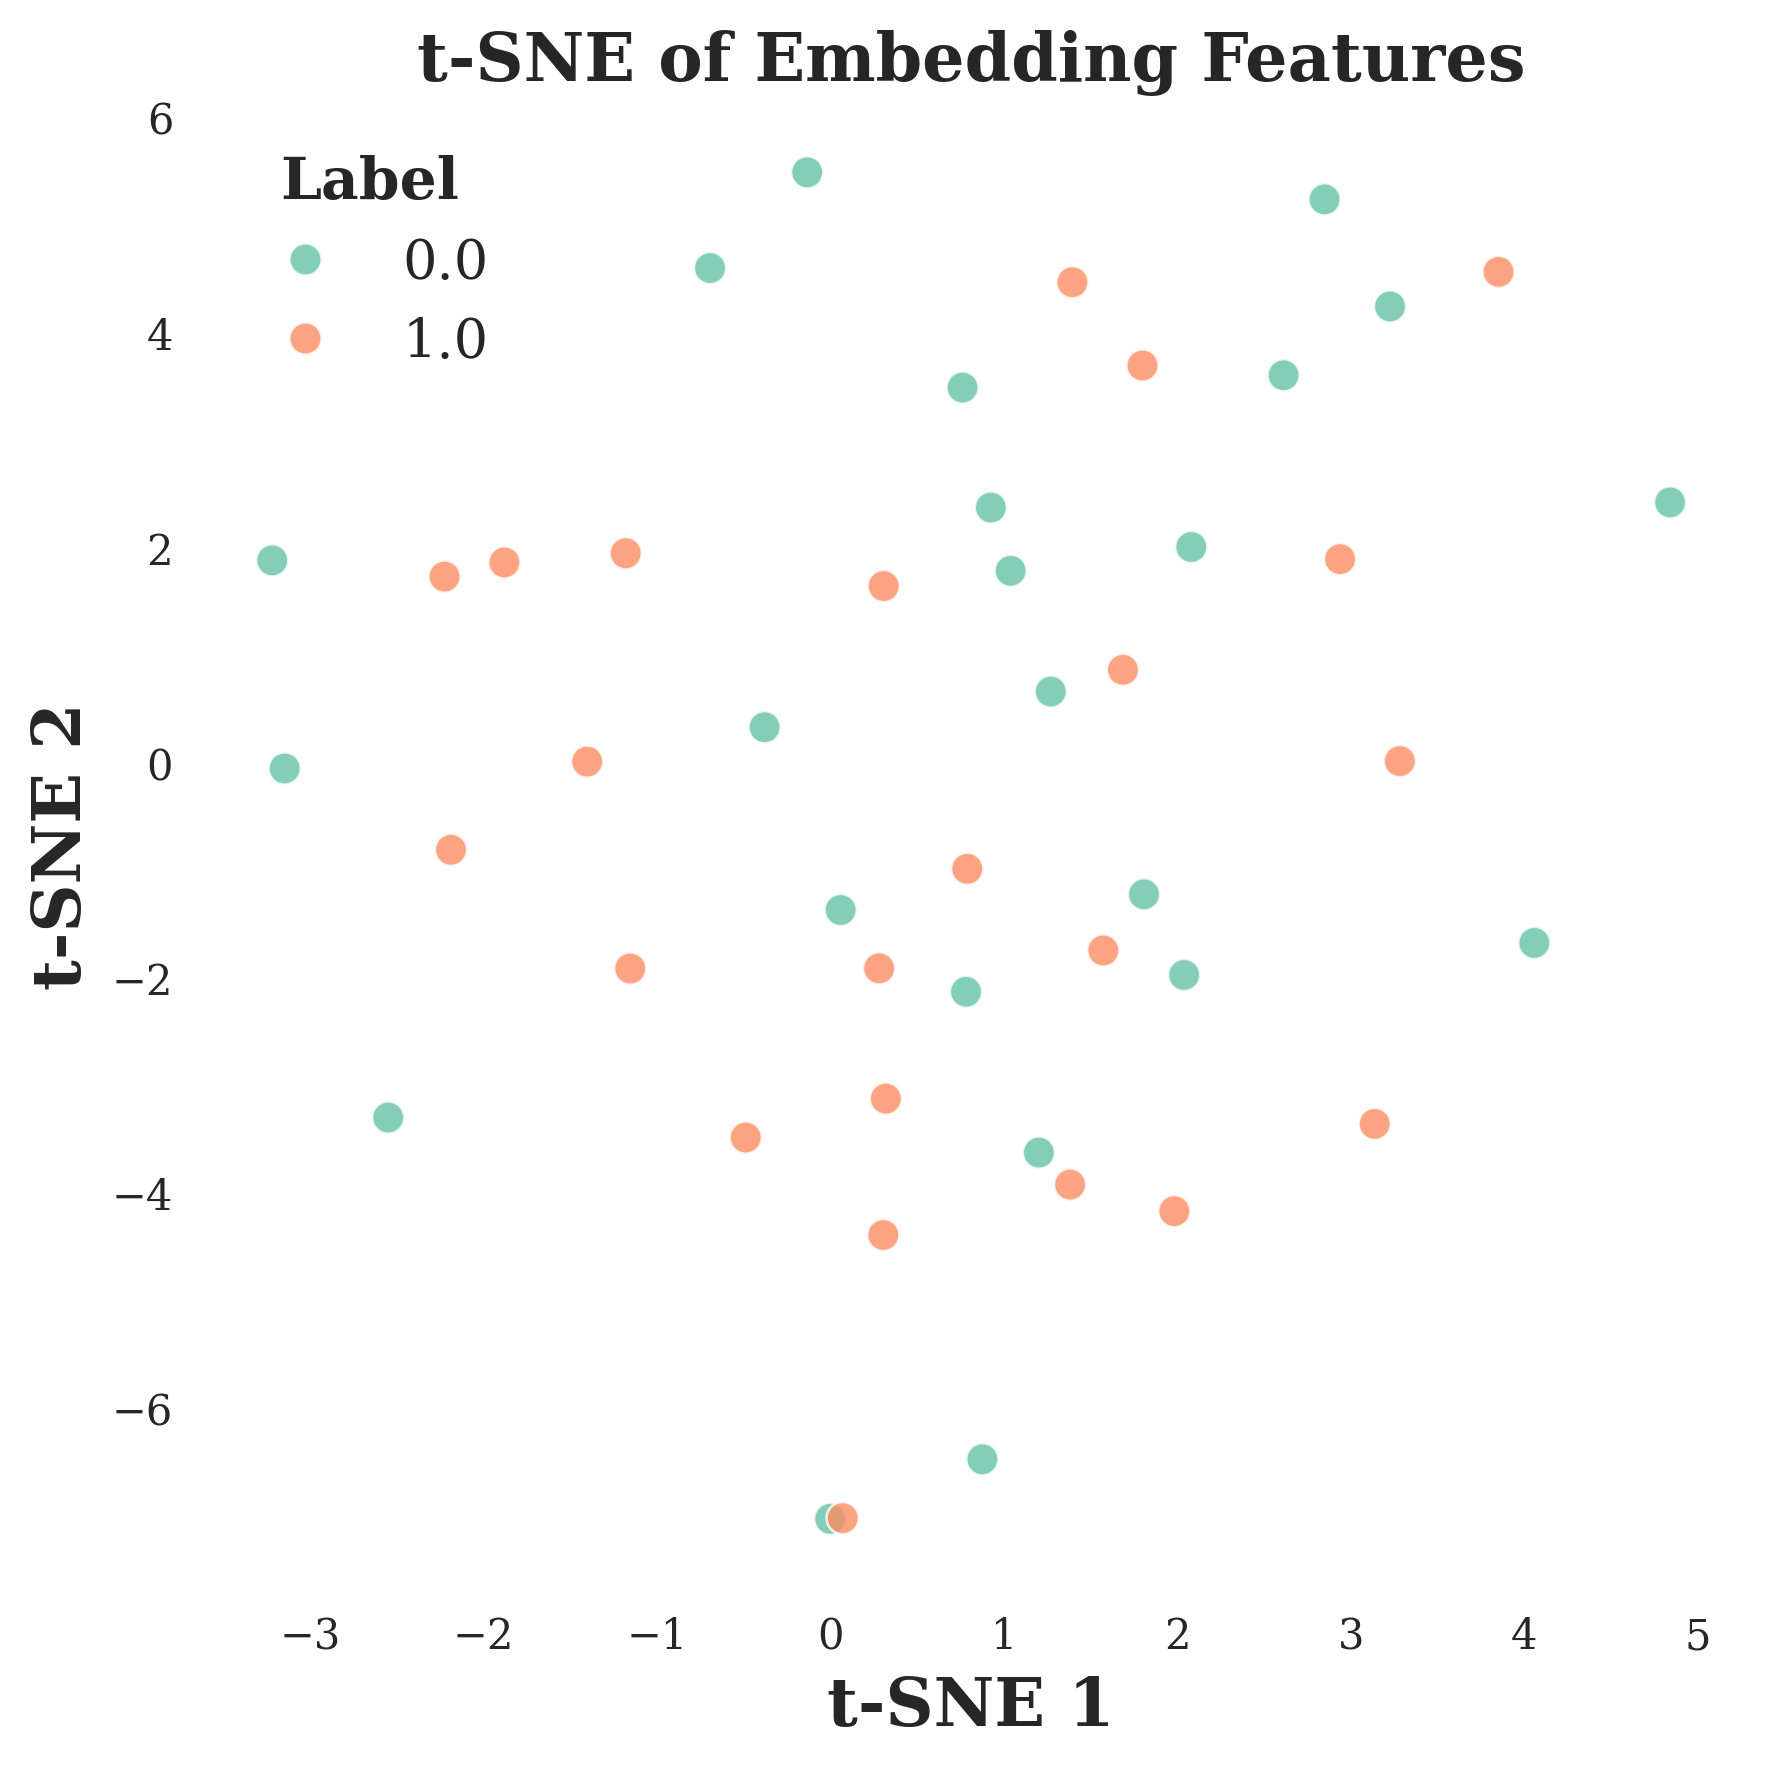

In [49]:
if model_inference is True:
    set_seed(seed)
    if model_name == "Omics_DrugESPF_Model":
        model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer, DA_Folder, TCGA_pretrain_weight_path_dict= None)
    elif model_name == "Omics_DCSA_Model":
        model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer, DA_Folder, TCGA_pretrain_weight_path_dict= None)
    elif model_name == "GIN_DCSA_model":
        model = GIN_DCSA_model(omics_encode_dim_dict, activation_func,activation_func_final,dense_layer_dim, device,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, 
                            n_layer, DA_Folder,TCGA_pretrain_weight_path_dict=None)
    model.to(device=device)
    model.load_state_dict(best_weight) 
    drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"]
    drugs_metrics={}
    for drug_name in drug_list:
        if DA_Folder != 'None':
            with open(f"../data/DAPL/share/pretrain/{DA_Folder}/{cohort}/{drug_name}_latent_results.pkl", 'rb') as f:
                latent_dict = pickle.load(f)
                CohortExp_df = pd.DataFrame(latent_dict).T # 32
        else:
            CohortExp_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}data{geneNUM}.csv", sep=',', index_col=0) #1426
        label_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}label{geneNUM}.csv", sep=',')
        label_df.columns.values[0] = 'ModelID'
        label_df.columns.values[1] = 'Label'
        label_df['drug_name'] = drug_name
        # label_df = 1 - label_df # make label 0 to 1, 1 to 0 to match regressionpredicted output. after that 0: sensitive, 1: resistant
        CohortExp_df = CohortExp_df.sort_index(axis=0).sort_index(axis=1)
        print(f"{cohort}exp {drug_name}data",CohortExp_df.shape)
        label_df = label_df.sort_index(axis=0).sort_index(axis=1)
        print(f"label_df {drug_name}data",label_df.shape)
        for omic_type in include_omics:
            if DA_Folder != 'None':
                omics_data_dict["Exp"] = CohortExp_df
            else:
                if omic_type == "Exp":
                    scaler = scaler_dict[omic_type]
                    omics_data_dict[omic_type] = pd.DataFrame(scaler.transform(CohortExp_df),index=CohortExp_df.index,columns=CohortExp_df.columns) # use fitted CCLE scaler to transform TCGA data
            # omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
            omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]
            # print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
            print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])
#         drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA_MACCS.csv"
        drug_df = pd.read_csv( drug_df_path, sep=',')
        drug_df['name'] = drug_df['name'].str.lower()
        drug_df = drug_df.set_index('name', drop=False)
        # get specific drug and ccl
        drug_df = drug_df[drug_df['name'].str.lower() == drug_name.lower()]
        print(drug_df)
        if ESPF is True:
            print("drug_smiles",drug_df["SMILES"])
            # 挑出重複的SMILES
            duplicate =  drug_df["SMILES"][drug_df["SMILES"].duplicated(keep=False)]
            #ESPF
            vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
            sub_csv = pd.read_csv(ESPF_file)# token with frequency
            # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
            drug_df["drug_encode"] = pd.Series(drug_df["SMILES"]).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
#             print("drug_encode",type(drug_df["drug_encode"]))
            drug_df["drug_encode"] = [i[:2] for i in drug_df["drug_encode"].values]
            print(drug_df["drug_encode"] )
        else:
            drug_df["drug_encode"]=[list(map(int, item.split(','))) for item in drug_df["MACCS166bits"].values]
        #--------------------------------------------------------------------------------------------------------------------------
        num_ccl = list(omics_data_dict.values())[0].shape[0]
        num_drug = drug_df["drug_encode"].shape[0]
        print("num_ccl,num_drug: ",num_ccl,num_drug)
# Fc1c[nH]c(=O)[nH]c1=O 
        set_seed(seed)
        dataset = InstanceResponseDataset(label_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
        onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
        # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
        (eval_targets, eval_outputs,predAUCwithUnknownGT,
        AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
        eval_outputs_before_final_activation_list,   tSNE_embed_list,
        mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                                    criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                                    weighted_threshold, few_weight, more_weight, 
                                                    outputcontrol='inference')
        # Calculate classification metrics                                            
        drugs_metrics[drug_name], _  = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs), best_prob_threshold, metric, dataset="test")
        drugs_metrics[drug_name]["eval_targets"]=eval_targets
        drugs_metrics[drug_name]["eval_outputs"]=eval_outputs
        drugs_metrics[drug_name]["eval_outputs_before_final_activation_list"]=eval_outputs_before_final_activation_list
        drugs_metrics[drug_name][criterion.loss_type] = mean_batch_eval_loss_WO_penalty

        if 'BCE' in criterion.loss_type :
            (test_cm ,  test_GT_0_count, test_GT_1_count, 
            test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), best_prob_threshold)
            drugs_metrics[drug_name]["CM"] = test_cm
            # # plot confusion matrix
            cm_datas = [(test_cm, cohort, 'Blues')]
            Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=best_weight_path,drug=drug_name)
            tSNE_embed_datas = [(tSNE_embed_list,eval_targets, cohort, 'Blues')]
            tSNE_embed_plot(tSNE_embed_datas,hyperparameter_folder_path=best_weight_path,drug=drug_name)
            
        else:#regression use prob_threshold to get binary outcome
            df = pd.DataFrame({'predicted AUDRC': torch.cat(eval_outputs).cpu().numpy(),
                    'Label': torch.cat(eval_targets).cpu().numpy()})
            # Perform t-test between the two groups
            sensitive = df[df['Label'] == 1]['predicted AUDRC']
            resistant = df[df['Label'] == 0]['predicted AUDRC']
            t_stat, p_val = ttest_ind(sensitive, resistant)
            drugs_metrics[drug_name]["pvalue"]= p_val
            if p_val<=0.05:
                TCGA_predAUDRC_box_plot_twoClass(drug_name,cohort,df,sensitive,resistant,p_val,best_weight_path)
    output_file = f"{best_weight_path}/NEW_BF{BF}_{cohort}_inference_result.txt"
    with open(output_file, "w") as file:
        if 'BCE' in criterion.loss_type :
            for drug_name, metrics in drugs_metrics.items():
                file.write(f"\n{drug_name}\n")
                file.write(f"BF_best_prob_threshold: {best_prob_threshold} according to {metric}\n")
                file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
                for key in metrics_type_set:
                    file.write(f"  '{key}': {metrics[key].item():.4f}\n")
                for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                    file.write(f"\n{key}\n{metrics[key][0][:20]}\n\n")
        else:
            for drug_name, metrics in drugs_metrics.items():
                file.write(f"{drug_name}\n")
                file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
                if metrics['pvalue'].item() <= 0.05:
                    file.write(f"\n pvalue <= 0.05 ")
                else:
                    file.write(f"\n pvalue > 0.05 ")
                file.write(f"{drug_name} pvalue: {metrics['pvalue'].item():.4f}\n\n")
                for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                    file.write(f"\n{key}\n{metrics[key][0][:20]}\n")       
#     os.chmod(output_file, 0o444)
    del model
    torch.cuda.set_device("cuda:0")# Set the current device
    gc.collect()# Optionally, force garbage collection to release memory 
    torch.cuda.empty_cache() # Empty PyTorch cache

In [ ]:
print("eval_targets\n",eval_targets[0][:10])
print("eval_outputs_before_final_activation_list\n",eval_outputs_before_final_activation_list[0][:10])
print("eval_outputs\n",eval_outputs[0][:10])
print("\n mean_batch_eval_lossWOpenalty",mean_batch_eval_lossWOpenalty)
eval_metrics= metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value=None)
print(eval_metrics)

In [ ]:
if splitType == "byCCL":
    id_unrepeat_whole = list(range(476))
elif splitType == "byDrug":
    id_unrepeat_whole = list(range(1440))
    id_unrepeat_whole[:10], id_unrepeat_whole[-10:]  # Display the first and last 10 elements to confirm

eval_pearson, eval_spearman,eval_AllSameValuesList_count  = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_whole,torch.cat(eval_targets),torch.cat(eval_outputs))

In [ ]:
#pearson
# Create a density plot using seaborn's kdeplot function
fig=plt.figure(figsize=(14, 5))
# Set the title of the plot

plt.subplot(1,2,1)
# sns.kdeplot(test_pearson1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_pearson, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Pearson\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 

plt.subplot(1,2,2)
#spearman
# Create a density plot using seaborn's kdeplot function
# sns.kdeplot(test_spearman1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_spearman, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Spearman\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 
fig.suptitle(f'Density Plot of Correlation {model_name}', fontsize=16)

In [ ]:
# for name, pearson in [("Test", test_pearson1)]:
#     print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
# for name, spearman in [("Test", test_spearman1)]:
#     print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")

for name, pearson in [("Test", eval_pearson)]:
    print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
for name, spearman in [("Test", eval_spearman)]:
    print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")


In [ ]:
datas = [(eval_targets, eval_outputs, 'test_set', 'red')] #[torch.tensor([], device='cuda:0')]
# plot Density_Plot_of_AUC_Values of train val test datasets
hyperparameter_folder_path = None
Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)

In [ ]:
predAUCmatrix_df = pd.read_csv(best_weight_path+"predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

In [ ]:
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list.txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
print((set(CCLtypeDF.index)-set(matched_samples)))
CCLtypeDF= (CCLtypeDF.T[matched_samples]).T
print(CCLtypeDF.shape)
Tissue_Type = ['Prostate', 'Ovary and Fallopian Tube', 'Esophagus and Stomach', 
                                    'Pancreas', 'Lung', 'Biliary Tract', 'CNS Brain', 'Breast',
                                    'Bladder or Urinary Tract', 'Thyroid', 'Kidney', 'Head and Neck',
                                    'Uterus', 'Bowel', 'Skin', 'Liver', 'Pleura']

dict = {"Tissue_Type":Tissue_Type, "MAE":[],"Sample_Size":[]}
for type in Tissue_Type:
    type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeLineage"] == type].tolist()
    pred_AUC = np.concatenate(predAUCmatrix_df.loc[type_indices].values)
    GT_AUC = np.concatenate(AUC_df.loc[type_indices].values)
    mask = ~np.isnan(GT_AUC)
    mse = np.mean((pred_AUC[mask] - GT_AUC[mask]) ** 2)
    mae = np.mean(np.abs(pred_AUC[mask] - GT_AUC[mask]))
    dict["MAE"].append(mae)
    dict["Sample_Size"].append(len(type_indices))
print(dict)

In [ ]:
combined_data = list(zip(dict['Tissue_Type'], dict['MAE'], dict['Sample_Size']))
# Sort the list by the MAE value (second element of each tuple)
sorted_dict = sorted(combined_data, key=lambda x: x[1])
# Unzip the sorted dict back into separate lists
sorted_tissue_type, sorted_mae, sorted_sample_size = zip(*sorted_dict)
# Convert back to lists
sorted_tissue_type = list(sorted_tissue_type)
sorted_mae = list(sorted_mae)
sorted_sample_size = list(sorted_sample_size)
# Update the dictionary with sorted values
sorted_data_dict = {'Tissue_Type': sorted_tissue_type,
                    'MAE': sorted_mae,
                    'Sample_Size': sorted_sample_size}
print(sorted_data_dict)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib as mpl
import seaborn as sns
plt.style.use('default')  # Use default style instead of seaborn
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (10, 10)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"
# 使用 t-SNE 做降維
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(features_np)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=features_2d[:, 0], y=features_2d[:, 1],
    hue=labels_np,
    palette='Set2', s=60, alpha=0.8)
plt.title("t-SNE of Embedding Features", fontsize=16,fontweight="bold")
plt.xlabel("t-SNE 1", fontsize=16,fontweight="bold")
plt.ylabel("t-SNE 2", fontsize=16,fontweight="bold")
leg = plt.legend(title="Label", fontsize=13, title_fontsize=14)
plt.setp(leg.get_title(), weight='bold')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.font_manager as fm
import matplotlib as mpl

# Set up high-quality rendering
plt.style.use('seaborn')  # Better default style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (8, 5)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"
data = pd.DataFrame(sorted_data_dict)
# Define bubble size
bubble_size = [10 if x <= 10 else
               50 if x <= 20 else
               130 if x <= 50 else
               300 for x in data['Sample_Size']]
# Create figure
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams["font.family"] = "serif"
# Scatter plot (bubble plot) with swapped axes
sc = ax.scatter(
    data['Tissue_Type'], data['MAE'], 
    s=bubble_size, c=data['MAE'], cmap='RdPu', vmin=0.043, vmax=0.060)
# Add colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.75)
cbar.ax.set_xlabel("MAE", fontsize=12, fontweight="bold", labelpad=10)
cbar.ax.xaxis.set_label_position("top") 
cbar.ax.xaxis.set_label_coords(2.5, 1.1)
cbar.outline.set_visible(False)  # Remove boundary/frame of colorbar 
# Legend for sample sizes
legend_sizes = [10, 50, 130, 300]  # Reference sizes
legend_labels = ["<= 10", "<= 20", "<= 50", "> 50"]
legend_handles = [
    plt.scatter([], [], s=size, color='black', label=label)
    for size, label in zip(legend_sizes, legend_labels)]
legend = ax.legend(
    handles=legend_handles, title="Cell line number",title_fontproperties=fm.FontProperties(weight='bold'),
    bbox_to_anchor=(1.2, 0.1),
    handlelength=2.5, handleheight=2.0)
legend.get_frame().set_visible(False)
# Adjust layout to prevent cropping
plt.tight_layout(rect=[0, 0, 1.8, 1.1])
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
# Swap x and y labels
plt.xlabel("Cancer Primary Tissue", fontsize=13, fontweight="bold", labelpad=18)

plt.ylabel("MAE",rotation=0, fontsize=12, fontweight="bold", labelpad=-30, loc='top')

# Adjust x-ticks if needed
plt.xticks(rotation=55, ha='right', rotation_mode='anchor', fontweight="bold")  # Rotate for better readability
# Remove the boundary/frame of the plot
for spine in plt.gca().spines.values():
    spine.set_color('gray')  
    spine.set_linewidth(1)
plt.show()
plt.savefig('./inference/high_quality_MAE horizontal plot.png', format='png', dpi=300)  # High-res raster

# classification TCGA by cancer type

In [ ]:
target_to_source_map = {
        'acute myeloid leukemia': 'na', #Only solid tumors
        'adrenocortical cancer': 'na',
        'bladder urothelial carcinoma': 'Bladder Cancer',
        'brain lower grade glioma': 'Brain Cancer',
        'breast invasive carcinoma': 'Breast Cancer',
        'cervical & endocervical cancer': 'Cervical Cancer',
        'cholangiocarcinoma': 'Bile Duct Cancer',
        'colon adenocarcinoma': 'Colon/Colorectal Cancer',
        'diffuse large B-cell lymphoma': 'na', #Only solid tumors
        'esophageal carcinoma': 'Esophageal Cancer',
        'glioblastoma multiforme': 'Brain Cancer',
        'head & neck squamous cell carcinoma': 'Head and Neck Cancer',
        'kidney chromophobe': 'Kidney Cancer',
        'kidney clear cell carcinoma': 'Kidney Cancer',
        'kidney papillary cell carcinoma': 'Kidney Cancer',
        'liver hepatocellular carcinoma': 'Liver Cancer',
        'lung adenocarcinoma': 'Lung Cancer',
        'lung squamous cell carcinoma': 'Lung Cancer',
        'mesothelioma': 'na',
        'ovarian serous cystadenocarcinoma': 'Ovarian Cancer',
        'pancreatic adenocarcinoma': 'Pancreatic Cancer',
        'pheochromocytoma & paraganglioma': 'na',
        'prostate adenocarcinoma': 'Prostate Cancer',
        'rectum adenocarcinoma': 'Colon/Colorectal Cancer',
        'sarcoma': 'Sarcoma',
        'skin cutaneous melanoma': 'Skin Cancer',
        'stomach adenocarcinoma': 'Gastric Cancer',
        'testicular germ cell tumor': 'na',
        'thymoma': 'na',
        'thyroid carcinoma': 'Thyroid Cancer',
        'uterine carcinosarcoma': 'Endometrial/Uterine Cancer',
        'uterine corpus endometrioid carcinoma': 'Endometrial/Uterine Cancer',
        'uveal melanoma': 'Eye Cancer'
    }

In [ ]:
tcga_type_df= pd.read_csv("../data/DAPL/share/xena_sample_info_df.csv", sep=',')
tcga_type_df.rename(columns={tcga_type_df.columns[0]: 'ModelID'}, inplace=True)
tcga_type_df.rename(columns={tcga_type_df.columns[3]: 'primary_disease'}, inplace=True)
tcga_type_df['ModelID']=tcga_type_df['ModelID'].str.slice(0, -3)
tcga_type_df["primary_disease"] = tcga_type_df["primary_disease"].map(target_to_source_map)
tcga_type_df

# information
struct_time   = time.localtime()
timestamp    = time.strftime("%Y-%m%d-%H%M", struct_time)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"on device {device}.")

set_seed(seed)
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,DA_Folder,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,DA_Folder,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
model.to(device=device)
model.load_state_dict(best_weight) 
drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"]
drugs_metrics={}
for drug_name in drug_list:
    if DA_Folder != 'None':
        with open(f"../data/DAPL/share/pretrain/{DA_Folder}/{cohort}/{drug_name}_latent_results.pkl", 'rb') as f:
            latent_dict = pickle.load(f)
            CohortExp_df = pd.DataFrame(latent_dict).T # 32
    else:
        CohortExp_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}data{geneNUM}.csv", sep=',', index_col=0) #1426
    label_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}label{geneNUM}.csv", sep=',')
    # print(label_df)
    label_df.columns.values[0] = 'ModelID'
    label_df.columns.values[1] = 'Label'
    label_df['drug_name'] = drug_name
    label_df = label_df.merge(tcga_type_df[['ModelID', 'primary_disease']], on='ModelID', how='left')
    counts = label_df['primary_disease'].value_counts()    # Step 1: 計算每種 primary_disease 的出現次數
    print("counts",counts)
    diseases_to_analyze = counts[counts > 10].index.tolist()    # Step 2: 選出出現次數大於 10 的疾病
    label_df = label_df[label_df['primary_disease'].isin(diseases_to_analyze)]    # Step 3: 篩選出這些疾病的資料
    CohortExp_df = CohortExp_df.sort_index(axis=0).sort_index(axis=1)
    print(f"{cohort}exp {drug_name}data",CohortExp_df.shape)
    label_df = label_df.sort_index(axis=0).sort_index(axis=1)
    print(f"label_df {drug_name}data",label_df.shape)
    for disease in diseases_to_analyze:    # Step 4: 針對每一個疾病類別做個別分析
        drug_deisease_name = f"{drug_name}_{disease}"
        disease_df = label_df[label_df['primary_disease'] == disease]
        print(f"disease_df {drug_name}data",disease_df.shape)
        for omic_type in include_omics:
            if DA_Folder != 'None':
                omics_data_dict["Exp"] = CohortExp_df
            else:
                if omic_type == "Exp":
                    scaler = scaler_dict[omic_type]
                    omics_data_dict[omic_type] = pd.DataFrame(scaler.transform(CohortExp_df),index=CohortExp_df.index,columns=CohortExp_df.columns) # use fitted CCLE scaler to transform TCGA data
            omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]
            print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])
#       drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA_MACCS.csv"
        drug_df = pd.read_csv( drug_df_path, sep=',')
        drug_df['name'] = drug_df['name'].str.lower()
        drug_df = drug_df.set_index('name', drop=False)
        # get specific drug and ccl
        drug_df = drug_df[drug_df['name'].str.lower() == drug_name.lower()]
        print(drug_df)
        if ESPF is True:
            print("drug_smiles",drug_df["SMILES"])
            # 挑出重複的SMILES
            duplicate =  drug_df["SMILES"][drug_df["SMILES"].duplicated(keep=False)]
            #ESPF
            vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
            sub_csv = pd.read_csv(ESPF_file)# token with frequency
            # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
            drug_df["drug_encode"] = pd.Series(drug_df["SMILES"]).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
#             print("drug_encode",type(drug_df["drug_encode"]))
            drug_df["drug_encode"] = [i[:2] for i in drug_df["drug_encode"].values]
            print(drug_df["drug_encode"] )
        else:
            drug_df["drug_encode"]=[list(map(int, item.split(','))) for item in drug_df["MACCS166bits"].values]
        #--------------------------------------------------------------------------------------------------------------------------
        num_ccl = list(omics_data_dict.values())[0].shape[0]
        num_drug = drug_df["drug_encode"].shape[0]
        print("num_ccl,num_drug: ",num_ccl,num_drug)# Fc1c[nH]c(=O)[nH]c1=O 
        def collate_fn(batch):
            gene_feature, drug_list, target = zip(*batch)
            return list(gene_feature), list(drug_list), list(target)
        set_seed(seed)
        print(device,device)
        print("disease_df:",disease_df.shape,"omics_data_dict['Exp']:",omics_data_dict['Exp'].shape,"drug_df:",drug_df.shape,"include_omics:",include_omics )
        dataset = InstanceResponseDataset(disease_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
        onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
        # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
        (eval_targets, eval_outputs,predAUCwithUnknownGT, 
        AttenScorMat_DrugSelf,AttenScorMat_DrugCellSelf,
        eval_outputs_before_final_activation_list, tSNE_embed_list,
         mean_batch_eval_loss_WO_penalty)= evaluation(model, None,None,
                                                     criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                                     weighted_threshold, few_weight, more_weight, 
                                                     outputcontrol='inference')
        # Calculate classification metrics                                            
        drugs_metrics[drug_deisease_name], _  = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs), best_prob_threshold, metric, dataset="test")
        drugs_metrics[drug_deisease_name]["eval_targets"]=eval_targets
        drugs_metrics[drug_deisease_name]["eval_outputs"]=eval_outputs
        drugs_metrics[drug_deisease_name]["eval_outputs_before_final_activation_list"]=eval_outputs_before_final_activation_list
        drugs_metrics[drug_deisease_name][criterion.loss_type] = mean_batch_eval_loss_WO_penalty

        if 'BCE' in criterion.loss_type :
            (test_cm ,  test_GT_0_count, test_GT_1_count, 
            test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), best_prob_threshold)

            drugs_metrics[drug_deisease_name]["CM"] = test_cm
            # # plot confusion matrix
            import matplotlib.font_manager as fm
            import matplotlib as mpl
            plt.style.use('default') # Revert style to default
            plt.rcParams.update(mpl.rcParamsDefault) # Revert all rcParams to their defaults
            cm_datas = [(test_cm, disease, 'Blues')]
            Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=best_weight_path,drug=drug_name)
            tSNE_embed_datas = [(tSNE_embed_list,eval_targets, disease, 'Blues')]
            tSNE_embed_plot(tSNE_embed_datas,hyperparameter_folder_path=best_weight_path,drug=drug_name)
            

        else:#regression use prob_threshold to get binary outcome
            df = pd.DataFrame({'predicted AUDRC': torch.cat(eval_outputs).cpu().numpy(),
                    'Label': torch.cat(eval_targets).cpu().numpy()})
            # Perform t-test between the two groups
            sensitive = df[df['Label'] == 1]['predicted AUDRC']
            resistant = df[df['Label'] == 0]['predicted AUDRC']
            t_stat, p_val = ttest_ind(sensitive, resistant)
            drugs_metrics[drug_deisease_name]["pvalue"]= p_val
            if p_val<=0.05:
                TCGA_predAUDRC_box_plot_twoClass(drug_name,cohort,df,sensitive,resistant,p_val,best_weight_path)
        # not a reasonable way to calculate AUROC and AUPRC to explain the model performance

output_file = f"{best_weight_path}/{cohort}_inference_result.txt"
with open(output_file, "w") as file:
    if 'BCE' in criterion.loss_type :
        for drug_deisease_name, metrics in drugs_metrics.items():
            file.write(f"\n{drug_deisease_name}\n")
            file.write(f"best_prob_threshold: {best_prob_threshold} according to {metric}\n")
            file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
            for key in metrics_type_set:
                file.write(f"  '{key}': {metrics[key].item():.4f}\n")
            for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                file.write(f"\n{key}\n{metrics[key][0][:20]}\n\n")
    else:
        for drug_deisease_name, metrics in drugs_metrics.items():
            file.write(f"{drug_deisease_name}\n")
            file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
            if metrics['pvalue'].item() <= 0.05:
                file.write(f"\n pvalue <= 0.05 ")
            else:
                file.write(f"\n pvalue > 0.05 ")
            file.write(f"{drug_deisease_name} pvalue: {metrics['pvalue'].item():.4f}\n\n")
            for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                file.write(f"\n{key}\n{metrics[key][0][:20]}\n")

In [22]:
def Confusion_Matrix_plot(datasets,hyperparameter_folder_path=None,drug=None):
    plt.rcParams["font.family"] = "serif"
    if len(datasets)==1:
        fig, ax = plt.subplots(figsize=(12,12))
        cm, title, color = datasets[0]
        sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"}, 
                    cmap=color, cbar=False, vmin=0, vmax=max(cm.max() * 1.3, 1), linewidths=0,
                    xticklabels=["0", "1"], yticklabels=["0", "1"], ax=ax) # xticklabels=["Predicted  0", "Predicted  1"], yticklabels=["Actual  0", "Actual  1"]
        if drug is not None:
            ax.set_title(f'{drug}-{title} samples',fontsize=32, fontweight='bold')
        else:
            ax.set_title(f'{title} samples',fontsize=32, fontweight='bold')
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.8)
            spine.set_edgecolor('black')
        # Make x and y tick labels bold
        ax.tick_params(axis='x', labelsize=45, labelrotation=0)
        ax.tick_params(axis='y', labelsize=45, labelrotation=0)
        ax.set_xlabel("Predict", fontsize=45, fontweight='bold', fontname="serif")
        ax.set_ylabel("Actual", fontsize=45, fontweight='bold', fontname="serif")
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        if hyperparameter_folder_path is not None:
            output_file = os.path.join(hyperparameter_folder_path, f'{drug}-{title} Confusion_Matrix.png')
            try:
                fig.savefig(output_file)
#                 os.chmod(output_file, 0o444)
                print(f"✅ Set read-only permissions on: {output_file}")
            except Exception as e:
                print(f"⚠️ Failed to set permissions: {e}")
    return plt

## boxplot

In [ ]:
ccl_cancer_type = "COAD"
ccl_type = ccl_cancer_type
drug_name = 'FLUOROURACIL (BRD:BRD-K24844714-001-24-5)'
drug_name_short = 'Fluorouracil'
# ENCORAFENIB (BRD:BRD-A56085258-001-01-8): inhibit the mutated BRAF protein
# BINIMETINIB (BRD:BRD-K82244583-001-01-3): inhibit the MEK pathway
# FLUOROURACIL (BRD:BRD-K24844714-001-24-5): TP53
inhibit_Gene = "TP53" # TP53 BRAF KRAS

In [ ]:
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list(TCGA).txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
match = sorted(set(CCLtypeDF.index) & set(matched_samples))
print(len(match))
CCLtypeDF= (CCLtypeDF.T[match]).T
print(CCLtypeDF.shape)
type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeCode"] == ccl_cancer_type].tolist()
print(len(type_indices),"\n",type_indices)
print(predAUCmatrix_df.loc[type_indices])

In [ ]:
# get GT AUC of specific drug and type of ccl

GT_AUC_df_type_drug = (AUC_df.loc[type_indices])[[drug_name]]
print(np.concatenate(GT_AUC_df_type_drug.values).shape)

# get predicted AUC of sepecific drug and type of ccl
predAUCmatrix_df_type_drug = (predAUCmatrix_df.loc[type_indices])[[drug_name]]
print(np.concatenate(predAUCmatrix_df_type_drug.values).shape)
print(predAUCmatrix_df_type_drug.min())
print(predAUCmatrix_df_type_drug)


In [ ]:
# get specific mut gene label 0/1
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)
    omics_data_dict[omic_type] = omics_data_dict[omic_type].loc[type_indices] #  index of specific CCL type's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]).shape ) 
    if omic_type == "Mut":
        sample_mut_label = ((omics_data_dict[omic_type])[inhibit_Gene] == 1).astype(int).tolist()
        print(sample_mut_label)
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = StandardScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    

In [ ]:
# get mask from GT_AUC_df_type_drug and get GT_AUC_df_type_drug_dropnan
mask = ~np.isnan(np.concatenate(GT_AUC_df_type_drug.values))
print(mask)
GT_AUC_df_type_drug_dropnan = GT_AUC_df_type_drug.dropna()
GT_AUC_df_type_drug_dropnan.shape

In [ ]:
# get mutation label after mask for GT boxplot
GT_mut_label_masked=np.array(sample_mut_label)[mask] # 1:w ; 0:wo
print("GT_mut_label_masked",GT_mut_label_masked)
# turn 0/1 to 'w/o TP53_Mut'/'TP53_Mut'
GT_mut_label_masked = [f'{inhibit_Gene}_Mut' if label == 1 else f'w/o {inhibit_Gene}_Mut' for label in GT_mut_label_masked]
print(len(GT_mut_label_masked),"\n",GT_mut_label_masked)
sample_mut_label = [f'{inhibit_Gene}_Mut' if label == 1 else f'w/o {inhibit_Gene}_Mut' for label in sample_mut_label]
print("sample_mut_label\n",sample_mut_label)
print(len(sample_mut_label))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib as mpl

# Set up high-quality rendering
# plt.style.use('seaborn')  # Better default style
plt.style.use('default')  # Use default style instead of seaborn
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (15, 6)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'  # Explicitly set edge color
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')  # or any color you prefer
    spine.set_linewidth(1)  # adjust thickness as needed

# fig=plt.figure(figsize=(15,6))
plt.rcParams["font.family"] = "serif"
fig.suptitle(f'Comparison of {drug_name_short} treatment AUC response \n between {inhibit_Gene}-mutated and non-mutated {ccl_cancer_type} samples',fontsize=18, fontweight='bold',y=1.01,linespacing=1.5)

plt.subplot(1,2,1)
df = pd.DataFrame({'predicted AUC': np.concatenate(predAUCmatrix_df_type_drug.values) , 'mutation_status': sample_mut_label})
# Perform t-test
group1 = df[df["mutation_status"] == f'w/o {inhibit_Gene}_Mut']["predicted AUC"]
group2 = df[df["mutation_status"] == f'{inhibit_Gene}_Mut']["predicted AUC"]
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
custom_palette = {f'w/o {inhibit_Gene}_Mut': "royalblue", f'{inhibit_Gene}_Mut': "darkorange"}
ax = sns.boxplot(x="mutation_status", y="predicted AUC", data=df, palette=custom_palette)
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = df["predicted AUC"].max() + 0.002, 0.002  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.xticks([1, 0], [f'w/o {inhibit_Gene}_Mut (n={len(group1)})', f'{inhibit_Gene}_Mut (n={len(group2)})'], fontsize=15, fontweight='bold')
# plt.title(f'Comparison of {drug_name_short} treatment Predicted AUC \n between {inhibit_Gene}-mutated and non-mutated {ccl_cancer_type} samples',fontsize=18, fontweight='bold')
plt.xlabel('Mutation Status', fontsize=18, fontweight='bold', labelpad=11)
plt.ylabel('Predicted AUC', fontsize=20, fontweight='bold', labelpad=15)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)

plt.subplot(1,2,2)
GTdf = pd.DataFrame({'GroundTruth AUC': np.concatenate(GT_AUC_df_type_drug_dropnan.values) , 'mutation_status': GT_mut_label_masked})
group1 = GTdf[GTdf["mutation_status"] == f"w/o {inhibit_Gene}_Mut"]["GroundTruth AUC"]
group2 = GTdf[GTdf["mutation_status"] == f"{inhibit_Gene}_Mut"]["GroundTruth AUC"]
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
custom_palette = {f"w/o {inhibit_Gene}_Mut": "royalblue", f"{inhibit_Gene}_Mut": "darkorange"}
ax = sns.boxplot(x="mutation_status", y="GroundTruth AUC", data=GTdf, palette=custom_palette)
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = GTdf["GroundTruth AUC"].max() + 0.002, 0.002  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.xticks([1, 0], [f'w/o {inhibit_Gene}_Mut (n={len(group1)})', f'{inhibit_Gene}_Mut (n={len(group2)})'], fontsize=15, fontweight='bold')
plt.xlabel('Mutation Status', fontsize=18, fontweight='bold', labelpad=11)
plt.ylabel('GroundTruth AUC', fontsize=20, fontweight='bold', labelpad=10)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)
# plt.title(f'Comparison of {drug_name_short} treatment Ground Truth AUC \n between {inhibit_Gene}-mutated and non-mutated {ccl_cancer_type} samples',fontsize=18, fontweight='bold')
plt.show()
plt.savefig('./inference/high_quality_TP53 COAD 5Flu.png', format='png', dpi=300)  # High-res raster

In [ ]:
predAUCmatrix_df = pd.read_csv(best_weight_path+"predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

# Attention matrix score (one drug one ccle/tcga)

In [ ]:
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
drug_list=["5-fluorouracil"]
drugs_metrics={}
for drug_name in drug_list:
    if DA_Folder != 'None':
        with open(f"../data/DAPL/share/pretrain/{DA_Folder}/{cohort}/{drug_name}_latent_results.pkl", 'rb') as f:
            latent_dict = pickle.load(f)
            CohortExp_df = pd.DataFrame(latent_dict).T # 32
            omics_data_dict['Exp'] = CohortExp_df
    else:
        CohortExp_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}data{geneNUM}.csv", sep=',', index_col=0) #1426
    label_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}label{geneNUM}.csv", sep=',')
    # print(label_df)
    label_df.columns.values[0] = 'ModelID'
    label_df.columns.values[1] = 'Label'
    label_df['drug_name'] = "5-Fluorouracil"
    label_df = label_df.merge(tcga_type_df[['ModelID', 'primary_disease']], on='ModelID', how='left')

In [ ]:
label_df

In [ ]:
# drug_ID = "BRD-K24844714-001-24-5"
# cell_ID = "ACH-000007"
# ccl_cancer_type = "COAD"
# ccl_type = ccl_cancer_type
# drug_name = 'FLUOROURACIL (BRD:BRD-K24844714-001-24-5)'
# drug_name_short = 'Fluorouracil'
# # ENCORAFENIB (BRD:BRD-A56085258-001-01-8): inhibit the mutated BRAF protein
# # BINIMETINIB (BRD:BRD-K82244583-001-01-3): inhibit the MEK pathway
# # FLUOROURACIL (BRD:BRD-K24844714-001-24-5): TP53 
# inhibit_Gene = "TP53" # TP53 BRAF KRAS
drug_ID = "5-Fluorouracil"# PRISM:"BRD-K24844714-001-24-5"
cell_ID = "TCGA-RD-A7BS"
ccl_cancer_type = "Gastric Cancer"
ccl_type = ccl_cancer_type
drug_name = "5-Fluorouracil"#'FLUOROURACIL (BRD:BRD-K24844714-001-24-5)'
drug_name_short = "5-Fluorouracil"

In [ ]:
# for omic_type in include_omics:
#     # Read the file
#     omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)
#     print((omics_data_dict[omic_type]).shape )
#     if omic_type == "Mut":
#         sample_mut_label = ((omics_data_dict[omic_type])[inhibit_Gene] == 1).astype(int).tolist()
#         print(sample_mut_label)
#     if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
#         scaler = StandardScaler() 
#         omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
#     omics_data_dict[omic_type] = (omics_data_dict[omic_type].loc[cell_ID])#.reshape(1, -1)#  index of specific CCL's omics data(contain gene profiles)
#     print((omics_data_dict[omic_type])
#     omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)
#     omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]#[1]
#     print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
#     print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])
for omic_type in include_omics:
    print("omic_type:",omic_type)
    if DA_Folder != 'None':
        omics_data_dict['Exp'] = CohortExp_df
    else:
        if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
            scaler = scaler_dict[omic_type]
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)   
    print((omics_data_dict[omic_type]).shape )
    omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]#.reshape(1, -1)#  index of specific CCL's omics data(contain gene profiles)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

In [ ]:
# drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
# AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# # matched AUCfile and omics_data samples
# # matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))
# # AUC_df= (AUC_df.T[matched_samples]).T
# print("AUC_df",AUC_df.shape)
# if AUCtransform == "-log2":
#     AUC_df = -np.log2(AUC_df)
# if AUCtransform == "-log10":
#     AUC_df = -np.log10(AUC_df)
# print("drug_df",drug_df.shape)
# print("AUC_df",AUC_df.shape)

In [ ]:
# # get specific drug and ccl
# drug_df= drug_df[drug_df['BRD_ID'] == drug_ID]
# print(drug_df)
# print("\n")
# #get pair GT response 
# matching_columns_name = [col for col in AUC_df.loc[cell_ID].index if drug_ID in col]
# print("matching_columns_name", matching_columns_name)
# GT_AUC_df_pair = (AUC_df.loc[cell_ID])[matching_columns_name] # MK-5108 (BRD:BRD-K53665955-001-03-0)
# print("GT_AUC_df_pair\n",GT_AUC_df_pair)
# #get pair predicted response 
# predAUCmatrix_df_pair = (predAUCmatrix_df.loc[cell_ID])[matching_columns_name]
# print("predAUCmatrix_df_pair\n",predAUCmatrix_df_pair)
drug_df = pd.read_csv( drug_df_path, sep=',')
drug_df = drug_df.set_index('name', drop=False)
# get specific drug and ccl
drug_df = drug_df[drug_df['name'].str.lower() == drug_name.lower()]
Label_df = label_df[(label_df['ModelID'] == cell_ID) & 
            (label_df['drug_name'] == drug_ID)] #(AUC_df.loc[cell_ID])[matching_columns_name] # MK-5108 (BRD:BRD-K53665955-001-03-0)
Label_df 

In [ ]:
# if ESPF is True:
#     drug_smiles =drug_df["smiles"] # 
#     drug_names =drug_df.index
#     duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]    # 挑出重複的SMILES
#     vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
#     sub_csv = pd.read_csv(ESPF_file)# token with frequency
#     # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
#     drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
#     drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
# else:
#     drug_encode = drug_df["MACCS166bits"]
#     drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
#     print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
#     # Convert your data to tensors if they're in numpy
#     drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
# num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
# num_drug = drug_encode.shape[0]
# print("num_ccl,num_drug: ",num_ccl,num_drug)
# response_matrix_tensor = torch.tensor(GT_AUC_df_pair.values, dtype=torch.float32).to(device).unsqueeze(1)
# print(omics_data_tensor_dict)
# print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
# print(response_matrix_tensor.shape)
# print(drug_encode.values[0][2])
if ESPF is True:
    drug_smiles =drug_df["SMILES"] # smiles
    drug_names =drug_df.index
    duplicate =  drug_df["SMILES"][drug_df["SMILES"].duplicated(keep=False)] #duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv(ESPF_file)# token with frequency
    drug_df["drug_encode"] = pd.Series(drug_df["SMILES"]).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_encode=drug_df["drug_encode"]
    print("drug_encode",drug_df["drug_encode"][0][2])
    drug_df["drug_encode"] = [i[:2] for i in drug_df["drug_encode"].values]
    print(drug_df["drug_encode"] )
else:
    drug_df["drug_encode"]=[list(map(int, item.split(','))) for item in drug_df["MACCS166bits"].values]
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_df["drug_encode"].shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

In [ ]:
if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

In [ ]:
set_seed(seed)
# dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
# one_loader = DataLoader(dataset, batch_size=1, shuffle=False)
dataset = InstanceResponseDataset(Label_df , omics_data_dict, drug_df, drug_graph, include_omics, device)
onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
# (eval_targets, eval_outputs,predAUCwithUnknownGT,
#  AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
#  _, 
#  _)  = evaluation(model, None,None,
#                                              criterion, one_loader, device,ESPF,Drug_SelfAttention, 
#                                              weighted_threshold, few_weight, more_weight, 
#                                              outputcontrol='inference')
(eval_targets, eval_outputs,predAUCwithUnknownGT,
AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
eval_outputs_before_final_activation_list,  
mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                            criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                            weighted_threshold, few_weight, more_weight, 
                                            outputcontrol='inference')

In [ ]:
# drug selfattention
print(AttenScorMat_DrugSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugSelf = AttenScorMat_DrugSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugSelf.shape)

# DrugCell selfattention
print(AttenScorMat_DrugCellSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugCellSelf = AttenScorMat_DrugCellSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugCellSelf.shape)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
def heatmap(attention_scores_Matrix, drug_ID, cell_ID,drug_name_short,ccl_type, include_omics ,fontsize_ticks=12, module="", sub=None ):

    # Set up high-quality rendering
    # plt.style.use('seaborn')  # Better default style
    plt.style.use('default')  # Use default style instead of seaborn
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    mpl.rcParams['figure.dpi'] = 300  # Higher resolution
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['figure.figsize'] = (10, 10)  # Slightly larger figure
    mpl.rcParams['path.simplify'] = True
    mpl.rcParams['path.simplify_threshold'] = 1.0
    mpl.rcParams['agg.path.chunksize'] = 10000
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
    plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
    plt.rcParams["font.family"] = "serif"
    
    # # Define the colors and their corresponding positions (anchors)
    # colors = ["#67749f","#6581b2","#b4d5e5", "white","#fae19b","#e9a94f", "red","#a10318"]  # Color sequence
    # anchors = [0.0,0.1, 0.35,0.5,0.55,0.75,0.9, 1.0]  # Position of each color (0 = min, 1 = max)
    # custom_cmap = LinearSegmentedColormap.from_list("custom_heatmap", list(zip(anchors, colors)))
    colors = [ "#6581b2", "#b4d5e5", "white", "#fae19b", "#e9a94f", "red"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_attention", colors)

    # plt.figure(figsize=(10, 8))
    plt.rcParams["font.family"] = "serif"
    plt.imshow(attention_scores_Matrix, aspect="auto", cmap=custom_cmap) # make all color correspond to the specific value
    cbar = plt.colorbar(label="attention score")
    cbar.ax.yaxis.label.set_weight("bold")  # Make label bold
    cbar.ax.set_ylabel("Attention Score", fontsize=20)
    cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 
    

    # Set x and y axis labels
    if module == "AttenScorMat_DrugSelf":
        plt.xlabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
    if module == "AttenScorMat_DrugCellSelf":
        plt.xlabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        
    # Optionally, set the x and y ticks (example with some labels)
    if module == "AttenScorMat_DrugSelf":
        plt.title(f"SelfAttention Score Matrix \n {drug_ID} ", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=16)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            
    if module == "AttenScorMat_DrugCellSelf":
        plt.title(f"SelfAttention Score Matrix type \n {drug_name_short} - {ccl_type} \n {cell_ID} sample", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=16)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
        
        
    for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
        spine.set_visible(False)
    plt.show()

In [ ]:
heatmap(AttenScorMat_DrugCellSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugCellSelf")

In [ ]:
heatmap(AttenScorMat_DrugSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugSelf" )

In [ ]:
print("drug_encode",drug_df["drug_encode"])
print(drug_encode.values[0][2])
print(len(drug_encode.values[0][2]))

In [ ]:
# print(drug_features_tensor) # Fc1c[nH]c(=O)[nH]c1=O 
# # Remove rows with all zeros
# non_zero_rows = AttenScorMat_DrugSelf[~torch.all(AttenScorMat_DrugSelf == 0, dim=1)]
# # Remove columns with all zeros
# AttenScorMat_DrugSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
# print(AttenScorMat_DrugSelf_dropnan.shape)
# heatmap(AttenScorMat_DrugSelf_dropnan.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=20, module="AttenScorMat_DrugSelf", sub= drug_encode.values[0][2])
non_zero_rows = AttenScorMat_DrugSelf[~torch.all(AttenScorMat_DrugSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugSelf_dropnan.shape)
heatmap(AttenScorMat_DrugSelf_dropnan.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=20, module="AttenScorMat_DrugSelf", sub= drug_encode.values[0][2])

In [ ]:
top2 = torch.sort(AttenScorMat_DrugSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",", "sub",max_x+1)
print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)
print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )

# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

In [ ]:
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugCellSelf[~torch.all(AttenScorMat_DrugCellSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugCellSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugCellSelf_dropnan.shape)
heatmap(AttenScorMat_DrugCellSelf_dropnan.cpu(), drug_ID, cell_ID,drug_name_short,ccl_type, include_omics, fontsize_ticks=18, module="AttenScorMat_DrugCellSelf", sub= drug_encode.values[0][2])

In [ ]:
top2 = torch.sort(AttenScorMat_DrugCellSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",","sub", max_x+1)
if max_y+1 > len(drug_encode.values[0][2]) and max_x+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
elif max_y+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
elif max_x+1 > len(drug_encode.values[0][2]):   
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
else:
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)

if  sec_max_y+1 > len(drug_encode.values[0][2]) and sec_max_x+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
elif sec_max_y+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )
elif sec_max_x+1 > len(drug_encode.values[0][2]):   
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
else:
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )
# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

## TCGA inference, PDX inference

In [ ]:
import torchmetrics
from scipy.stats import ttest_ind
drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"] #["cisplatin"]#
# drug_list=[
# "5zdata", "aicdata", "axidata", "az628data", "azd6482data", "azd7762data", "azd8055data",
# "bi2536data", "bms536data", "bms754data", "bosdata", "bx795data", "campdata", "chirdata",
# "dapdata", "embdata", "enzdata", "gefdata", "gsk19data", "gsk26data", "gw44data", "jnkdata",
# "jq1data", "kudata", "lesdata", "mkdata", "motdata", "nildata", "nutdata", "obadata",
# "pac1data", "paldata", "pd03data", "pd17data", "pf47data", "pf56data", "picdata", "ppldata",
# "rodata", "rucdata", "sbdata", "serddata", "sldata", "soradata", "tamdata", "twdata",
# "vordata", "weedata", "ykdata", "zmdata"
# ]
drugs_metrics={}
for drug_name in drug_list:
    if deconfound_EXPembedding is True:
        with open(f"../data/DAPL/share/pretrain/{DA_Folder}/TCGA/{drug_name}_latent_results.pkl", 'rb') as f:
            latent_dict = pickle.load(f)
            TCGAexp_df = pd.DataFrame(latent_dict).T # 32
    else:
        # TCGAexp_df = pd.read_csv(f"../data/DAPL/share/PDTC_fromDAPL/{drug_name}/pdtcdata.csv", sep=',', index_col=0)
        TCGAexp_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/{drug_name}/tcgadata.csv", sep=',', index_col=0) #1426
    # label_df = pd.read_csv(f"../data/DAPL/share/PDTC_fromDAPL/{drug_name}/pdtclabel.csv", sep=',', index_col=0)
    label_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/{drug_name}/tcgalabel.csv", sep=',', index_col=0)
    label_df = 1 - label_df # make label 0 to 1, 1 to 0 to match predicted output. after that 0: sensitive, 1: resistant
    print(f"TCGAexp {drug_name}data",TCGAexp_df.shape)
    print(f"label_df {drug_name}data",label_df.shape)
    TCGAmut_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/{drug_name}/tcgadata.csv", sep=',', index_col=0) #1426
    for omic_type in include_omics:
        if deconfound_EXPembedding is True:
            omics_data_dict["Exp"] = TCGAexp_df
        else:
            if omic_type == "Exp":
                scaler = StandardScaler() 
                omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(TCGAexp_df),index=TCGAexp_df.index,columns=TCGAexp_df.columns)
            elif omic_type == "Mut":
                omics_data_dict[omic_type] = TCGAmut_df
        omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
        print(omics_data_tensor_dict[omic_type].shape)
        omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]

        print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
        print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

    drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA.csv"
    drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
    # get specific drug and ccl
    drug_df= drug_df[drug_df['name'] == drug_name]
    print(drug_df)
    if ESPF is True:
        drug_smiles =drug_df["SMILES"] # 
        print("drug_smiles",drug_smiles)
        drug_names =drug_df.index
        # 挑出重複的SMILES
        duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
        #ESPF
        vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
        sub_csv = pd.read_csv(ESPF_file)# token with frequency
        # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
        drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
        drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
    else:
        drug_encode = drug_df["MACCS166bits"]
        drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
        print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
        # Convert your data to tensors if they're in numpy
        drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
    #--------------------------------------------------------------------------------------------------------------------------
    num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
    num_drug = drug_encode.shape[0]
    print("num_ccl,num_drug: ",num_ccl,num_drug)

    response_matrix_tensor = torch.tensor(label_df.values, dtype=torch.float32).to(device).unsqueeze(1)
    # print(omics_data_tensor_dict)
    print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
    print(response_matrix_tensor.shape)
    # print(drug_encode.values)

    if 'weighted' in criterion.loss_type :    
        # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
        weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
        total_samples = (~np.isnan(AUC_df.values)).sum().item()
        fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
        moreWt_samples = total_samples - fewWt_samples
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)   
    else:
        weighted_threshold = None
        few_weight = None
        more_weight = None
    print("weighted_threshold:",weighted_threshold)

    set_seed(seed)
    dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
    onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
    (eval_targets, eval_outputs,predAUCwithUnknownGT,
    AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
    _, 
    mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                                criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                                weighted_threshold, few_weight, more_weight, 
                                                outputcontrol='inference')
    # Calculate classification metrics                                            
    drugs_metrics[drug_name] = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value)
    
    print("eval_targets\n",eval_targets)
    print("eval_outputs\n",eval_outputs)

    plt.rcParams["font.family"] = "serif"
    plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
    plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
    df = pd.DataFrame({'predicted AUDRC': torch.cat(eval_outputs).cpu().numpy(),
                        'Label': torch.cat(eval_targets).cpu().numpy()})
    # Perform t-test between the two groups
    sensitive = df[df['Label'] == 0]['predicted AUDRC']
    resistant = df[df['Label'] == 1]['predicted AUDRC']
    t_stat, p_val = ttest_ind(sensitive, resistant)
    # plot
    fig, ax = plt.subplots(figsize=(5, 6))
    sns.boxplot(x='Label', y='predicted AUDRC', data=df, ax=ax)
    # Title and p-value annotation
    ax.set_title(f"predicted AUDRC by Label ({drug_name})", fontsize=14)
    p_text = f"p = {p_val:.4f}"
    x1, x2 = 0, 1
    y, h = max(df['predicted AUDRC']) + 0.002, 0.002
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2) / 2, y+h, p_text, ha='center', va='bottom', fontsize=14, color='red')
    # Axis labels
    ax.set_xticklabels([    f'sensitive (n={len(sensitive)})\nlabel=0',
                            f'resistant (n={len(resistant)})\nlabel=1'], fontsize=14)
    ax.set_xlabel("Label", fontsize=14)
    ax.set_ylabel("predicted AUDRC", fontsize=14)
    plt.tight_layout()
    plt.show()

    if criterion.loss_type == "BCE":
        (test_cm ,  test_GT_0_count, test_GT_1_count, 
        test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), median_value)
        drugs_metrics[drug_name]["CM"] = test_cm
        # # plot confusion matrix
        cm_datas = [(test_cm, 'TCGA', 'Blues')]
        Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=None,drug=drug_name)
    else:
        device=torch.cat(eval_targets).device
        median_tensor = torch.tensor(median_value, dtype=torch.float32, device=device)
        GT = (torch.cat(eval_targets) > median_tensor).int()
        auroc = torchmetrics.classification.AUROC(task="binary").to(device)(torch.cat(eval_outputs),GT)  # Use raw scores
        auprc = torchmetrics.classification.AveragePrecision(task="binary").to(device)(torch.cat(eval_outputs),GT) # Use raw scores
        drugs_metrics[drug_name]["AUROC"] = auroc.item()
        drugs_metrics[drug_name]["AUPRC"] = auprc.item()
        drugs_metrics[drug_name][criterion.loss_type] = mean_batch_eval_loss_WO_penalty
        
if criterion.loss_type == "BCE":
    for drug, metrics in drugs_metrics.items():
        print(drug)
        print(f"  test {criterion.loss_type}loss: {mean_batch_eval_loss_WO_penalty:.4f}")
        for key in metrics_type_set:
            print(f"  '{key}': {metrics[key].item():.4f}")
        print()
else:
    for drug, metrics in drugs_metrics.items():
            print(drug)
            for key in ["AUROC", "AUPRC", criterion.loss_type]:
                print(f"  '{key}': {metrics[key]:.4f}")
            print()

In [ ]:
omics_data_tensor_dict['Mut'].shape

In [ ]:
drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"]
df_list = []
for drug_name in drug_list:
    label_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/{drug_name}/tcgalabel.csv", sep=',', index_col=0, header=None)
    label_df["drug"] = drug_name
    label_df.columns = ["label", "drug"]
    print(label_df.shape)
    df_list.append(label_df.drop((label_df.index[0])))
combined_df = pd.concat(df_list, axis=0)


In [ ]:
all_exp_df = pd.read_csv("../data/TCGA/TCGA_exp_matchCCLEgenes_8238samples_4692genes.txt", sep='\t', index_col=0)

In [ ]:
combined_df

In [ ]:
all_exp_df.index = all_exp_df.index.str[:-3]

In [ ]:
match_samples=(set(all_exp_df.index) & set(combined_df.index))
print(len(match_samples))

In [ ]:
combined_df = combined_df[combined_df.index.isin(match_samples)]
all_exp_df = all_exp_df[all_exp_df.index.isin(match_samples)]
all_exp_df = all_exp_df.loc[combined_df.index] # 讓兩個 df 的index排列一致

In [ ]:
Site_Codes = pd.read_csv("../data/TCGA/Tissue Source Site Codes.csv", sep=',', index_col=0)
Site_Codes

In [ ]:
tcga_tss_codes = combined_df.index.str.split('-').str[1] # 擷取出擷取出tss_code
combined_df['TSS_code'] = tcga_tss_codes # 將tss_code新增一個欄位
combined_df['Study Name'] = combined_df['TSS_code'].map(Site_Codes['Study Name'])# 將tss_code對應到Study Name並增加欄位
combined_df